In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = True
enable_orig = False
enable_aug = False
enable_aug3 = True
max_training_samples = 200000
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-True-enable_orig-False-enable_aug-False-enable_aug3-True-max_training_samples-200000-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

5000
5000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/914 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 0.719 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   0%|          | 0/914 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 0.719 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   0%|          | 1/914 [00:00<09:42,  1.57it/s]

Epoch: 0 Iteration: 1 Loss: 0.651 Validation Loss: 2.822 Accuracy: 0.297 Validation Accuracy: 0.102:   0%|          | 1/914 [00:00<09:42,  1.57it/s]

Epoch: 0 Iteration: 2 Loss: 0.699 Validation Loss: 2.822 Accuracy: 0.250 Validation Accuracy: 0.102:   0%|          | 1/914 [00:00<09:42,  1.57it/s]

Epoch: 0 Iteration: 2 Loss: 0.699 Validation Loss: 2.822 Accuracy: 0.250 Validation Accuracy: 0.102:   0%|          | 3/914 [00:00<03:32,  4.28it/s]

Epoch: 0 Iteration: 3 Loss: 0.677 Validation Loss: 2.822 Accuracy: 0.242 Validation Accuracy: 0.102:   0%|          | 3/914 [00:00<03:32,  4.28it/s]

Epoch: 0 Iteration: 4 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.237 Validation Accuracy: 0.102:   0%|          | 3/914 [00:01<03:32,  4.28it/s]

Epoch: 0 Iteration: 4 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.237 Validation Accuracy: 0.102:   1%|          | 5/914 [00:01<02:28,  6.13it/s]

Epoch: 0 Iteration: 5 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.214 Validation Accuracy: 0.102:   1%|          | 5/914 [00:01<02:28,  6.13it/s]

Epoch: 0 Iteration: 6 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   1%|          | 5/914 [00:01<02:28,  6.13it/s]

Epoch: 0 Iteration: 6 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   1%|          | 7/914 [00:01<02:02,  7.42it/s]

Epoch: 0 Iteration: 7 Loss: 0.710 Validation Loss: 2.822 Accuracy: 0.176 Validation Accuracy: 0.102:   1%|          | 7/914 [00:01<02:02,  7.42it/s]

Epoch: 0 Iteration: 8 Loss: 0.714 Validation Loss: 2.822 Accuracy: 0.156 Validation Accuracy: 0.102:   1%|          | 7/914 [00:01<02:02,  7.42it/s]

Epoch: 0 Iteration: 8 Loss: 0.714 Validation Loss: 2.822 Accuracy: 0.156 Validation Accuracy: 0.102:   1%|          | 9/914 [00:01<01:48,  8.32it/s]

Epoch: 0 Iteration: 9 Loss: 0.706 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   1%|          | 9/914 [00:01<01:48,  8.32it/s]

Epoch: 0 Iteration: 10 Loss: 0.737 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   1%|          | 9/914 [00:01<01:48,  8.32it/s]

Epoch: 0 Iteration: 10 Loss: 0.737 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   1%|          | 11/914 [00:01<01:41,  8.94it/s]

Epoch: 0 Iteration: 11 Loss: 0.724 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   1%|          | 11/914 [00:01<01:41,  8.94it/s]

Epoch: 0 Iteration: 12 Loss: 0.731 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   1%|          | 11/914 [00:01<01:41,  8.94it/s]

Epoch: 0 Iteration: 12 Loss: 0.731 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   1%|▏         | 13/914 [00:01<01:36,  9.38it/s]

Epoch: 0 Iteration: 13 Loss: 0.736 Validation Loss: 2.822 Accuracy: 0.084 Validation Accuracy: 0.102:   1%|▏         | 13/914 [00:01<01:36,  9.38it/s]

Epoch: 0 Iteration: 14 Loss: 0.737 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   1%|▏         | 13/914 [00:01<01:36,  9.38it/s]

Epoch: 0 Iteration: 14 Loss: 0.737 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   2%|▏         | 15/914 [00:01<01:32,  9.68it/s]

Epoch: 0 Iteration: 15 Loss: 0.739 Validation Loss: 2.822 Accuracy: 0.062 Validation Accuracy: 0.102:   2%|▏         | 15/914 [00:02<01:32,  9.68it/s]

Epoch: 0 Iteration: 16 Loss: 0.733 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   2%|▏         | 15/914 [00:02<01:32,  9.68it/s]

Epoch: 0 Iteration: 16 Loss: 0.733 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   2%|▏         | 17/914 [00:02<01:30,  9.89it/s]

Epoch: 0 Iteration: 17 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.069 Validation Accuracy: 0.102:   2%|▏         | 17/914 [00:02<01:30,  9.89it/s]

Epoch: 0 Iteration: 18 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   2%|▏         | 17/914 [00:02<01:30,  9.89it/s]

Epoch: 0 Iteration: 18 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   2%|▏         | 19/914 [00:02<01:29, 10.04it/s]

Epoch: 0 Iteration: 19 Loss: 0.734 Validation Loss: 2.822 Accuracy: 0.087 Validation Accuracy: 0.102:   2%|▏         | 19/914 [00:02<01:29, 10.04it/s]

Epoch: 0 Iteration: 20 Loss: 0.734 Validation Loss: 2.822 Accuracy: 0.087 Validation Accuracy: 0.102:   2%|▏         | 19/914 [00:02<01:29, 10.04it/s]

Epoch: 0 Iteration: 20 Loss: 0.734 Validation Loss: 2.822 Accuracy: 0.087 Validation Accuracy: 0.102:   2%|▏         | 21/914 [00:02<01:28, 10.15it/s]

Epoch: 0 Iteration: 21 Loss: 0.741 Validation Loss: 2.822 Accuracy: 0.100 Validation Accuracy: 0.102:   2%|▏         | 21/914 [00:02<01:28, 10.15it/s]

Epoch: 0 Iteration: 22 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   2%|▏         | 21/914 [00:02<01:28, 10.15it/s]

Epoch: 0 Iteration: 22 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   3%|▎         | 23/914 [00:02<01:27, 10.21it/s]

Epoch: 0 Iteration: 23 Loss: 0.735 Validation Loss: 2.822 Accuracy: 0.128 Validation Accuracy: 0.102:   3%|▎         | 23/914 [00:02<01:27, 10.21it/s]

Epoch: 0 Iteration: 24 Loss: 0.743 Validation Loss: 2.822 Accuracy: 0.134 Validation Accuracy: 0.102:   3%|▎         | 23/914 [00:02<01:27, 10.21it/s]

Epoch: 0 Iteration: 24 Loss: 0.743 Validation Loss: 2.822 Accuracy: 0.134 Validation Accuracy: 0.102:   3%|▎         | 25/914 [00:02<01:26, 10.27it/s]

Epoch: 0 Iteration: 25 Loss: 0.742 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   3%|▎         | 25/914 [00:03<01:26, 10.27it/s]

Epoch: 0 Iteration: 26 Loss: 0.748 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   3%|▎         | 25/914 [00:03<01:26, 10.27it/s]

Epoch: 0 Iteration: 26 Loss: 0.748 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   3%|▎         | 27/914 [00:03<01:26, 10.30it/s]

Epoch: 0 Iteration: 27 Loss: 0.736 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   3%|▎         | 27/914 [00:03<01:26, 10.30it/s]

Epoch: 0 Iteration: 28 Loss: 0.730 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   3%|▎         | 27/914 [00:03<01:26, 10.30it/s]

Epoch: 0 Iteration: 28 Loss: 0.730 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   3%|▎         | 29/914 [00:03<01:25, 10.33it/s]

Epoch: 0 Iteration: 29 Loss: 0.729 Validation Loss: 2.822 Accuracy: 0.156 Validation Accuracy: 0.102:   3%|▎         | 29/914 [00:03<01:25, 10.33it/s]

Epoch: 0 Iteration: 30 Loss: 0.709 Validation Loss: 2.822 Accuracy: 0.169 Validation Accuracy: 0.102:   3%|▎         | 29/914 [00:03<01:25, 10.33it/s]

Epoch: 0 Iteration: 30 Loss: 0.709 Validation Loss: 2.822 Accuracy: 0.169 Validation Accuracy: 0.102:   3%|▎         | 31/914 [00:03<01:25, 10.34it/s]

Epoch: 0 Iteration: 31 Loss: 0.712 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:   3%|▎         | 31/914 [00:03<01:25, 10.34it/s]

Epoch: 0 Iteration: 32 Loss: 0.707 Validation Loss: 2.822 Accuracy: 0.166 Validation Accuracy: 0.102:   3%|▎         | 31/914 [00:03<01:25, 10.34it/s]

Epoch: 0 Iteration: 32 Loss: 0.707 Validation Loss: 2.822 Accuracy: 0.166 Validation Accuracy: 0.102:   4%|▎         | 33/914 [00:03<01:25, 10.36it/s]

Epoch: 0 Iteration: 33 Loss: 0.693 Validation Loss: 2.822 Accuracy: 0.169 Validation Accuracy: 0.102:   4%|▎         | 33/914 [00:03<01:25, 10.36it/s]

Epoch: 0 Iteration: 34 Loss: 0.685 Validation Loss: 2.822 Accuracy: 0.184 Validation Accuracy: 0.102:   4%|▎         | 33/914 [00:03<01:25, 10.36it/s]

Epoch: 0 Iteration: 34 Loss: 0.685 Validation Loss: 2.822 Accuracy: 0.184 Validation Accuracy: 0.102:   4%|▍         | 35/914 [00:03<01:24, 10.37it/s]

Epoch: 0 Iteration: 35 Loss: 0.683 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:   4%|▍         | 35/914 [00:03<01:24, 10.37it/s]

Epoch: 0 Iteration: 36 Loss: 0.694 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:   4%|▍         | 35/914 [00:04<01:24, 10.37it/s]

Epoch: 0 Iteration: 36 Loss: 0.694 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:   4%|▍         | 37/914 [00:04<01:24, 10.37it/s]

Epoch: 0 Iteration: 37 Loss: 0.691 Validation Loss: 2.822 Accuracy: 0.206 Validation Accuracy: 0.102:   4%|▍         | 37/914 [00:04<01:24, 10.37it/s]

Epoch: 0 Iteration: 38 Loss: 0.685 Validation Loss: 2.822 Accuracy: 0.216 Validation Accuracy: 0.102:   4%|▍         | 37/914 [00:04<01:24, 10.37it/s]

Epoch: 0 Iteration: 38 Loss: 0.685 Validation Loss: 2.822 Accuracy: 0.216 Validation Accuracy: 0.102:   4%|▍         | 39/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 39 Loss: 0.671 Validation Loss: 2.822 Accuracy: 0.225 Validation Accuracy: 0.102:   4%|▍         | 39/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 40 Loss: 0.672 Validation Loss: 2.822 Accuracy: 0.209 Validation Accuracy: 0.102:   4%|▍         | 39/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 40 Loss: 0.672 Validation Loss: 2.822 Accuracy: 0.209 Validation Accuracy: 0.102:   4%|▍         | 41/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 41 Loss: 0.668 Validation Loss: 2.822 Accuracy: 0.203 Validation Accuracy: 0.102:   4%|▍         | 41/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 42 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.197 Validation Accuracy: 0.102:   4%|▍         | 41/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 42 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.197 Validation Accuracy: 0.102:   5%|▍         | 43/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 43 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.200 Validation Accuracy: 0.102:   5%|▍         | 43/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 44 Loss: 0.672 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   5%|▍         | 43/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 44 Loss: 0.672 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   5%|▍         | 45/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 45 Loss: 0.663 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   5%|▍         | 45/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 46 Loss: 0.662 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   5%|▍         | 45/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 46 Loss: 0.662 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   5%|▌         | 47/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 47 Loss: 0.665 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   5%|▌         | 47/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 48 Loss: 0.666 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   5%|▌         | 47/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 48 Loss: 0.666 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   5%|▌         | 49/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 49 Loss: 0.663 Validation Loss: 2.822 Accuracy: 0.128 Validation Accuracy: 0.102:   5%|▌         | 49/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 50 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.138 Validation Accuracy: 0.102:   5%|▌         | 49/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 50 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.138 Validation Accuracy: 0.102:   6%|▌         | 51/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 51 Loss: 0.673 Validation Loss: 2.822 Accuracy: 0.134 Validation Accuracy: 0.102:   6%|▌         | 51/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 52 Loss: 0.678 Validation Loss: 2.822 Accuracy: 0.141 Validation Accuracy: 0.102:   6%|▌         | 51/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 52 Loss: 0.678 Validation Loss: 2.822 Accuracy: 0.141 Validation Accuracy: 0.102:   6%|▌         | 53/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 53 Loss: 0.682 Validation Loss: 2.822 Accuracy: 0.128 Validation Accuracy: 0.102:   6%|▌         | 53/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 54 Loss: 0.694 Validation Loss: 2.822 Accuracy: 0.125 Validation Accuracy: 0.102:   6%|▌         | 53/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 54 Loss: 0.694 Validation Loss: 2.822 Accuracy: 0.125 Validation Accuracy: 0.102:   6%|▌         | 55/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 55 Loss: 0.689 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   6%|▌         | 55/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 56 Loss: 0.679 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   6%|▌         | 55/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 56 Loss: 0.679 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   6%|▌         | 57/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 57 Loss: 0.679 Validation Loss: 2.822 Accuracy: 0.122 Validation Accuracy: 0.102:   6%|▌         | 57/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 58 Loss: 0.684 Validation Loss: 2.822 Accuracy: 0.103 Validation Accuracy: 0.102:   6%|▌         | 57/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 58 Loss: 0.684 Validation Loss: 2.822 Accuracy: 0.103 Validation Accuracy: 0.102:   6%|▋         | 59/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 59 Loss: 0.682 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   6%|▋         | 59/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 60 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.097 Validation Accuracy: 0.102:   6%|▋         | 59/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 60 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.097 Validation Accuracy: 0.102:   7%|▋         | 61/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 61 Loss: 0.678 Validation Loss: 2.822 Accuracy: 0.084 Validation Accuracy: 0.102:   7%|▋         | 61/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 62 Loss: 0.680 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   7%|▋         | 61/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 62 Loss: 0.680 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   7%|▋         | 63/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 63 Loss: 0.678 Validation Loss: 2.822 Accuracy: 0.066 Validation Accuracy: 0.102:   7%|▋         | 63/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 64 Loss: 0.671 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   7%|▋         | 63/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 64 Loss: 0.671 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   7%|▋         | 65/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 65 Loss: 0.673 Validation Loss: 2.822 Accuracy: 0.081 Validation Accuracy: 0.102:   7%|▋         | 65/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 66 Loss: 0.659 Validation Loss: 2.822 Accuracy: 0.078 Validation Accuracy: 0.102:   7%|▋         | 65/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 66 Loss: 0.659 Validation Loss: 2.822 Accuracy: 0.078 Validation Accuracy: 0.102:   7%|▋         | 67/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 67 Loss: 0.664 Validation Loss: 2.822 Accuracy: 0.066 Validation Accuracy: 0.102:   7%|▋         | 67/914 [00:07<01:21, 10.39it/s]

Epoch: 0 Iteration: 68 Loss: 0.655 Validation Loss: 2.822 Accuracy: 0.084 Validation Accuracy: 0.102:   7%|▋         | 67/914 [00:07<01:21, 10.39it/s]

Epoch: 0 Iteration: 68 Loss: 0.655 Validation Loss: 2.822 Accuracy: 0.084 Validation Accuracy: 0.102:   8%|▊         | 69/914 [00:07<01:22, 10.24it/s]

Epoch: 0 Iteration: 69 Loss: 0.653 Validation Loss: 2.822 Accuracy: 0.078 Validation Accuracy: 0.102:   8%|▊         | 69/914 [00:07<01:22, 10.24it/s]

Epoch: 0 Iteration: 70 Loss: 0.654 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   8%|▊         | 69/914 [00:07<01:22, 10.24it/s]

Epoch: 0 Iteration: 70 Loss: 0.654 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   8%|▊         | 71/914 [00:07<01:21, 10.29it/s]

Epoch: 0 Iteration: 71 Loss: 0.642 Validation Loss: 2.822 Accuracy: 0.087 Validation Accuracy: 0.102:   8%|▊         | 71/914 [00:07<01:21, 10.29it/s]

Epoch: 0 Iteration: 72 Loss: 0.637 Validation Loss: 2.822 Accuracy: 0.094 Validation Accuracy: 0.102:   8%|▊         | 71/914 [00:07<01:21, 10.29it/s]

Epoch: 0 Iteration: 72 Loss: 0.637 Validation Loss: 2.822 Accuracy: 0.094 Validation Accuracy: 0.102:   8%|▊         | 73/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 73 Loss: 0.638 Validation Loss: 2.822 Accuracy: 0.109 Validation Accuracy: 0.102:   8%|▊         | 73/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 74 Loss: 0.632 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   8%|▊         | 73/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 74 Loss: 0.632 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   8%|▊         | 75/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 75 Loss: 0.642 Validation Loss: 2.822 Accuracy: 0.097 Validation Accuracy: 0.102:   8%|▊         | 75/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 76 Loss: 0.644 Validation Loss: 2.822 Accuracy: 0.103 Validation Accuracy: 0.102:   8%|▊         | 75/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 76 Loss: 0.644 Validation Loss: 2.822 Accuracy: 0.103 Validation Accuracy: 0.102:   8%|▊         | 77/914 [00:07<01:21, 10.33it/s]

Epoch: 0 Iteration: 77 Loss: 0.636 Validation Loss: 2.822 Accuracy: 0.116 Validation Accuracy: 0.102:   8%|▊         | 77/914 [00:08<01:21, 10.33it/s]

Epoch: 0 Iteration: 78 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   8%|▊         | 77/914 [00:08<01:21, 10.33it/s]

Epoch: 0 Iteration: 78 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   9%|▊         | 79/914 [00:08<01:20, 10.33it/s]

Epoch: 0 Iteration: 79 Loss: 0.648 Validation Loss: 2.822 Accuracy: 0.128 Validation Accuracy: 0.102:   9%|▊         | 79/914 [00:08<01:20, 10.33it/s]

Epoch: 0 Iteration: 80 Loss: 0.645 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:   9%|▊         | 79/914 [00:08<01:20, 10.33it/s]

Epoch: 0 Iteration: 80 Loss: 0.645 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:   9%|▉         | 81/914 [00:08<01:20, 10.34it/s]

Epoch: 0 Iteration: 81 Loss: 0.641 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   9%|▉         | 81/914 [00:08<01:20, 10.34it/s]

Epoch: 0 Iteration: 82 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:   9%|▉         | 81/914 [00:08<01:20, 10.34it/s]

Epoch: 0 Iteration: 82 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:   9%|▉         | 83/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 83 Loss: 0.633 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:   9%|▉         | 83/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 84 Loss: 0.643 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   9%|▉         | 83/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 84 Loss: 0.643 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   9%|▉         | 85/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 85 Loss: 0.646 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:   9%|▉         | 85/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 86 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   9%|▉         | 85/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 86 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:  10%|▉         | 87/914 [00:08<01:19, 10.35it/s]

Epoch: 0 Iteration: 87 Loss: 0.655 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:  10%|▉         | 87/914 [00:09<01:19, 10.35it/s]

Epoch: 0 Iteration: 88 Loss: 0.666 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:  10%|▉         | 87/914 [00:09<01:19, 10.35it/s]

Epoch: 0 Iteration: 88 Loss: 0.666 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:  10%|▉         | 89/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 89 Loss: 0.671 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:  10%|▉         | 89/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 90 Loss: 0.670 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:  10%|▉         | 89/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 90 Loss: 0.670 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:  10%|▉         | 91/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 91 Loss: 0.670 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:  10%|▉         | 91/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 92 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:  10%|▉         | 91/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 92 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:  10%|█         | 93/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 93 Loss: 0.669 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:  10%|█         | 93/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 94 Loss: 0.665 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:  10%|█         | 93/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 94 Loss: 0.665 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:  10%|█         | 95/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 95 Loss: 0.653 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:  10%|█         | 95/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 96 Loss: 0.644 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:  10%|█         | 95/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 96 Loss: 0.644 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:  11%|█         | 97/914 [00:09<01:18, 10.34it/s]

Epoch: 0 Iteration: 97 Loss: 0.651 Validation Loss: 2.822 Accuracy: 0.178 Validation Accuracy: 0.102:  11%|█         | 97/914 [00:09<01:18, 10.34it/s]

Epoch: 0 Iteration: 98 Loss: 0.649 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:  11%|█         | 97/914 [00:10<01:18, 10.34it/s]

Epoch: 0 Iteration: 98 Loss: 0.649 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:  11%|█         | 99/914 [00:10<01:18, 10.34it/s]

Epoch: 0 Iteration: 99 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:  11%|█         | 99/914 [00:10<01:18, 10.34it/s]

Epoch: 0 Iteration: 100 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.172 Validation Accuracy: 0.080:  11%|█         | 99/914 [00:10<01:18, 10.34it/s]

Epoch: 0 Iteration: 100 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.172 Validation Accuracy: 0.080:  11%|█         | 101/914 [00:10<02:25,  5.59it/s]

Epoch: 0 Iteration: 101 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.178 Validation Accuracy: 0.080:  11%|█         | 101/914 [00:10<02:25,  5.59it/s]

Epoch: 0 Iteration: 102 Loss: 0.652 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  11%|█         | 101/914 [00:11<02:25,  5.59it/s]

Epoch: 0 Iteration: 102 Loss: 0.652 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  11%|█▏        | 103/914 [00:11<02:03,  6.55it/s]

Epoch: 0 Iteration: 103 Loss: 0.661 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  11%|█▏        | 103/914 [00:11<02:03,  6.55it/s]

Epoch: 0 Iteration: 104 Loss: 0.658 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  11%|█▏        | 103/914 [00:11<02:03,  6.55it/s]

Epoch: 0 Iteration: 104 Loss: 0.658 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  11%|█▏        | 105/914 [00:11<01:50,  7.35it/s]

Epoch: 0 Iteration: 105 Loss: 0.658 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  11%|█▏        | 105/914 [00:11<01:50,  7.35it/s]

Epoch: 0 Iteration: 106 Loss: 0.657 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  11%|█▏        | 105/914 [00:11<01:50,  7.35it/s]

Epoch: 0 Iteration: 106 Loss: 0.657 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  12%|█▏        | 107/914 [00:11<01:40,  8.05it/s]

Epoch: 0 Iteration: 107 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  12%|█▏        | 107/914 [00:11<01:40,  8.05it/s]

Epoch: 0 Iteration: 108 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  12%|█▏        | 107/914 [00:11<01:40,  8.05it/s]

Epoch: 0 Iteration: 108 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  12%|█▏        | 109/914 [00:11<01:33,  8.63it/s]

Epoch: 0 Iteration: 109 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.128 Validation Accuracy: 0.080:  12%|█▏        | 109/914 [00:11<01:33,  8.63it/s]

Epoch: 0 Iteration: 110 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  12%|█▏        | 109/914 [00:11<01:33,  8.63it/s]

Epoch: 0 Iteration: 110 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  12%|█▏        | 111/914 [00:11<01:28,  9.08it/s]

Epoch: 0 Iteration: 111 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.116 Validation Accuracy: 0.080:  12%|█▏        | 111/914 [00:11<01:28,  9.08it/s]

Epoch: 0 Iteration: 112 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  12%|█▏        | 111/914 [00:11<01:28,  9.08it/s]

Epoch: 0 Iteration: 112 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  12%|█▏        | 113/914 [00:11<01:24,  9.43it/s]

Epoch: 0 Iteration: 113 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  12%|█▏        | 113/914 [00:12<01:24,  9.43it/s]

Epoch: 0 Iteration: 114 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  12%|█▏        | 113/914 [00:12<01:24,  9.43it/s]

Epoch: 0 Iteration: 114 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  13%|█▎        | 115/914 [00:12<01:22,  9.68it/s]

Epoch: 0 Iteration: 115 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  13%|█▎        | 115/914 [00:12<01:22,  9.68it/s]

Epoch: 0 Iteration: 116 Loss: 0.653 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  13%|█▎        | 115/914 [00:12<01:22,  9.68it/s]

Epoch: 0 Iteration: 116 Loss: 0.653 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  13%|█▎        | 117/914 [00:12<01:20,  9.88it/s]

Epoch: 0 Iteration: 117 Loss: 0.658 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  13%|█▎        | 117/914 [00:12<01:20,  9.88it/s]

Epoch: 0 Iteration: 118 Loss: 0.654 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  13%|█▎        | 117/914 [00:12<01:20,  9.88it/s]

Epoch: 0 Iteration: 118 Loss: 0.654 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  13%|█▎        | 119/914 [00:12<01:19, 10.02it/s]

Epoch: 0 Iteration: 119 Loss: 0.660 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  13%|█▎        | 119/914 [00:12<01:19, 10.02it/s]

Epoch: 0 Iteration: 120 Loss: 0.661 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  13%|█▎        | 119/914 [00:12<01:19, 10.02it/s]

Epoch: 0 Iteration: 120 Loss: 0.661 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  13%|█▎        | 121/914 [00:12<01:18, 10.11it/s]

Epoch: 0 Iteration: 121 Loss: 0.662 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  13%|█▎        | 121/914 [00:12<01:18, 10.11it/s]

Epoch: 0 Iteration: 122 Loss: 0.650 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  13%|█▎        | 121/914 [00:12<01:18, 10.11it/s]

Epoch: 0 Iteration: 122 Loss: 0.650 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  13%|█▎        | 123/914 [00:12<01:17, 10.18it/s]

Epoch: 0 Iteration: 123 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  13%|█▎        | 123/914 [00:13<01:17, 10.18it/s]

Epoch: 0 Iteration: 124 Loss: 0.627 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  13%|█▎        | 123/914 [00:13<01:17, 10.18it/s]

Epoch: 0 Iteration: 124 Loss: 0.627 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  14%|█▎        | 125/914 [00:13<01:17, 10.23it/s]

Epoch: 0 Iteration: 125 Loss: 0.633 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  14%|█▎        | 125/914 [00:13<01:17, 10.23it/s]

Epoch: 0 Iteration: 126 Loss: 0.624 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  14%|█▎        | 125/914 [00:13<01:17, 10.23it/s]

Epoch: 0 Iteration: 126 Loss: 0.624 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  14%|█▍        | 127/914 [00:13<01:16, 10.27it/s]

Epoch: 0 Iteration: 127 Loss: 0.631 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  14%|█▍        | 127/914 [00:13<01:16, 10.27it/s]

Epoch: 0 Iteration: 128 Loss: 0.629 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  14%|█▍        | 127/914 [00:13<01:16, 10.27it/s]

Epoch: 0 Iteration: 128 Loss: 0.629 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  14%|█▍        | 129/914 [00:13<01:16, 10.29it/s]

Epoch: 0 Iteration: 129 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  14%|█▍        | 129/914 [00:13<01:16, 10.29it/s]

Epoch: 0 Iteration: 130 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  14%|█▍        | 129/914 [00:13<01:16, 10.29it/s]

Epoch: 0 Iteration: 130 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  14%|█▍        | 131/914 [00:13<01:15, 10.31it/s]

Epoch: 0 Iteration: 131 Loss: 0.633 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  14%|█▍        | 131/914 [00:13<01:15, 10.31it/s]

Epoch: 0 Iteration: 132 Loss: 0.639 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  14%|█▍        | 131/914 [00:13<01:15, 10.31it/s]

Epoch: 0 Iteration: 132 Loss: 0.639 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  15%|█▍        | 133/914 [00:13<01:15, 10.32it/s]

Epoch: 0 Iteration: 133 Loss: 0.641 Validation Loss: 2.344 Accuracy: 0.109 Validation Accuracy: 0.080:  15%|█▍        | 133/914 [00:14<01:15, 10.32it/s]

Epoch: 0 Iteration: 134 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.119 Validation Accuracy: 0.080:  15%|█▍        | 133/914 [00:14<01:15, 10.32it/s]

Epoch: 0 Iteration: 134 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.119 Validation Accuracy: 0.080:  15%|█▍        | 135/914 [00:14<01:15, 10.33it/s]

Epoch: 0 Iteration: 135 Loss: 0.650 Validation Loss: 2.344 Accuracy: 0.116 Validation Accuracy: 0.080:  15%|█▍        | 135/914 [00:14<01:15, 10.33it/s]

Epoch: 0 Iteration: 136 Loss: 0.641 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  15%|█▍        | 135/914 [00:14<01:15, 10.33it/s]

Epoch: 0 Iteration: 136 Loss: 0.641 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  15%|█▍        | 137/914 [00:14<01:15, 10.34it/s]

Epoch: 0 Iteration: 137 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  15%|█▍        | 137/914 [00:14<01:15, 10.34it/s]

Epoch: 0 Iteration: 138 Loss: 0.648 Validation Loss: 2.344 Accuracy: 0.119 Validation Accuracy: 0.080:  15%|█▍        | 137/914 [00:14<01:15, 10.34it/s]

Epoch: 0 Iteration: 138 Loss: 0.648 Validation Loss: 2.344 Accuracy: 0.119 Validation Accuracy: 0.080:  15%|█▌        | 139/914 [00:14<01:14, 10.34it/s]

Epoch: 0 Iteration: 139 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  15%|█▌        | 139/914 [00:14<01:14, 10.34it/s]

Epoch: 0 Iteration: 140 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.128 Validation Accuracy: 0.080:  15%|█▌        | 139/914 [00:14<01:14, 10.34it/s]

Epoch: 0 Iteration: 140 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.128 Validation Accuracy: 0.080:  15%|█▌        | 141/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 141 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  15%|█▌        | 141/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 142 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  15%|█▌        | 141/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 142 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  16%|█▌        | 143/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 143 Loss: 0.653 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  16%|█▌        | 143/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 144 Loss: 0.666 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  16%|█▌        | 143/914 [00:15<01:14, 10.35it/s]

Epoch: 0 Iteration: 144 Loss: 0.666 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  16%|█▌        | 145/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 145 Loss: 0.662 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  16%|█▌        | 145/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 146 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  16%|█▌        | 145/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 146 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  16%|█▌        | 147/914 [00:15<01:14, 10.33it/s]

Epoch: 0 Iteration: 147 Loss: 0.668 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  16%|█▌        | 147/914 [00:15<01:14, 10.33it/s]

Epoch: 0 Iteration: 148 Loss: 0.674 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  16%|█▌        | 147/914 [00:15<01:14, 10.33it/s]

Epoch: 0 Iteration: 148 Loss: 0.674 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  16%|█▋        | 149/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 149 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  16%|█▋        | 149/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 150 Loss: 0.669 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  16%|█▋        | 149/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 150 Loss: 0.669 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  17%|█▋        | 151/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 151 Loss: 0.676 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  17%|█▋        | 151/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 152 Loss: 0.672 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  17%|█▋        | 151/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 152 Loss: 0.672 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  17%|█▋        | 153/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 153 Loss: 0.672 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  17%|█▋        | 153/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 154 Loss: 0.670 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  17%|█▋        | 153/914 [00:16<01:13, 10.34it/s]

Epoch: 0 Iteration: 154 Loss: 0.670 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  17%|█▋        | 155/914 [00:16<01:13, 10.34it/s]

Epoch: 0 Iteration: 155 Loss: 0.674 Validation Loss: 2.344 Accuracy: 0.128 Validation Accuracy: 0.080:  17%|█▋        | 155/914 [00:16<01:13, 10.34it/s]

Epoch: 0 Iteration: 156 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  17%|█▋        | 155/914 [00:16<01:13, 10.34it/s]

Epoch: 0 Iteration: 156 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  17%|█▋        | 157/914 [00:16<01:13, 10.35it/s]

Epoch: 0 Iteration: 157 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  17%|█▋        | 157/914 [00:16<01:13, 10.35it/s]

Epoch: 0 Iteration: 158 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  17%|█▋        | 157/914 [00:16<01:13, 10.35it/s]

Epoch: 0 Iteration: 158 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  17%|█▋        | 159/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 159 Loss: 0.678 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  17%|█▋        | 159/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 160 Loss: 0.689 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  17%|█▋        | 159/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 160 Loss: 0.689 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  18%|█▊        | 161/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 161 Loss: 0.692 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  18%|█▊        | 161/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 162 Loss: 0.690 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  18%|█▊        | 161/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 162 Loss: 0.690 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  18%|█▊        | 163/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 163 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  18%|█▊        | 163/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 164 Loss: 0.699 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 163/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 164 Loss: 0.699 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 165/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 165 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  18%|█▊        | 165/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 166 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 165/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 166 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 167/914 [00:17<01:12, 10.35it/s]

Epoch: 0 Iteration: 167 Loss: 0.690 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 167/914 [00:17<01:12, 10.35it/s]

Epoch: 0 Iteration: 168 Loss: 0.691 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  18%|█▊        | 167/914 [00:17<01:12, 10.35it/s]

Epoch: 0 Iteration: 168 Loss: 0.691 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  18%|█▊        | 169/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 169 Loss: 0.694 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  18%|█▊        | 169/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 170 Loss: 0.691 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  18%|█▊        | 169/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 170 Loss: 0.691 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  19%|█▊        | 171/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 171 Loss: 0.693 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  19%|█▊        | 171/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 172 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  19%|█▊        | 171/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 172 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  19%|█▉        | 173/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 173 Loss: 0.687 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  19%|█▉        | 173/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 174 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.175 Validation Accuracy: 0.080:  19%|█▉        | 173/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 174 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.175 Validation Accuracy: 0.080:  19%|█▉        | 175/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 175 Loss: 0.682 Validation Loss: 2.344 Accuracy: 0.175 Validation Accuracy: 0.080:  19%|█▉        | 175/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 176 Loss: 0.697 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  19%|█▉        | 175/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 176 Loss: 0.697 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  19%|█▉        | 177/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 177 Loss: 0.685 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  19%|█▉        | 177/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 178 Loss: 0.689 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  19%|█▉        | 177/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 178 Loss: 0.689 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  20%|█▉        | 179/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 179 Loss: 0.696 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  20%|█▉        | 179/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 180 Loss: 0.683 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  20%|█▉        | 179/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 180 Loss: 0.683 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  20%|█▉        | 181/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 181 Loss: 0.673 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  20%|█▉        | 181/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 182 Loss: 0.676 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  20%|█▉        | 181/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 182 Loss: 0.676 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  20%|██        | 183/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 183 Loss: 0.681 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  20%|██        | 183/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 184 Loss: 0.665 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  20%|██        | 183/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 184 Loss: 0.665 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  20%|██        | 185/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 185 Loss: 0.674 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  20%|██        | 185/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 186 Loss: 0.664 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  20%|██        | 185/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 186 Loss: 0.664 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  20%|██        | 187/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 187 Loss: 0.661 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  20%|██        | 187/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 188 Loss: 0.651 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  20%|██        | 187/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 188 Loss: 0.651 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  21%|██        | 189/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 189 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  21%|██        | 189/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 190 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 189/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 190 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 191/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 191 Loss: 0.638 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 191/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 192 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 191/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 192 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 193/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 193 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  21%|██        | 193/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 194 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  21%|██        | 193/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 194 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  21%|██▏       | 195/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 195 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  21%|██▏       | 195/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 196 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.172 Validation Accuracy: 0.080:  21%|██▏       | 195/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 196 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.172 Validation Accuracy: 0.080:  22%|██▏       | 197/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 197 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  22%|██▏       | 197/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 198 Loss: 0.638 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  22%|██▏       | 197/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 198 Loss: 0.638 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  22%|██▏       | 199/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 199 Loss: 0.631 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  22%|██▏       | 199/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 200 Loss: 0.635 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 199/914 [00:21<01:09, 10.35it/s]

Epoch: 0 Iteration: 200 Loss: 0.635 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 201/914 [00:21<02:07,  5.60it/s]

Epoch: 0 Iteration: 201 Loss: 0.639 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  22%|██▏       | 201/914 [00:21<02:07,  5.60it/s]

Epoch: 0 Iteration: 202 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 201/914 [00:21<02:07,  5.60it/s]

Epoch: 0 Iteration: 202 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 203/914 [00:21<01:48,  6.55it/s]

Epoch: 0 Iteration: 203 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.163 Validation Accuracy: 0.078:  22%|██▏       | 203/914 [00:21<01:48,  6.55it/s]

Epoch: 0 Iteration: 204 Loss: 0.642 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  22%|██▏       | 203/914 [00:21<01:48,  6.55it/s]

Epoch: 0 Iteration: 204 Loss: 0.642 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  22%|██▏       | 205/914 [00:21<01:36,  7.35it/s]

Epoch: 0 Iteration: 205 Loss: 0.641 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  22%|██▏       | 205/914 [00:21<01:36,  7.35it/s]

Epoch: 0 Iteration: 206 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 205/914 [00:21<01:36,  7.35it/s]

Epoch: 0 Iteration: 206 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  23%|██▎       | 207/914 [00:21<01:27,  8.04it/s]

Epoch: 0 Iteration: 207 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 207/914 [00:21<01:27,  8.04it/s]

Epoch: 0 Iteration: 208 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  23%|██▎       | 207/914 [00:21<01:27,  8.04it/s]

Epoch: 0 Iteration: 208 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  23%|██▎       | 209/914 [00:21<01:21,  8.61it/s]

Epoch: 0 Iteration: 209 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  23%|██▎       | 209/914 [00:21<01:21,  8.61it/s]

Epoch: 0 Iteration: 210 Loss: 0.641 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 209/914 [00:21<01:21,  8.61it/s]

Epoch: 0 Iteration: 210 Loss: 0.641 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 211/914 [00:21<01:17,  9.06it/s]

Epoch: 0 Iteration: 211 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  23%|██▎       | 211/914 [00:22<01:17,  9.06it/s]

Epoch: 0 Iteration: 212 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 211/914 [00:22<01:17,  9.06it/s]

Epoch: 0 Iteration: 212 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 213/914 [00:22<01:14,  9.40it/s]

Epoch: 0 Iteration: 213 Loss: 0.631 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  23%|██▎       | 213/914 [00:22<01:14,  9.40it/s]

Epoch: 0 Iteration: 214 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  23%|██▎       | 213/914 [00:22<01:14,  9.40it/s]

Epoch: 0 Iteration: 214 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  24%|██▎       | 215/914 [00:22<01:12,  9.66it/s]

Epoch: 0 Iteration: 215 Loss: 0.640 Validation Loss: 2.352 Accuracy: 0.128 Validation Accuracy: 0.078:  24%|██▎       | 215/914 [00:22<01:12,  9.66it/s]

Epoch: 0 Iteration: 216 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.125 Validation Accuracy: 0.078:  24%|██▎       | 215/914 [00:22<01:12,  9.66it/s]

Epoch: 0 Iteration: 216 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.125 Validation Accuracy: 0.078:  24%|██▎       | 217/914 [00:22<01:10,  9.84it/s]

Epoch: 0 Iteration: 217 Loss: 0.641 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  24%|██▎       | 217/914 [00:22<01:10,  9.84it/s]

Epoch: 0 Iteration: 218 Loss: 0.650 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  24%|██▎       | 217/914 [00:22<01:10,  9.84it/s]

Epoch: 0 Iteration: 218 Loss: 0.650 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  24%|██▍       | 219/914 [00:22<01:09,  9.98it/s]

Epoch: 0 Iteration: 219 Loss: 0.646 Validation Loss: 2.352 Accuracy: 0.125 Validation Accuracy: 0.078:  24%|██▍       | 219/914 [00:22<01:09,  9.98it/s]

Epoch: 0 Iteration: 220 Loss: 0.644 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  24%|██▍       | 219/914 [00:22<01:09,  9.98it/s]

Epoch: 0 Iteration: 220 Loss: 0.644 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  24%|██▍       | 221/914 [00:22<01:08, 10.08it/s]

Epoch: 0 Iteration: 221 Loss: 0.639 Validation Loss: 2.352 Accuracy: 0.122 Validation Accuracy: 0.078:  24%|██▍       | 221/914 [00:23<01:08, 10.08it/s]

Epoch: 0 Iteration: 222 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.119 Validation Accuracy: 0.078:  24%|██▍       | 221/914 [00:23<01:08, 10.08it/s]

Epoch: 0 Iteration: 222 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.119 Validation Accuracy: 0.078:  24%|██▍       | 223/914 [00:23<01:08, 10.15it/s]

Epoch: 0 Iteration: 223 Loss: 0.634 Validation Loss: 2.352 Accuracy: 0.106 Validation Accuracy: 0.078:  24%|██▍       | 223/914 [00:23<01:08, 10.15it/s]

Epoch: 0 Iteration: 224 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  24%|██▍       | 223/914 [00:23<01:08, 10.15it/s]

Epoch: 0 Iteration: 224 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  25%|██▍       | 225/914 [00:23<01:07, 10.20it/s]

Epoch: 0 Iteration: 225 Loss: 0.629 Validation Loss: 2.352 Accuracy: 0.125 Validation Accuracy: 0.078:  25%|██▍       | 225/914 [00:23<01:07, 10.20it/s]

Epoch: 0 Iteration: 226 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  25%|██▍       | 225/914 [00:23<01:07, 10.20it/s]

Epoch: 0 Iteration: 226 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  25%|██▍       | 227/914 [00:23<01:07, 10.23it/s]

Epoch: 0 Iteration: 227 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  25%|██▍       | 227/914 [00:23<01:07, 10.23it/s]

Epoch: 0 Iteration: 228 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  25%|██▍       | 227/914 [00:23<01:07, 10.23it/s]

Epoch: 0 Iteration: 228 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  25%|██▌       | 229/914 [00:23<01:06, 10.25it/s]

Epoch: 0 Iteration: 229 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  25%|██▌       | 229/914 [00:23<01:06, 10.25it/s]

Epoch: 0 Iteration: 230 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  25%|██▌       | 229/914 [00:23<01:06, 10.25it/s]

Epoch: 0 Iteration: 230 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  25%|██▌       | 231/914 [00:23<01:06, 10.27it/s]

Epoch: 0 Iteration: 231 Loss: 0.646 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  25%|██▌       | 231/914 [00:24<01:06, 10.27it/s]

Epoch: 0 Iteration: 232 Loss: 0.642 Validation Loss: 2.352 Accuracy: 0.159 Validation Accuracy: 0.078:  25%|██▌       | 231/914 [00:24<01:06, 10.27it/s]

Epoch: 0 Iteration: 232 Loss: 0.642 Validation Loss: 2.352 Accuracy: 0.159 Validation Accuracy: 0.078:  25%|██▌       | 233/914 [00:24<01:06, 10.29it/s]

Epoch: 0 Iteration: 233 Loss: 0.646 Validation Loss: 2.352 Accuracy: 0.166 Validation Accuracy: 0.078:  25%|██▌       | 233/914 [00:24<01:06, 10.29it/s]

Epoch: 0 Iteration: 234 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.169 Validation Accuracy: 0.078:  25%|██▌       | 233/914 [00:24<01:06, 10.29it/s]

Epoch: 0 Iteration: 234 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.169 Validation Accuracy: 0.078:  26%|██▌       | 235/914 [00:24<01:05, 10.30it/s]

Epoch: 0 Iteration: 235 Loss: 0.629 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  26%|██▌       | 235/914 [00:24<01:05, 10.30it/s]

Epoch: 0 Iteration: 236 Loss: 0.624 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  26%|██▌       | 235/914 [00:24<01:05, 10.30it/s]

Epoch: 0 Iteration: 236 Loss: 0.624 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  26%|██▌       | 237/914 [00:24<01:05, 10.29it/s]

Epoch: 0 Iteration: 237 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  26%|██▌       | 237/914 [00:24<01:05, 10.29it/s]

Epoch: 0 Iteration: 238 Loss: 0.607 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  26%|██▌       | 237/914 [00:24<01:05, 10.29it/s]

Epoch: 0 Iteration: 238 Loss: 0.607 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  26%|██▌       | 239/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 239 Loss: 0.614 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  26%|██▌       | 239/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 240 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  26%|██▌       | 239/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 240 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  26%|██▋       | 241/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 241 Loss: 0.633 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  26%|██▋       | 241/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 242 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  26%|██▋       | 241/914 [00:25<01:05, 10.31it/s]

Epoch: 0 Iteration: 242 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  27%|██▋       | 243/914 [00:25<01:05, 10.31it/s]

Epoch: 0 Iteration: 243 Loss: 0.630 Validation Loss: 2.352 Accuracy: 0.131 Validation Accuracy: 0.078:  27%|██▋       | 243/914 [00:25<01:05, 10.31it/s]

Epoch: 0 Iteration: 244 Loss: 0.631 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  27%|██▋       | 243/914 [00:25<01:05, 10.31it/s]

Epoch: 0 Iteration: 244 Loss: 0.631 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  27%|██▋       | 245/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 245 Loss: 0.630 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  27%|██▋       | 245/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 246 Loss: 0.629 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  27%|██▋       | 245/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 246 Loss: 0.629 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  27%|██▋       | 247/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 247 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.163 Validation Accuracy: 0.078:  27%|██▋       | 247/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 248 Loss: 0.619 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  27%|██▋       | 247/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 248 Loss: 0.619 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  27%|██▋       | 249/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 249 Loss: 0.609 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  27%|██▋       | 249/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 250 Loss: 0.603 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  27%|██▋       | 249/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 250 Loss: 0.603 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  27%|██▋       | 251/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 251 Loss: 0.597 Validation Loss: 2.352 Accuracy: 0.159 Validation Accuracy: 0.078:  27%|██▋       | 251/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 252 Loss: 0.606 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  27%|██▋       | 251/914 [00:26<01:04, 10.31it/s]

Epoch: 0 Iteration: 252 Loss: 0.606 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  28%|██▊       | 253/914 [00:26<01:04, 10.31it/s]

Epoch: 0 Iteration: 253 Loss: 0.604 Validation Loss: 2.352 Accuracy: 0.163 Validation Accuracy: 0.078:  28%|██▊       | 253/914 [00:26<01:04, 10.31it/s]

Epoch: 0 Iteration: 254 Loss: 0.608 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  28%|██▊       | 253/914 [00:26<01:04, 10.31it/s]

Epoch: 0 Iteration: 254 Loss: 0.608 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  28%|██▊       | 255/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 255 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 255/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 256 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 255/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 256 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 257/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 257 Loss: 0.627 Validation Loss: 2.352 Accuracy: 0.116 Validation Accuracy: 0.078:  28%|██▊       | 257/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 258 Loss: 0.628 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 257/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 258 Loss: 0.628 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 259/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 259 Loss: 0.625 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  28%|██▊       | 259/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 260 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  28%|██▊       | 259/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 260 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  29%|██▊       | 261/914 [00:26<01:03, 10.32it/s]

Epoch: 0 Iteration: 261 Loss: 0.616 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  29%|██▊       | 261/914 [00:26<01:03, 10.32it/s]

Epoch: 0 Iteration: 262 Loss: 0.619 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  29%|██▊       | 261/914 [00:27<01:03, 10.32it/s]

Epoch: 0 Iteration: 262 Loss: 0.619 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  29%|██▉       | 263/914 [00:27<01:03, 10.32it/s]

Epoch: 0 Iteration: 263 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  29%|██▉       | 263/914 [00:27<01:03, 10.32it/s]

Epoch: 0 Iteration: 264 Loss: 0.623 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  29%|██▉       | 263/914 [00:27<01:03, 10.32it/s]

Epoch: 0 Iteration: 264 Loss: 0.623 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  29%|██▉       | 265/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 265 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  29%|██▉       | 265/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 266 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.166 Validation Accuracy: 0.078:  29%|██▉       | 265/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 266 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.166 Validation Accuracy: 0.078:  29%|██▉       | 267/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 267 Loss: 0.648 Validation Loss: 2.352 Accuracy: 0.184 Validation Accuracy: 0.078:  29%|██▉       | 267/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 268 Loss: 0.648 Validation Loss: 2.352 Accuracy: 0.191 Validation Accuracy: 0.078:  29%|██▉       | 267/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 268 Loss: 0.648 Validation Loss: 2.352 Accuracy: 0.191 Validation Accuracy: 0.078:  29%|██▉       | 269/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 269 Loss: 0.651 Validation Loss: 2.352 Accuracy: 0.197 Validation Accuracy: 0.078:  29%|██▉       | 269/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 270 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.194 Validation Accuracy: 0.078:  29%|██▉       | 269/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 270 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.194 Validation Accuracy: 0.078:  30%|██▉       | 271/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 271 Loss: 0.644 Validation Loss: 2.352 Accuracy: 0.209 Validation Accuracy: 0.078:  30%|██▉       | 271/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 272 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  30%|██▉       | 271/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 272 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  30%|██▉       | 273/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 273 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.216 Validation Accuracy: 0.078:  30%|██▉       | 273/914 [00:28<01:02, 10.31it/s]

Epoch: 0 Iteration: 274 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.225 Validation Accuracy: 0.078:  30%|██▉       | 273/914 [00:28<01:02, 10.31it/s]

Epoch: 0 Iteration: 274 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.225 Validation Accuracy: 0.078:  30%|███       | 275/914 [00:28<01:02, 10.30it/s]

Epoch: 0 Iteration: 275 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.234 Validation Accuracy: 0.078:  30%|███       | 275/914 [00:28<01:02, 10.30it/s]

Epoch: 0 Iteration: 276 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.237 Validation Accuracy: 0.078:  30%|███       | 275/914 [00:28<01:02, 10.30it/s]

Epoch: 0 Iteration: 276 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.237 Validation Accuracy: 0.078:  30%|███       | 277/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 277 Loss: 0.657 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  30%|███       | 277/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 278 Loss: 0.658 Validation Loss: 2.352 Accuracy: 0.212 Validation Accuracy: 0.078:  30%|███       | 277/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 278 Loss: 0.658 Validation Loss: 2.352 Accuracy: 0.212 Validation Accuracy: 0.078:  31%|███       | 279/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 279 Loss: 0.654 Validation Loss: 2.352 Accuracy: 0.225 Validation Accuracy: 0.078:  31%|███       | 279/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 280 Loss: 0.651 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  31%|███       | 279/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 280 Loss: 0.651 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  31%|███       | 281/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 281 Loss: 0.645 Validation Loss: 2.352 Accuracy: 0.200 Validation Accuracy: 0.078:  31%|███       | 281/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 282 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.194 Validation Accuracy: 0.078:  31%|███       | 281/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 282 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.194 Validation Accuracy: 0.078:  31%|███       | 283/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 283 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.188 Validation Accuracy: 0.078:  31%|███       | 283/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 284 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.178 Validation Accuracy: 0.078:  31%|███       | 283/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 284 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.178 Validation Accuracy: 0.078:  31%|███       | 285/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 285 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.172 Validation Accuracy: 0.078:  31%|███       | 285/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 286 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  31%|███       | 285/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 286 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  31%|███▏      | 287/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 287 Loss: 0.627 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  31%|███▏      | 287/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 288 Loss: 0.628 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  31%|███▏      | 287/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 288 Loss: 0.628 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  32%|███▏      | 289/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 289 Loss: 0.631 Validation Loss: 2.352 Accuracy: 0.119 Validation Accuracy: 0.078:  32%|███▏      | 289/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 290 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  32%|███▏      | 289/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 290 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  32%|███▏      | 291/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 291 Loss: 0.646 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 291/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 292 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 291/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 292 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 293/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 293 Loss: 0.663 Validation Loss: 2.352 Accuracy: 0.094 Validation Accuracy: 0.078:  32%|███▏      | 293/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 294 Loss: 0.656 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 293/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 294 Loss: 0.656 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 295/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 295 Loss: 0.660 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 295/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 296 Loss: 0.667 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 295/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 296 Loss: 0.667 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 297/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 297 Loss: 0.660 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 297/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 298 Loss: 0.668 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 297/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 298 Loss: 0.668 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  33%|███▎      | 299/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 299 Loss: 0.671 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  33%|███▎      | 299/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 300 Loss: 0.670 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  33%|███▎      | 299/914 [00:31<00:59, 10.30it/s]

Epoch: 0 Iteration: 300 Loss: 0.670 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  33%|███▎      | 301/914 [00:31<01:49,  5.59it/s]

Epoch: 0 Iteration: 301 Loss: 0.672 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  33%|███▎      | 301/914 [00:31<01:49,  5.59it/s]

Epoch: 0 Iteration: 302 Loss: 0.665 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  33%|███▎      | 301/914 [00:31<01:49,  5.59it/s]

Epoch: 0 Iteration: 302 Loss: 0.665 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  33%|███▎      | 303/914 [00:31<01:33,  6.53it/s]

Epoch: 0 Iteration: 303 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  33%|███▎      | 303/914 [00:31<01:33,  6.53it/s]

Epoch: 0 Iteration: 304 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.172 Validation Accuracy: 0.078:  33%|███▎      | 303/914 [00:31<01:33,  6.53it/s]

Epoch: 0 Iteration: 304 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.172 Validation Accuracy: 0.078:  33%|███▎      | 305/914 [00:31<01:23,  7.33it/s]

Epoch: 0 Iteration: 305 Loss: 0.673 Validation Loss: 2.343 Accuracy: 0.184 Validation Accuracy: 0.078:  33%|███▎      | 305/914 [00:31<01:23,  7.33it/s]

Epoch: 0 Iteration: 306 Loss: 0.665 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  33%|███▎      | 305/914 [00:31<01:23,  7.33it/s]

Epoch: 0 Iteration: 306 Loss: 0.665 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  34%|███▎      | 307/914 [00:31<01:15,  8.03it/s]

Epoch: 0 Iteration: 307 Loss: 0.664 Validation Loss: 2.343 Accuracy: 0.225 Validation Accuracy: 0.078:  34%|███▎      | 307/914 [00:31<01:15,  8.03it/s]

Epoch: 0 Iteration: 308 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.231 Validation Accuracy: 0.078:  34%|███▎      | 307/914 [00:32<01:15,  8.03it/s]

Epoch: 0 Iteration: 308 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.231 Validation Accuracy: 0.078:  34%|███▍      | 309/914 [00:32<01:10,  8.60it/s]

Epoch: 0 Iteration: 309 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.228 Validation Accuracy: 0.078:  34%|███▍      | 309/914 [00:32<01:10,  8.60it/s]

Epoch: 0 Iteration: 310 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.225 Validation Accuracy: 0.078:  34%|███▍      | 309/914 [00:32<01:10,  8.60it/s]

Epoch: 0 Iteration: 310 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.225 Validation Accuracy: 0.078:  34%|███▍      | 311/914 [00:32<01:06,  9.04it/s]

Epoch: 0 Iteration: 311 Loss: 0.664 Validation Loss: 2.343 Accuracy: 0.216 Validation Accuracy: 0.078:  34%|███▍      | 311/914 [00:32<01:06,  9.04it/s]

Epoch: 0 Iteration: 312 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.212 Validation Accuracy: 0.078:  34%|███▍      | 311/914 [00:32<01:06,  9.04it/s]

Epoch: 0 Iteration: 312 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.212 Validation Accuracy: 0.078:  34%|███▍      | 313/914 [00:32<01:04,  9.39it/s]

Epoch: 0 Iteration: 313 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.194 Validation Accuracy: 0.078:  34%|███▍      | 313/914 [00:32<01:04,  9.39it/s]

Epoch: 0 Iteration: 314 Loss: 0.657 Validation Loss: 2.343 Accuracy: 0.194 Validation Accuracy: 0.078:  34%|███▍      | 313/914 [00:32<01:04,  9.39it/s]

Epoch: 0 Iteration: 314 Loss: 0.657 Validation Loss: 2.343 Accuracy: 0.194 Validation Accuracy: 0.078:  34%|███▍      | 315/914 [00:32<01:02,  9.65it/s]

Epoch: 0 Iteration: 315 Loss: 0.653 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  34%|███▍      | 315/914 [00:32<01:02,  9.65it/s]

Epoch: 0 Iteration: 316 Loss: 0.643 Validation Loss: 2.343 Accuracy: 0.163 Validation Accuracy: 0.078:  34%|███▍      | 315/914 [00:32<01:02,  9.65it/s]

Epoch: 0 Iteration: 316 Loss: 0.643 Validation Loss: 2.343 Accuracy: 0.163 Validation Accuracy: 0.078:  35%|███▍      | 317/914 [00:32<01:00,  9.84it/s]

Epoch: 0 Iteration: 317 Loss: 0.639 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  35%|███▍      | 317/914 [00:32<01:00,  9.84it/s]

Epoch: 0 Iteration: 318 Loss: 0.630 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  35%|███▍      | 317/914 [00:33<01:00,  9.84it/s]

Epoch: 0 Iteration: 318 Loss: 0.630 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  35%|███▍      | 319/914 [00:33<00:59,  9.97it/s]

Epoch: 0 Iteration: 319 Loss: 0.627 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  35%|███▍      | 319/914 [00:33<00:59,  9.97it/s]

Epoch: 0 Iteration: 320 Loss: 0.631 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  35%|███▍      | 319/914 [00:33<00:59,  9.97it/s]

Epoch: 0 Iteration: 320 Loss: 0.631 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  35%|███▌      | 321/914 [00:33<00:58, 10.06it/s]

Epoch: 0 Iteration: 321 Loss: 0.635 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  35%|███▌      | 321/914 [00:33<00:58, 10.06it/s]

Epoch: 0 Iteration: 322 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  35%|███▌      | 321/914 [00:33<00:58, 10.06it/s]

Epoch: 0 Iteration: 322 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  35%|███▌      | 323/914 [00:33<00:58, 10.13it/s]

Epoch: 0 Iteration: 323 Loss: 0.655 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  35%|███▌      | 323/914 [00:33<00:58, 10.13it/s]

Epoch: 0 Iteration: 324 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.134 Validation Accuracy: 0.078:  35%|███▌      | 323/914 [00:33<00:58, 10.13it/s]

Epoch: 0 Iteration: 324 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.134 Validation Accuracy: 0.078:  36%|███▌      | 325/914 [00:33<00:57, 10.18it/s]

Epoch: 0 Iteration: 325 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.134 Validation Accuracy: 0.078:  36%|███▌      | 325/914 [00:33<00:57, 10.18it/s]

Epoch: 0 Iteration: 326 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.144 Validation Accuracy: 0.078:  36%|███▌      | 325/914 [00:33<00:57, 10.18it/s]

Epoch: 0 Iteration: 326 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.144 Validation Accuracy: 0.078:  36%|███▌      | 327/914 [00:33<00:57, 10.21it/s]

Epoch: 0 Iteration: 327 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  36%|███▌      | 327/914 [00:33<00:57, 10.21it/s]

Epoch: 0 Iteration: 328 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  36%|███▌      | 327/914 [00:33<00:57, 10.21it/s]

Epoch: 0 Iteration: 328 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  36%|███▌      | 329/914 [00:33<00:57, 10.24it/s]

Epoch: 0 Iteration: 329 Loss: 0.659 Validation Loss: 2.343 Accuracy: 0.119 Validation Accuracy: 0.078:  36%|███▌      | 329/914 [00:34<00:57, 10.24it/s]

Epoch: 0 Iteration: 330 Loss: 0.655 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  36%|███▌      | 329/914 [00:34<00:57, 10.24it/s]

Epoch: 0 Iteration: 330 Loss: 0.655 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  36%|███▌      | 331/914 [00:34<00:56, 10.25it/s]

Epoch: 0 Iteration: 331 Loss: 0.651 Validation Loss: 2.343 Accuracy: 0.128 Validation Accuracy: 0.078:  36%|███▌      | 331/914 [00:34<00:56, 10.25it/s]

Epoch: 0 Iteration: 332 Loss: 0.637 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  36%|███▌      | 331/914 [00:34<00:56, 10.25it/s]

Epoch: 0 Iteration: 332 Loss: 0.637 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  36%|███▋      | 333/914 [00:34<00:56, 10.27it/s]

Epoch: 0 Iteration: 333 Loss: 0.633 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  36%|███▋      | 333/914 [00:34<00:56, 10.27it/s]

Epoch: 0 Iteration: 334 Loss: 0.626 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  36%|███▋      | 333/914 [00:34<00:56, 10.27it/s]

Epoch: 0 Iteration: 334 Loss: 0.626 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  37%|███▋      | 335/914 [00:34<00:56, 10.28it/s]

Epoch: 0 Iteration: 335 Loss: 0.624 Validation Loss: 2.343 Accuracy: 0.116 Validation Accuracy: 0.078:  37%|███▋      | 335/914 [00:34<00:56, 10.28it/s]

Epoch: 0 Iteration: 336 Loss: 0.632 Validation Loss: 2.343 Accuracy: 0.103 Validation Accuracy: 0.078:  37%|███▋      | 335/914 [00:34<00:56, 10.28it/s]

Epoch: 0 Iteration: 336 Loss: 0.632 Validation Loss: 2.343 Accuracy: 0.103 Validation Accuracy: 0.078:  37%|███▋      | 337/914 [00:34<00:56, 10.29it/s]

Epoch: 0 Iteration: 337 Loss: 0.627 Validation Loss: 2.343 Accuracy: 0.084 Validation Accuracy: 0.078:  37%|███▋      | 337/914 [00:34<00:56, 10.29it/s]

Epoch: 0 Iteration: 338 Loss: 0.627 Validation Loss: 2.343 Accuracy: 0.081 Validation Accuracy: 0.078:  37%|███▋      | 337/914 [00:34<00:56, 10.29it/s]

Epoch: 0 Iteration: 338 Loss: 0.627 Validation Loss: 2.343 Accuracy: 0.081 Validation Accuracy: 0.078:  37%|███▋      | 339/914 [00:34<00:55, 10.30it/s]

Epoch: 0 Iteration: 339 Loss: 0.633 Validation Loss: 2.343 Accuracy: 0.072 Validation Accuracy: 0.078:  37%|███▋      | 339/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 340 Loss: 0.639 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  37%|███▋      | 339/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 340 Loss: 0.639 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  37%|███▋      | 341/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 341 Loss: 0.645 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  37%|███▋      | 341/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 342 Loss: 0.635 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  37%|███▋      | 341/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 342 Loss: 0.635 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  38%|███▊      | 343/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 343 Loss: 0.643 Validation Loss: 2.343 Accuracy: 0.072 Validation Accuracy: 0.078:  38%|███▊      | 343/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 344 Loss: 0.630 Validation Loss: 2.343 Accuracy: 0.100 Validation Accuracy: 0.078:  38%|███▊      | 343/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 344 Loss: 0.630 Validation Loss: 2.343 Accuracy: 0.100 Validation Accuracy: 0.078:  38%|███▊      | 345/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 345 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.109 Validation Accuracy: 0.078:  38%|███▊      | 345/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 346 Loss: 0.657 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  38%|███▊      | 345/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 346 Loss: 0.657 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  38%|███▊      | 347/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 347 Loss: 0.664 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  38%|███▊      | 347/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 348 Loss: 0.661 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  38%|███▊      | 347/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 348 Loss: 0.661 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  38%|███▊      | 349/914 [00:35<00:54, 10.30it/s]

Epoch: 0 Iteration: 349 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.172 Validation Accuracy: 0.078:  38%|███▊      | 349/914 [00:36<00:54, 10.30it/s]

Epoch: 0 Iteration: 350 Loss: 0.667 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  38%|███▊      | 349/914 [00:36<00:54, 10.30it/s]

Epoch: 0 Iteration: 350 Loss: 0.667 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  38%|███▊      | 351/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 351 Loss: 0.672 Validation Loss: 2.343 Accuracy: 0.206 Validation Accuracy: 0.078:  38%|███▊      | 351/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 352 Loss: 0.690 Validation Loss: 2.343 Accuracy: 0.209 Validation Accuracy: 0.078:  38%|███▊      | 351/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 352 Loss: 0.690 Validation Loss: 2.343 Accuracy: 0.209 Validation Accuracy: 0.078:  39%|███▊      | 353/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 353 Loss: 0.695 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  39%|███▊      | 353/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 354 Loss: 0.702 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  39%|███▊      | 353/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 354 Loss: 0.702 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  39%|███▉      | 355/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 355 Loss: 0.693 Validation Loss: 2.343 Accuracy: 0.191 Validation Accuracy: 0.078:  39%|███▉      | 355/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 356 Loss: 0.697 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 355/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 356 Loss: 0.697 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 357/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 357 Loss: 0.700 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 357/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 358 Loss: 0.707 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 357/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 358 Loss: 0.707 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 359/914 [00:36<00:53, 10.31it/s]

Epoch: 0 Iteration: 359 Loss: 0.705 Validation Loss: 2.343 Accuracy: 0.175 Validation Accuracy: 0.078:  39%|███▉      | 359/914 [00:36<00:53, 10.31it/s]

Epoch: 0 Iteration: 360 Loss: 0.704 Validation Loss: 2.343 Accuracy: 0.156 Validation Accuracy: 0.078:  39%|███▉      | 359/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 360 Loss: 0.704 Validation Loss: 2.343 Accuracy: 0.156 Validation Accuracy: 0.078:  39%|███▉      | 361/914 [00:37<00:53, 10.30it/s]

Epoch: 0 Iteration: 361 Loss: 0.696 Validation Loss: 2.343 Accuracy: 0.163 Validation Accuracy: 0.078:  39%|███▉      | 361/914 [00:37<00:53, 10.30it/s]

Epoch: 0 Iteration: 362 Loss: 0.705 Validation Loss: 2.343 Accuracy: 0.166 Validation Accuracy: 0.078:  39%|███▉      | 361/914 [00:37<00:53, 10.30it/s]

Epoch: 0 Iteration: 362 Loss: 0.705 Validation Loss: 2.343 Accuracy: 0.166 Validation Accuracy: 0.078:  40%|███▉      | 363/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 363 Loss: 0.701 Validation Loss: 2.343 Accuracy: 0.175 Validation Accuracy: 0.078:  40%|███▉      | 363/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 364 Loss: 0.699 Validation Loss: 2.343 Accuracy: 0.191 Validation Accuracy: 0.078:  40%|███▉      | 363/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 364 Loss: 0.699 Validation Loss: 2.343 Accuracy: 0.191 Validation Accuracy: 0.078:  40%|███▉      | 365/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 365 Loss: 0.682 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  40%|███▉      | 365/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 366 Loss: 0.677 Validation Loss: 2.343 Accuracy: 0.200 Validation Accuracy: 0.078:  40%|███▉      | 365/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 366 Loss: 0.677 Validation Loss: 2.343 Accuracy: 0.200 Validation Accuracy: 0.078:  40%|████      | 367/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 367 Loss: 0.671 Validation Loss: 2.343 Accuracy: 0.222 Validation Accuracy: 0.078:  40%|████      | 367/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 368 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.209 Validation Accuracy: 0.078:  40%|████      | 367/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 368 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.209 Validation Accuracy: 0.078:  40%|████      | 369/914 [00:37<00:52, 10.31it/s]

Epoch: 0 Iteration: 369 Loss: 0.672 Validation Loss: 2.343 Accuracy: 0.212 Validation Accuracy: 0.078:  40%|████      | 369/914 [00:37<00:52, 10.31it/s]

Epoch: 0 Iteration: 370 Loss: 0.670 Validation Loss: 2.343 Accuracy: 0.219 Validation Accuracy: 0.078:  40%|████      | 369/914 [00:38<00:52, 10.31it/s]

Epoch: 0 Iteration: 370 Loss: 0.670 Validation Loss: 2.343 Accuracy: 0.219 Validation Accuracy: 0.078:  41%|████      | 371/914 [00:38<00:52, 10.31it/s]

Epoch: 0 Iteration: 371 Loss: 0.666 Validation Loss: 2.343 Accuracy: 0.219 Validation Accuracy: 0.078:  41%|████      | 371/914 [00:38<00:52, 10.31it/s]

Epoch: 0 Iteration: 372 Loss: 0.659 Validation Loss: 2.343 Accuracy: 0.216 Validation Accuracy: 0.078:  41%|████      | 371/914 [00:38<00:52, 10.31it/s]

Epoch: 0 Iteration: 372 Loss: 0.659 Validation Loss: 2.343 Accuracy: 0.216 Validation Accuracy: 0.078:  41%|████      | 373/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 373 Loss: 0.658 Validation Loss: 2.343 Accuracy: 0.200 Validation Accuracy: 0.078:  41%|████      | 373/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 374 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.178 Validation Accuracy: 0.078:  41%|████      | 373/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 374 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.178 Validation Accuracy: 0.078:  41%|████      | 375/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 375 Loss: 0.666 Validation Loss: 2.343 Accuracy: 0.169 Validation Accuracy: 0.078:  41%|████      | 375/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 376 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.156 Validation Accuracy: 0.078:  41%|████      | 375/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 376 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.156 Validation Accuracy: 0.078:  41%|████      | 377/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 377 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  41%|████      | 377/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 378 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  41%|████      | 377/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 378 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  41%|████▏     | 379/914 [00:38<00:51, 10.31it/s]

Epoch: 0 Iteration: 379 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.141 Validation Accuracy: 0.078:  41%|████▏     | 379/914 [00:38<00:51, 10.31it/s]

Epoch: 0 Iteration: 380 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  41%|████▏     | 379/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 380 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  42%|████▏     | 381/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 381 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.119 Validation Accuracy: 0.078:  42%|████▏     | 381/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 382 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.113 Validation Accuracy: 0.078:  42%|████▏     | 381/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 382 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.113 Validation Accuracy: 0.078:  42%|████▏     | 383/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 383 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.119 Validation Accuracy: 0.078:  42%|████▏     | 383/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 384 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.128 Validation Accuracy: 0.078:  42%|████▏     | 383/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 384 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.128 Validation Accuracy: 0.078:  42%|████▏     | 385/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 385 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  42%|████▏     | 385/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 386 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  42%|████▏     | 385/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 386 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  42%|████▏     | 387/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 387 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  42%|████▏     | 387/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 388 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  42%|████▏     | 387/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 388 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  43%|████▎     | 389/914 [00:39<00:50, 10.31it/s]

Epoch: 0 Iteration: 389 Loss: 0.651 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  43%|████▎     | 389/914 [00:39<00:50, 10.31it/s]

Epoch: 0 Iteration: 390 Loss: 0.656 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  43%|████▎     | 389/914 [00:39<00:50, 10.31it/s]

Epoch: 0 Iteration: 390 Loss: 0.656 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  43%|████▎     | 391/914 [00:39<00:50, 10.31it/s]

Epoch: 0 Iteration: 391 Loss: 0.656 Validation Loss: 2.343 Accuracy: 0.166 Validation Accuracy: 0.078:  43%|████▎     | 391/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 392 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  43%|████▎     | 391/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 392 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  43%|████▎     | 393/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 393 Loss: 0.643 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  43%|████▎     | 393/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 394 Loss: 0.647 Validation Loss: 2.343 Accuracy: 0.175 Validation Accuracy: 0.078:  43%|████▎     | 393/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 394 Loss: 0.647 Validation Loss: 2.343 Accuracy: 0.175 Validation Accuracy: 0.078:  43%|████▎     | 395/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 395 Loss: 0.644 Validation Loss: 2.343 Accuracy: 0.172 Validation Accuracy: 0.078:  43%|████▎     | 395/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 396 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  43%|████▎     | 395/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 396 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  43%|████▎     | 397/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 397 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  43%|████▎     | 397/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 398 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  43%|████▎     | 397/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 398 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  44%|████▎     | 399/914 [00:40<00:50, 10.30it/s]

Epoch: 0 Iteration: 399 Loss: 0.645 Validation Loss: 2.343 Accuracy: 0.134 Validation Accuracy: 0.078:  44%|████▎     | 399/914 [00:40<00:50, 10.30it/s]

Epoch: 0 Iteration: 400 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  44%|████▎     | 399/914 [00:41<00:50, 10.30it/s]

Epoch: 0 Iteration: 400 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  44%|████▍     | 401/914 [00:41<01:31,  5.63it/s]

Epoch: 0 Iteration: 401 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  44%|████▍     | 401/914 [00:41<01:31,  5.63it/s]

Epoch: 0 Iteration: 402 Loss: 0.660 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  44%|████▍     | 401/914 [00:41<01:31,  5.63it/s]

Epoch: 0 Iteration: 402 Loss: 0.660 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  44%|████▍     | 403/914 [00:41<01:17,  6.57it/s]

Epoch: 0 Iteration: 403 Loss: 0.671 Validation Loss: 2.251 Accuracy: 0.106 Validation Accuracy: 0.077:  44%|████▍     | 403/914 [00:41<01:17,  6.57it/s]

Epoch: 0 Iteration: 404 Loss: 0.675 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  44%|████▍     | 403/914 [00:41<01:17,  6.57it/s]

Epoch: 0 Iteration: 404 Loss: 0.675 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  44%|████▍     | 405/914 [00:41<01:09,  7.37it/s]

Epoch: 0 Iteration: 405 Loss: 0.678 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  44%|████▍     | 405/914 [00:41<01:09,  7.37it/s]

Epoch: 0 Iteration: 406 Loss: 0.672 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  44%|████▍     | 405/914 [00:42<01:09,  7.37it/s]

Epoch: 0 Iteration: 406 Loss: 0.672 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  45%|████▍     | 407/914 [00:42<01:02,  8.06it/s]

Epoch: 0 Iteration: 407 Loss: 0.668 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  45%|████▍     | 407/914 [00:42<01:02,  8.06it/s]

Epoch: 0 Iteration: 408 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  45%|████▍     | 407/914 [00:42<01:02,  8.06it/s]

Epoch: 0 Iteration: 408 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  45%|████▍     | 409/914 [00:42<00:58,  8.63it/s]

Epoch: 0 Iteration: 409 Loss: 0.679 Validation Loss: 2.251 Accuracy: 0.147 Validation Accuracy: 0.077:  45%|████▍     | 409/914 [00:42<00:58,  8.63it/s]

Epoch: 0 Iteration: 410 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  45%|████▍     | 409/914 [00:42<00:58,  8.63it/s]

Epoch: 0 Iteration: 410 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  45%|████▍     | 411/914 [00:42<00:55,  9.07it/s]

Epoch: 0 Iteration: 411 Loss: 0.677 Validation Loss: 2.251 Accuracy: 0.172 Validation Accuracy: 0.077:  45%|████▍     | 411/914 [00:42<00:55,  9.07it/s]

Epoch: 0 Iteration: 412 Loss: 0.683 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  45%|████▍     | 411/914 [00:42<00:55,  9.07it/s]

Epoch: 0 Iteration: 412 Loss: 0.683 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  45%|████▌     | 413/914 [00:42<00:53,  9.40it/s]

Epoch: 0 Iteration: 413 Loss: 0.694 Validation Loss: 2.251 Accuracy: 0.184 Validation Accuracy: 0.077:  45%|████▌     | 413/914 [00:42<00:53,  9.40it/s]

Epoch: 0 Iteration: 414 Loss: 0.693 Validation Loss: 2.251 Accuracy: 0.169 Validation Accuracy: 0.077:  45%|████▌     | 413/914 [00:42<00:53,  9.40it/s]

Epoch: 0 Iteration: 414 Loss: 0.693 Validation Loss: 2.251 Accuracy: 0.169 Validation Accuracy: 0.077:  45%|████▌     | 415/914 [00:42<00:51,  9.66it/s]

Epoch: 0 Iteration: 415 Loss: 0.694 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  45%|████▌     | 415/914 [00:42<00:51,  9.66it/s]

Epoch: 0 Iteration: 416 Loss: 0.686 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  45%|████▌     | 415/914 [00:43<00:51,  9.66it/s]

Epoch: 0 Iteration: 416 Loss: 0.686 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  46%|████▌     | 417/914 [00:43<00:50,  9.85it/s]

Epoch: 0 Iteration: 417 Loss: 0.685 Validation Loss: 2.251 Accuracy: 0.184 Validation Accuracy: 0.077:  46%|████▌     | 417/914 [00:43<00:50,  9.85it/s]

Epoch: 0 Iteration: 418 Loss: 0.686 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  46%|████▌     | 417/914 [00:43<00:50,  9.85it/s]

Epoch: 0 Iteration: 418 Loss: 0.686 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  46%|████▌     | 419/914 [00:43<00:49,  9.98it/s]

Epoch: 0 Iteration: 419 Loss: 0.701 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  46%|████▌     | 419/914 [00:43<00:49,  9.98it/s]

Epoch: 0 Iteration: 420 Loss: 0.689 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  46%|████▌     | 419/914 [00:43<00:49,  9.98it/s]

Epoch: 0 Iteration: 420 Loss: 0.689 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  46%|████▌     | 421/914 [00:43<00:48, 10.08it/s]

Epoch: 0 Iteration: 421 Loss: 0.681 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  46%|████▌     | 421/914 [00:43<00:48, 10.08it/s]

Epoch: 0 Iteration: 422 Loss: 0.678 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  46%|████▌     | 421/914 [00:43<00:48, 10.08it/s]

Epoch: 0 Iteration: 422 Loss: 0.678 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  46%|████▋     | 423/914 [00:43<00:48, 10.15it/s]

Epoch: 0 Iteration: 423 Loss: 0.671 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  46%|████▋     | 423/914 [00:43<00:48, 10.15it/s]

Epoch: 0 Iteration: 424 Loss: 0.667 Validation Loss: 2.251 Accuracy: 0.172 Validation Accuracy: 0.077:  46%|████▋     | 423/914 [00:43<00:48, 10.15it/s]

Epoch: 0 Iteration: 424 Loss: 0.667 Validation Loss: 2.251 Accuracy: 0.172 Validation Accuracy: 0.077:  46%|████▋     | 425/914 [00:43<00:47, 10.19it/s]

Epoch: 0 Iteration: 425 Loss: 0.674 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  46%|████▋     | 425/914 [00:43<00:47, 10.19it/s]

Epoch: 0 Iteration: 426 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  46%|████▋     | 425/914 [00:44<00:47, 10.19it/s]

Epoch: 0 Iteration: 426 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  47%|████▋     | 427/914 [00:44<00:47, 10.23it/s]

Epoch: 0 Iteration: 427 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  47%|████▋     | 427/914 [00:44<00:47, 10.23it/s]

Epoch: 0 Iteration: 428 Loss: 0.674 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  47%|████▋     | 427/914 [00:44<00:47, 10.23it/s]

Epoch: 0 Iteration: 428 Loss: 0.674 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  47%|████▋     | 429/914 [00:44<00:47, 10.25it/s]

Epoch: 0 Iteration: 429 Loss: 0.672 Validation Loss: 2.251 Accuracy: 0.141 Validation Accuracy: 0.077:  47%|████▋     | 429/914 [00:44<00:47, 10.25it/s]

Epoch: 0 Iteration: 430 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  47%|████▋     | 429/914 [00:44<00:47, 10.25it/s]

Epoch: 0 Iteration: 430 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  47%|████▋     | 431/914 [00:44<00:47, 10.27it/s]

Epoch: 0 Iteration: 431 Loss: 0.672 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  47%|████▋     | 431/914 [00:44<00:47, 10.27it/s]

Epoch: 0 Iteration: 432 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  47%|████▋     | 431/914 [00:44<00:47, 10.27it/s]

Epoch: 0 Iteration: 432 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  47%|████▋     | 433/914 [00:44<00:46, 10.28it/s]

Epoch: 0 Iteration: 433 Loss: 0.658 Validation Loss: 2.251 Accuracy: 0.109 Validation Accuracy: 0.077:  47%|████▋     | 433/914 [00:44<00:46, 10.28it/s]

Epoch: 0 Iteration: 434 Loss: 0.654 Validation Loss: 2.251 Accuracy: 0.097 Validation Accuracy: 0.077:  47%|████▋     | 433/914 [00:44<00:46, 10.28it/s]

Epoch: 0 Iteration: 434 Loss: 0.654 Validation Loss: 2.251 Accuracy: 0.097 Validation Accuracy: 0.077:  48%|████▊     | 435/914 [00:44<00:46, 10.29it/s]

Epoch: 0 Iteration: 435 Loss: 0.675 Validation Loss: 2.251 Accuracy: 0.097 Validation Accuracy: 0.077:  48%|████▊     | 435/914 [00:44<00:46, 10.29it/s]

Epoch: 0 Iteration: 436 Loss: 0.677 Validation Loss: 2.251 Accuracy: 0.087 Validation Accuracy: 0.077:  48%|████▊     | 435/914 [00:44<00:46, 10.29it/s]

Epoch: 0 Iteration: 436 Loss: 0.677 Validation Loss: 2.251 Accuracy: 0.087 Validation Accuracy: 0.077:  48%|████▊     | 437/914 [00:44<00:46, 10.30it/s]

Epoch: 0 Iteration: 437 Loss: 0.667 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  48%|████▊     | 437/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 438 Loss: 0.654 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  48%|████▊     | 437/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 438 Loss: 0.654 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  48%|████▊     | 439/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 439 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  48%|████▊     | 439/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 440 Loss: 0.643 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  48%|████▊     | 439/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 440 Loss: 0.643 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  48%|████▊     | 441/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 441 Loss: 0.647 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  48%|████▊     | 441/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 442 Loss: 0.643 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  48%|████▊     | 441/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 442 Loss: 0.643 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  48%|████▊     | 443/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 443 Loss: 0.631 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  48%|████▊     | 443/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 444 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  48%|████▊     | 443/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 444 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  49%|████▊     | 445/914 [00:45<00:45, 10.28it/s]

Epoch: 0 Iteration: 445 Loss: 0.628 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  49%|████▊     | 445/914 [00:45<00:45, 10.28it/s]

Epoch: 0 Iteration: 446 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  49%|████▊     | 445/914 [00:45<00:45, 10.28it/s]

Epoch: 0 Iteration: 446 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  49%|████▉     | 447/914 [00:45<00:45, 10.29it/s]

Epoch: 0 Iteration: 447 Loss: 0.627 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  49%|████▉     | 447/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 448 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  49%|████▉     | 447/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 448 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  49%|████▉     | 449/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 449 Loss: 0.628 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  49%|████▉     | 449/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 450 Loss: 0.631 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  49%|████▉     | 449/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 450 Loss: 0.631 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  49%|████▉     | 451/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 451 Loss: 0.625 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  49%|████▉     | 451/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 452 Loss: 0.635 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  49%|████▉     | 451/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 452 Loss: 0.635 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  50%|████▉     | 453/914 [00:46<00:44, 10.31it/s]

Epoch: 0 Iteration: 453 Loss: 0.639 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  50%|████▉     | 453/914 [00:46<00:44, 10.31it/s]

Epoch: 0 Iteration: 454 Loss: 0.633 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|████▉     | 453/914 [00:46<00:44, 10.31it/s]

Epoch: 0 Iteration: 454 Loss: 0.633 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|████▉     | 455/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 455 Loss: 0.616 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  50%|████▉     | 455/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 456 Loss: 0.617 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|████▉     | 455/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 456 Loss: 0.617 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|█████     | 457/914 [00:46<00:44, 10.31it/s]

Epoch: 0 Iteration: 457 Loss: 0.637 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|█████     | 457/914 [00:47<00:44, 10.31it/s]

Epoch: 0 Iteration: 458 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  50%|█████     | 457/914 [00:47<00:44, 10.31it/s]

Epoch: 0 Iteration: 458 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  50%|█████     | 459/914 [00:47<00:44, 10.32it/s]

Epoch: 0 Iteration: 459 Loss: 0.652 Validation Loss: 2.251 Accuracy: 0.134 Validation Accuracy: 0.077:  50%|█████     | 459/914 [00:47<00:44, 10.32it/s]

Epoch: 0 Iteration: 460 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  50%|█████     | 459/914 [00:47<00:44, 10.32it/s]

Epoch: 0 Iteration: 460 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  50%|█████     | 461/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 461 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|█████     | 461/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 462 Loss: 0.666 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  50%|█████     | 461/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 462 Loss: 0.666 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  51%|█████     | 463/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 463 Loss: 0.667 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  51%|█████     | 463/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 464 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.147 Validation Accuracy: 0.077:  51%|█████     | 463/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 464 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.147 Validation Accuracy: 0.077:  51%|█████     | 465/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 465 Loss: 0.652 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  51%|█████     | 465/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 466 Loss: 0.650 Validation Loss: 2.251 Accuracy: 0.163 Validation Accuracy: 0.077:  51%|█████     | 465/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 466 Loss: 0.650 Validation Loss: 2.251 Accuracy: 0.163 Validation Accuracy: 0.077:  51%|█████     | 467/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 467 Loss: 0.639 Validation Loss: 2.251 Accuracy: 0.172 Validation Accuracy: 0.077:  51%|█████     | 467/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 468 Loss: 0.636 Validation Loss: 2.251 Accuracy: 0.181 Validation Accuracy: 0.077:  51%|█████     | 467/914 [00:48<00:43, 10.33it/s]

Epoch: 0 Iteration: 468 Loss: 0.636 Validation Loss: 2.251 Accuracy: 0.181 Validation Accuracy: 0.077:  51%|█████▏    | 469/914 [00:48<00:43, 10.33it/s]

Epoch: 0 Iteration: 469 Loss: 0.641 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  51%|█████▏    | 469/914 [00:48<00:43, 10.33it/s]

Epoch: 0 Iteration: 470 Loss: 0.640 Validation Loss: 2.251 Accuracy: 0.203 Validation Accuracy: 0.077:  51%|█████▏    | 469/914 [00:48<00:43, 10.33it/s]

Epoch: 0 Iteration: 470 Loss: 0.640 Validation Loss: 2.251 Accuracy: 0.203 Validation Accuracy: 0.077:  52%|█████▏    | 471/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 471 Loss: 0.640 Validation Loss: 2.251 Accuracy: 0.216 Validation Accuracy: 0.077:  52%|█████▏    | 471/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 472 Loss: 0.647 Validation Loss: 2.251 Accuracy: 0.206 Validation Accuracy: 0.077:  52%|█████▏    | 471/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 472 Loss: 0.647 Validation Loss: 2.251 Accuracy: 0.206 Validation Accuracy: 0.077:  52%|█████▏    | 473/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 473 Loss: 0.649 Validation Loss: 2.251 Accuracy: 0.209 Validation Accuracy: 0.077:  52%|█████▏    | 473/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 474 Loss: 0.649 Validation Loss: 2.251 Accuracy: 0.206 Validation Accuracy: 0.077:  52%|█████▏    | 473/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 474 Loss: 0.649 Validation Loss: 2.251 Accuracy: 0.206 Validation Accuracy: 0.077:  52%|█████▏    | 475/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 475 Loss: 0.638 Validation Loss: 2.251 Accuracy: 0.200 Validation Accuracy: 0.077:  52%|█████▏    | 475/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 476 Loss: 0.626 Validation Loss: 2.251 Accuracy: 0.209 Validation Accuracy: 0.077:  52%|█████▏    | 475/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 476 Loss: 0.626 Validation Loss: 2.251 Accuracy: 0.209 Validation Accuracy: 0.077:  52%|█████▏    | 477/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 477 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.200 Validation Accuracy: 0.077:  52%|█████▏    | 477/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 478 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.181 Validation Accuracy: 0.077:  52%|█████▏    | 477/914 [00:49<00:42, 10.34it/s]

Epoch: 0 Iteration: 478 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.181 Validation Accuracy: 0.077:  52%|█████▏    | 479/914 [00:49<00:42, 10.34it/s]

Epoch: 0 Iteration: 479 Loss: 0.631 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  52%|█████▏    | 479/914 [00:49<00:42, 10.34it/s]

Epoch: 0 Iteration: 480 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  52%|█████▏    | 479/914 [00:49<00:42, 10.34it/s]

Epoch: 0 Iteration: 480 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  53%|█████▎    | 481/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 481 Loss: 0.626 Validation Loss: 2.251 Accuracy: 0.150 Validation Accuracy: 0.077:  53%|█████▎    | 481/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 482 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  53%|█████▎    | 481/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 482 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  53%|█████▎    | 483/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 483 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  53%|█████▎    | 483/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 484 Loss: 0.646 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  53%|█████▎    | 483/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 484 Loss: 0.646 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  53%|█████▎    | 485/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 485 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  53%|█████▎    | 485/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 486 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  53%|█████▎    | 485/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 486 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  53%|█████▎    | 487/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 487 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  53%|█████▎    | 487/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 488 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.109 Validation Accuracy: 0.077:  53%|█████▎    | 487/914 [00:50<00:41, 10.33it/s]

Epoch: 0 Iteration: 488 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.109 Validation Accuracy: 0.077:  54%|█████▎    | 489/914 [00:50<00:41, 10.34it/s]

Epoch: 0 Iteration: 489 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  54%|█████▎    | 489/914 [00:50<00:41, 10.34it/s]

Epoch: 0 Iteration: 490 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▎    | 489/914 [00:50<00:41, 10.34it/s]

Epoch: 0 Iteration: 490 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▎    | 491/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 491 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  54%|█████▎    | 491/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 492 Loss: 0.655 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  54%|█████▎    | 491/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 492 Loss: 0.655 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  54%|█████▍    | 493/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 493 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  54%|█████▍    | 493/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 494 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▍    | 493/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 494 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▍    | 495/914 [00:50<00:40, 10.33it/s]

Epoch: 0 Iteration: 495 Loss: 0.675 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▍    | 495/914 [00:50<00:40, 10.33it/s]

Epoch: 0 Iteration: 496 Loss: 0.701 Validation Loss: 2.251 Accuracy: 0.106 Validation Accuracy: 0.077:  54%|█████▍    | 495/914 [00:50<00:40, 10.33it/s]

Epoch: 0 Iteration: 496 Loss: 0.701 Validation Loss: 2.251 Accuracy: 0.106 Validation Accuracy: 0.077:  54%|█████▍    | 497/914 [00:50<00:40, 10.32it/s]

Epoch: 0 Iteration: 497 Loss: 0.702 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  54%|█████▍    | 497/914 [00:50<00:40, 10.32it/s]

Epoch: 0 Iteration: 498 Loss: 0.702 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  54%|█████▍    | 497/914 [00:50<00:40, 10.32it/s]

Epoch: 0 Iteration: 498 Loss: 0.702 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  55%|█████▍    | 499/914 [00:50<00:40, 10.32it/s]

Epoch: 0 Iteration: 499 Loss: 0.685 Validation Loss: 2.251 Accuracy: 0.141 Validation Accuracy: 0.077:  55%|█████▍    | 499/914 [00:51<00:40, 10.32it/s]

Epoch: 0 Iteration: 500 Loss: 0.682 Validation Loss: 2.448 Accuracy: 0.138 Validation Accuracy: 0.080:  55%|█████▍    | 499/914 [00:51<00:40, 10.32it/s]

Epoch: 0 Iteration: 500 Loss: 0.682 Validation Loss: 2.448 Accuracy: 0.138 Validation Accuracy: 0.080:  55%|█████▍    | 501/914 [00:51<01:13,  5.64it/s]

Epoch: 0 Iteration: 501 Loss: 0.680 Validation Loss: 2.448 Accuracy: 0.144 Validation Accuracy: 0.080:  55%|█████▍    | 501/914 [00:51<01:13,  5.64it/s]

Epoch: 0 Iteration: 502 Loss: 0.684 Validation Loss: 2.448 Accuracy: 0.159 Validation Accuracy: 0.080:  55%|█████▍    | 501/914 [00:51<01:13,  5.64it/s]

Epoch: 0 Iteration: 502 Loss: 0.684 Validation Loss: 2.448 Accuracy: 0.159 Validation Accuracy: 0.080:  55%|█████▌    | 503/914 [00:51<01:02,  6.59it/s]

Epoch: 0 Iteration: 503 Loss: 0.694 Validation Loss: 2.448 Accuracy: 0.166 Validation Accuracy: 0.080:  55%|█████▌    | 503/914 [00:51<01:02,  6.59it/s]

Epoch: 0 Iteration: 504 Loss: 0.691 Validation Loss: 2.448 Accuracy: 0.178 Validation Accuracy: 0.080:  55%|█████▌    | 503/914 [00:52<01:02,  6.59it/s]

Epoch: 0 Iteration: 504 Loss: 0.691 Validation Loss: 2.448 Accuracy: 0.178 Validation Accuracy: 0.080:  55%|█████▌    | 505/914 [00:52<00:55,  7.39it/s]

Epoch: 0 Iteration: 505 Loss: 0.706 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  55%|█████▌    | 505/914 [00:52<00:55,  7.39it/s]

Epoch: 0 Iteration: 506 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  55%|█████▌    | 505/914 [00:52<00:55,  7.39it/s]

Epoch: 0 Iteration: 506 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  55%|█████▌    | 507/914 [00:52<00:50,  8.08it/s]

Epoch: 0 Iteration: 507 Loss: 0.700 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  55%|█████▌    | 507/914 [00:52<00:50,  8.08it/s]

Epoch: 0 Iteration: 508 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  55%|█████▌    | 507/914 [00:52<00:50,  8.08it/s]

Epoch: 0 Iteration: 508 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  56%|█████▌    | 509/914 [00:52<00:46,  8.65it/s]

Epoch: 0 Iteration: 509 Loss: 0.708 Validation Loss: 2.448 Accuracy: 0.178 Validation Accuracy: 0.080:  56%|█████▌    | 509/914 [00:52<00:46,  8.65it/s]

Epoch: 0 Iteration: 510 Loss: 0.707 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  56%|█████▌    | 509/914 [00:52<00:46,  8.65it/s]

Epoch: 0 Iteration: 510 Loss: 0.707 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  56%|█████▌    | 511/914 [00:52<00:44,  9.09it/s]

Epoch: 0 Iteration: 511 Loss: 0.713 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  56%|█████▌    | 511/914 [00:52<00:44,  9.09it/s]

Epoch: 0 Iteration: 512 Loss: 0.709 Validation Loss: 2.448 Accuracy: 0.191 Validation Accuracy: 0.080:  56%|█████▌    | 511/914 [00:52<00:44,  9.09it/s]

Epoch: 0 Iteration: 512 Loss: 0.709 Validation Loss: 2.448 Accuracy: 0.191 Validation Accuracy: 0.080:  56%|█████▌    | 513/914 [00:52<00:42,  9.44it/s]

Epoch: 0 Iteration: 513 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  56%|█████▌    | 513/914 [00:52<00:42,  9.44it/s]

Epoch: 0 Iteration: 514 Loss: 0.698 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  56%|█████▌    | 513/914 [00:53<00:42,  9.44it/s]

Epoch: 0 Iteration: 514 Loss: 0.698 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  56%|█████▋    | 515/914 [00:53<00:41,  9.69it/s]

Epoch: 0 Iteration: 515 Loss: 0.710 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  56%|█████▋    | 515/914 [00:53<00:41,  9.69it/s]

Epoch: 0 Iteration: 516 Loss: 0.694 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  56%|█████▋    | 515/914 [00:53<00:41,  9.69it/s]

Epoch: 0 Iteration: 516 Loss: 0.694 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  57%|█████▋    | 517/914 [00:53<00:40,  9.87it/s]

Epoch: 0 Iteration: 517 Loss: 0.683 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  57%|█████▋    | 517/914 [00:53<00:40,  9.87it/s]

Epoch: 0 Iteration: 518 Loss: 0.684 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  57%|█████▋    | 517/914 [00:53<00:40,  9.87it/s]

Epoch: 0 Iteration: 518 Loss: 0.684 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  57%|█████▋    | 519/914 [00:53<00:39, 10.01it/s]

Epoch: 0 Iteration: 519 Loss: 0.682 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  57%|█████▋    | 519/914 [00:53<00:39, 10.01it/s]

Epoch: 0 Iteration: 520 Loss: 0.670 Validation Loss: 2.448 Accuracy: 0.206 Validation Accuracy: 0.080:  57%|█████▋    | 519/914 [00:53<00:39, 10.01it/s]

Epoch: 0 Iteration: 520 Loss: 0.670 Validation Loss: 2.448 Accuracy: 0.206 Validation Accuracy: 0.080:  57%|█████▋    | 521/914 [00:53<00:38, 10.10it/s]

Epoch: 0 Iteration: 521 Loss: 0.669 Validation Loss: 2.448 Accuracy: 0.197 Validation Accuracy: 0.080:  57%|█████▋    | 521/914 [00:53<00:38, 10.10it/s]

Epoch: 0 Iteration: 522 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  57%|█████▋    | 521/914 [00:53<00:38, 10.10it/s]

Epoch: 0 Iteration: 522 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  57%|█████▋    | 523/914 [00:53<00:38, 10.17it/s]

Epoch: 0 Iteration: 523 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.209 Validation Accuracy: 0.080:  57%|█████▋    | 523/914 [00:53<00:38, 10.17it/s]

Epoch: 0 Iteration: 524 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.197 Validation Accuracy: 0.080:  57%|█████▋    | 523/914 [00:54<00:38, 10.17it/s]

Epoch: 0 Iteration: 524 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.197 Validation Accuracy: 0.080:  57%|█████▋    | 525/914 [00:54<00:38, 10.22it/s]

Epoch: 0 Iteration: 525 Loss: 0.647 Validation Loss: 2.448 Accuracy: 0.206 Validation Accuracy: 0.080:  57%|█████▋    | 525/914 [00:54<00:38, 10.22it/s]

Epoch: 0 Iteration: 526 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  57%|█████▋    | 525/914 [00:54<00:38, 10.22it/s]

Epoch: 0 Iteration: 526 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  58%|█████▊    | 527/914 [00:54<00:37, 10.25it/s]

Epoch: 0 Iteration: 527 Loss: 0.660 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  58%|█████▊    | 527/914 [00:54<00:37, 10.25it/s]

Epoch: 0 Iteration: 528 Loss: 0.660 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  58%|█████▊    | 527/914 [00:54<00:37, 10.25it/s]

Epoch: 0 Iteration: 528 Loss: 0.660 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  58%|█████▊    | 529/914 [00:54<00:37, 10.28it/s]

Epoch: 0 Iteration: 529 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  58%|█████▊    | 529/914 [00:54<00:37, 10.28it/s]

Epoch: 0 Iteration: 530 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.203 Validation Accuracy: 0.080:  58%|█████▊    | 529/914 [00:54<00:37, 10.28it/s]

Epoch: 0 Iteration: 530 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.203 Validation Accuracy: 0.080:  58%|█████▊    | 531/914 [00:54<00:37, 10.29it/s]

Epoch: 0 Iteration: 531 Loss: 0.646 Validation Loss: 2.448 Accuracy: 0.209 Validation Accuracy: 0.080:  58%|█████▊    | 531/914 [00:54<00:37, 10.29it/s]

Epoch: 0 Iteration: 532 Loss: 0.646 Validation Loss: 2.448 Accuracy: 0.209 Validation Accuracy: 0.080:  58%|█████▊    | 531/914 [00:54<00:37, 10.29it/s]

Epoch: 0 Iteration: 532 Loss: 0.646 Validation Loss: 2.448 Accuracy: 0.209 Validation Accuracy: 0.080:  58%|█████▊    | 533/914 [00:54<00:36, 10.31it/s]

Epoch: 0 Iteration: 533 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.191 Validation Accuracy: 0.080:  58%|█████▊    | 533/914 [00:54<00:36, 10.31it/s]

Epoch: 0 Iteration: 534 Loss: 0.643 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  58%|█████▊    | 533/914 [00:54<00:36, 10.31it/s]

Epoch: 0 Iteration: 534 Loss: 0.643 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  59%|█████▊    | 535/914 [00:54<00:36, 10.32it/s]

Epoch: 0 Iteration: 535 Loss: 0.634 Validation Loss: 2.448 Accuracy: 0.166 Validation Accuracy: 0.080:  59%|█████▊    | 535/914 [00:55<00:36, 10.32it/s]

Epoch: 0 Iteration: 536 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.175 Validation Accuracy: 0.080:  59%|█████▊    | 535/914 [00:55<00:36, 10.32it/s]

Epoch: 0 Iteration: 536 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.175 Validation Accuracy: 0.080:  59%|█████▉    | 537/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 537 Loss: 0.632 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  59%|█████▉    | 537/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 538 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  59%|█████▉    | 537/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 538 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  59%|█████▉    | 539/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 539 Loss: 0.622 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  59%|█████▉    | 539/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 540 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.144 Validation Accuracy: 0.080:  59%|█████▉    | 539/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 540 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.144 Validation Accuracy: 0.080:  59%|█████▉    | 541/914 [00:55<00:36, 10.34it/s]

Epoch: 0 Iteration: 541 Loss: 0.631 Validation Loss: 2.448 Accuracy: 0.131 Validation Accuracy: 0.080:  59%|█████▉    | 541/914 [00:55<00:36, 10.34it/s]

Epoch: 0 Iteration: 542 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.119 Validation Accuracy: 0.080:  59%|█████▉    | 541/914 [00:55<00:36, 10.34it/s]

Epoch: 0 Iteration: 542 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.119 Validation Accuracy: 0.080:  59%|█████▉    | 543/914 [00:55<00:35, 10.33it/s]

Epoch: 0 Iteration: 543 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  59%|█████▉    | 543/914 [00:55<00:35, 10.33it/s]

Epoch: 0 Iteration: 544 Loss: 0.636 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  59%|█████▉    | 543/914 [00:55<00:35, 10.33it/s]

Epoch: 0 Iteration: 544 Loss: 0.636 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  60%|█████▉    | 545/914 [00:55<00:35, 10.33it/s]

Epoch: 0 Iteration: 545 Loss: 0.634 Validation Loss: 2.448 Accuracy: 0.138 Validation Accuracy: 0.080:  60%|█████▉    | 545/914 [00:56<00:35, 10.33it/s]

Epoch: 0 Iteration: 546 Loss: 0.633 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  60%|█████▉    | 545/914 [00:56<00:35, 10.33it/s]

Epoch: 0 Iteration: 546 Loss: 0.633 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  60%|█████▉    | 547/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 547 Loss: 0.618 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  60%|█████▉    | 547/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 548 Loss: 0.615 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  60%|█████▉    | 547/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 548 Loss: 0.615 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  60%|██████    | 549/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 549 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  60%|██████    | 549/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 550 Loss: 0.622 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  60%|██████    | 549/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 550 Loss: 0.622 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  60%|██████    | 551/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 551 Loss: 0.612 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  60%|██████    | 551/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 552 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  60%|██████    | 551/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 552 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  61%|██████    | 553/914 [00:56<00:34, 10.34it/s]

Epoch: 0 Iteration: 553 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 553/914 [00:56<00:34, 10.34it/s]

Epoch: 0 Iteration: 554 Loss: 0.626 Validation Loss: 2.448 Accuracy: 0.116 Validation Accuracy: 0.080:  61%|██████    | 553/914 [00:56<00:34, 10.34it/s]

Epoch: 0 Iteration: 554 Loss: 0.626 Validation Loss: 2.448 Accuracy: 0.116 Validation Accuracy: 0.080:  61%|██████    | 555/914 [00:56<00:34, 10.34it/s]

Epoch: 0 Iteration: 555 Loss: 0.619 Validation Loss: 2.448 Accuracy: 0.116 Validation Accuracy: 0.080:  61%|██████    | 555/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 556 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 555/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 556 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 557/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 557 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 557/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 558 Loss: 0.636 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 557/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 558 Loss: 0.636 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 559/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 559 Loss: 0.644 Validation Loss: 2.448 Accuracy: 0.131 Validation Accuracy: 0.080:  61%|██████    | 559/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 560 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  61%|██████    | 559/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 560 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  61%|██████▏   | 561/914 [00:57<00:34, 10.35it/s]

Epoch: 0 Iteration: 561 Loss: 0.649 Validation Loss: 2.448 Accuracy: 0.141 Validation Accuracy: 0.080:  61%|██████▏   | 561/914 [00:57<00:34, 10.35it/s]

Epoch: 0 Iteration: 562 Loss: 0.639 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  61%|██████▏   | 561/914 [00:57<00:34, 10.35it/s]

Epoch: 0 Iteration: 562 Loss: 0.639 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  62%|██████▏   | 563/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 563 Loss: 0.644 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  62%|██████▏   | 563/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 564 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.163 Validation Accuracy: 0.080:  62%|██████▏   | 563/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 564 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.163 Validation Accuracy: 0.080:  62%|██████▏   | 565/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 565 Loss: 0.647 Validation Loss: 2.448 Accuracy: 0.163 Validation Accuracy: 0.080:  62%|██████▏   | 565/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 566 Loss: 0.663 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  62%|██████▏   | 565/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 566 Loss: 0.663 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  62%|██████▏   | 567/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 567 Loss: 0.667 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  62%|██████▏   | 567/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 568 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  62%|██████▏   | 567/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 568 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  62%|██████▏   | 569/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 569 Loss: 0.651 Validation Loss: 2.448 Accuracy: 0.166 Validation Accuracy: 0.080:  62%|██████▏   | 569/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 570 Loss: 0.649 Validation Loss: 2.448 Accuracy: 0.172 Validation Accuracy: 0.080:  62%|██████▏   | 569/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 570 Loss: 0.649 Validation Loss: 2.448 Accuracy: 0.172 Validation Accuracy: 0.080:  62%|██████▏   | 571/914 [00:58<00:33, 10.34it/s]

Epoch: 0 Iteration: 571 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  62%|██████▏   | 571/914 [00:58<00:33, 10.34it/s]

Epoch: 0 Iteration: 572 Loss: 0.642 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  62%|██████▏   | 571/914 [00:58<00:33, 10.34it/s]

Epoch: 0 Iteration: 572 Loss: 0.642 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 573/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 573 Loss: 0.641 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  63%|██████▎   | 573/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 574 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 573/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 574 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 575/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 575 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 575/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 576 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 575/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 576 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 577/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 577 Loss: 0.658 Validation Loss: 2.448 Accuracy: 0.178 Validation Accuracy: 0.080:  63%|██████▎   | 577/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 578 Loss: 0.661 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  63%|██████▎   | 577/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 578 Loss: 0.661 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  63%|██████▎   | 579/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 579 Loss: 0.658 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  63%|██████▎   | 579/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 580 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.150 Validation Accuracy: 0.080:  63%|██████▎   | 579/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 580 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.150 Validation Accuracy: 0.080:  64%|██████▎   | 581/914 [00:59<00:32, 10.33it/s]

Epoch: 0 Iteration: 581 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.141 Validation Accuracy: 0.080:  64%|██████▎   | 581/914 [00:59<00:32, 10.33it/s]

Epoch: 0 Iteration: 582 Loss: 0.655 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  64%|██████▎   | 581/914 [00:59<00:32, 10.33it/s]

Epoch: 0 Iteration: 582 Loss: 0.655 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  64%|██████▍   | 583/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 583 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.116 Validation Accuracy: 0.080:  64%|██████▍   | 583/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 584 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  64%|██████▍   | 583/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 584 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  64%|██████▍   | 585/914 [00:59<00:31, 10.34it/s]

Epoch: 0 Iteration: 585 Loss: 0.642 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  64%|██████▍   | 585/914 [00:59<00:31, 10.34it/s]

Epoch: 0 Iteration: 586 Loss: 0.629 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  64%|██████▍   | 585/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 586 Loss: 0.629 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  64%|██████▍   | 587/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 587 Loss: 0.631 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  64%|██████▍   | 587/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 588 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  64%|██████▍   | 587/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 588 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  64%|██████▍   | 589/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 589 Loss: 0.639 Validation Loss: 2.448 Accuracy: 0.150 Validation Accuracy: 0.080:  64%|██████▍   | 589/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 590 Loss: 0.656 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  64%|██████▍   | 589/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 590 Loss: 0.656 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  65%|██████▍   | 591/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 591 Loss: 0.663 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  65%|██████▍   | 591/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 592 Loss: 0.664 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▍   | 591/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 592 Loss: 0.664 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▍   | 593/914 [01:00<00:31, 10.33it/s]

Epoch: 0 Iteration: 593 Loss: 0.656 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  65%|██████▍   | 593/914 [01:00<00:31, 10.33it/s]

Epoch: 0 Iteration: 594 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▍   | 593/914 [01:00<00:31, 10.33it/s]

Epoch: 0 Iteration: 594 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▌   | 595/914 [01:00<00:30, 10.33it/s]

Epoch: 0 Iteration: 595 Loss: 0.651 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▌   | 595/914 [01:00<00:30, 10.33it/s]

Epoch: 0 Iteration: 596 Loss: 0.651 Validation Loss: 2.448 Accuracy: 0.141 Validation Accuracy: 0.080:  65%|██████▌   | 595/914 [01:00<00:30, 10.33it/s]

Epoch: 0 Iteration: 596 Loss: 0.651 Validation Loss: 2.448 Accuracy: 0.141 Validation Accuracy: 0.080:  65%|██████▌   | 597/914 [01:00<00:30, 10.33it/s]

Epoch: 0 Iteration: 597 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.138 Validation Accuracy: 0.080:  65%|██████▌   | 597/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 598 Loss: 0.632 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  65%|██████▌   | 597/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 598 Loss: 0.632 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  66%|██████▌   | 599/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 599 Loss: 0.633 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  66%|██████▌   | 599/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 600 Loss: 0.639 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  66%|██████▌   | 599/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 600 Loss: 0.639 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  66%|██████▌   | 601/914 [01:01<00:55,  5.65it/s]

Epoch: 0 Iteration: 601 Loss: 0.644 Validation Loss: 2.142 Accuracy: 0.138 Validation Accuracy: 0.078:  66%|██████▌   | 601/914 [01:02<00:55,  5.65it/s]

Epoch: 0 Iteration: 602 Loss: 0.651 Validation Loss: 2.142 Accuracy: 0.138 Validation Accuracy: 0.078:  66%|██████▌   | 601/914 [01:02<00:55,  5.65it/s]

Epoch: 0 Iteration: 602 Loss: 0.651 Validation Loss: 2.142 Accuracy: 0.138 Validation Accuracy: 0.078:  66%|██████▌   | 603/914 [01:02<00:47,  6.59it/s]

Epoch: 0 Iteration: 603 Loss: 0.653 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  66%|██████▌   | 603/914 [01:02<00:47,  6.59it/s]

Epoch: 0 Iteration: 604 Loss: 0.676 Validation Loss: 2.142 Accuracy: 0.116 Validation Accuracy: 0.078:  66%|██████▌   | 603/914 [01:02<00:47,  6.59it/s]

Epoch: 0 Iteration: 604 Loss: 0.676 Validation Loss: 2.142 Accuracy: 0.116 Validation Accuracy: 0.078:  66%|██████▌   | 605/914 [01:02<00:41,  7.39it/s]

Epoch: 0 Iteration: 605 Loss: 0.670 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  66%|██████▌   | 605/914 [01:02<00:41,  7.39it/s]

Epoch: 0 Iteration: 606 Loss: 0.670 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  66%|██████▌   | 605/914 [01:02<00:41,  7.39it/s]

Epoch: 0 Iteration: 606 Loss: 0.670 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  66%|██████▋   | 607/914 [01:02<00:38,  8.08it/s]

Epoch: 0 Iteration: 607 Loss: 0.677 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  66%|██████▋   | 607/914 [01:02<00:38,  8.08it/s]

Epoch: 0 Iteration: 608 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.113 Validation Accuracy: 0.078:  66%|██████▋   | 607/914 [01:02<00:38,  8.08it/s]

Epoch: 0 Iteration: 608 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.113 Validation Accuracy: 0.078:  67%|██████▋   | 609/914 [01:02<00:35,  8.65it/s]

Epoch: 0 Iteration: 609 Loss: 0.697 Validation Loss: 2.142 Accuracy: 0.113 Validation Accuracy: 0.078:  67%|██████▋   | 609/914 [01:02<00:35,  8.65it/s]

Epoch: 0 Iteration: 610 Loss: 0.680 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  67%|██████▋   | 609/914 [01:02<00:35,  8.65it/s]

Epoch: 0 Iteration: 610 Loss: 0.680 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  67%|██████▋   | 611/914 [01:02<00:33,  9.09it/s]

Epoch: 0 Iteration: 611 Loss: 0.688 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  67%|██████▋   | 611/914 [01:02<00:33,  9.09it/s]

Epoch: 0 Iteration: 612 Loss: 0.691 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  67%|██████▋   | 611/914 [01:03<00:33,  9.09it/s]

Epoch: 0 Iteration: 612 Loss: 0.691 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  67%|██████▋   | 613/914 [01:03<00:31,  9.44it/s]

Epoch: 0 Iteration: 613 Loss: 0.700 Validation Loss: 2.142 Accuracy: 0.147 Validation Accuracy: 0.078:  67%|██████▋   | 613/914 [01:03<00:31,  9.44it/s]

Epoch: 0 Iteration: 614 Loss: 0.696 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  67%|██████▋   | 613/914 [01:03<00:31,  9.44it/s]

Epoch: 0 Iteration: 614 Loss: 0.696 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  67%|██████▋   | 615/914 [01:03<00:30,  9.69it/s]

Epoch: 0 Iteration: 615 Loss: 0.688 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  67%|██████▋   | 615/914 [01:03<00:30,  9.69it/s]

Epoch: 0 Iteration: 616 Loss: 0.688 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  67%|██████▋   | 615/914 [01:03<00:30,  9.69it/s]

Epoch: 0 Iteration: 616 Loss: 0.688 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  68%|██████▊   | 617/914 [01:03<00:30,  9.87it/s]

Epoch: 0 Iteration: 617 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 617/914 [01:03<00:30,  9.87it/s]

Epoch: 0 Iteration: 618 Loss: 0.696 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 617/914 [01:03<00:30,  9.87it/s]

Epoch: 0 Iteration: 618 Loss: 0.696 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 619/914 [01:03<00:29, 10.01it/s]

Epoch: 0 Iteration: 619 Loss: 0.690 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  68%|██████▊   | 619/914 [01:03<00:29, 10.01it/s]

Epoch: 0 Iteration: 620 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  68%|██████▊   | 619/914 [01:03<00:29, 10.01it/s]

Epoch: 0 Iteration: 620 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  68%|██████▊   | 621/914 [01:03<00:28, 10.11it/s]

Epoch: 0 Iteration: 621 Loss: 0.686 Validation Loss: 2.142 Accuracy: 0.175 Validation Accuracy: 0.078:  68%|██████▊   | 621/914 [01:03<00:28, 10.11it/s]

Epoch: 0 Iteration: 622 Loss: 0.673 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 621/914 [01:04<00:28, 10.11it/s]

Epoch: 0 Iteration: 622 Loss: 0.673 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 623/914 [01:04<00:28, 10.18it/s]

Epoch: 0 Iteration: 623 Loss: 0.669 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 623/914 [01:04<00:28, 10.18it/s]

Epoch: 0 Iteration: 624 Loss: 0.656 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  68%|██████▊   | 623/914 [01:04<00:28, 10.18it/s]

Epoch: 0 Iteration: 624 Loss: 0.656 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  68%|██████▊   | 625/914 [01:04<00:28, 10.23it/s]

Epoch: 0 Iteration: 625 Loss: 0.678 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  68%|██████▊   | 625/914 [01:04<00:28, 10.23it/s]

Epoch: 0 Iteration: 626 Loss: 0.677 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  68%|██████▊   | 625/914 [01:04<00:28, 10.23it/s]

Epoch: 0 Iteration: 626 Loss: 0.677 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  69%|██████▊   | 627/914 [01:04<00:27, 10.26it/s]

Epoch: 0 Iteration: 627 Loss: 0.663 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  69%|██████▊   | 627/914 [01:04<00:27, 10.26it/s]

Epoch: 0 Iteration: 628 Loss: 0.648 Validation Loss: 2.142 Accuracy: 0.172 Validation Accuracy: 0.078:  69%|██████▊   | 627/914 [01:04<00:27, 10.26it/s]

Epoch: 0 Iteration: 628 Loss: 0.648 Validation Loss: 2.142 Accuracy: 0.172 Validation Accuracy: 0.078:  69%|██████▉   | 629/914 [01:04<00:27, 10.28it/s]

Epoch: 0 Iteration: 629 Loss: 0.631 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  69%|██████▉   | 629/914 [01:04<00:27, 10.28it/s]

Epoch: 0 Iteration: 630 Loss: 0.637 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  69%|██████▉   | 629/914 [01:04<00:27, 10.28it/s]

Epoch: 0 Iteration: 630 Loss: 0.637 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  69%|██████▉   | 631/914 [01:04<00:27, 10.30it/s]

Epoch: 0 Iteration: 631 Loss: 0.625 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  69%|██████▉   | 631/914 [01:04<00:27, 10.30it/s]

Epoch: 0 Iteration: 632 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  69%|██████▉   | 631/914 [01:05<00:27, 10.30it/s]

Epoch: 0 Iteration: 632 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  69%|██████▉   | 633/914 [01:05<00:27, 10.31it/s]

Epoch: 0 Iteration: 633 Loss: 0.626 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  69%|██████▉   | 633/914 [01:05<00:27, 10.31it/s]

Epoch: 0 Iteration: 634 Loss: 0.628 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  69%|██████▉   | 633/914 [01:05<00:27, 10.31it/s]

Epoch: 0 Iteration: 634 Loss: 0.628 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  69%|██████▉   | 635/914 [01:05<00:27, 10.32it/s]

Epoch: 0 Iteration: 635 Loss: 0.626 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  69%|██████▉   | 635/914 [01:05<00:27, 10.32it/s]

Epoch: 0 Iteration: 636 Loss: 0.624 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  69%|██████▉   | 635/914 [01:05<00:27, 10.32it/s]

Epoch: 0 Iteration: 636 Loss: 0.624 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  70%|██████▉   | 637/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 637 Loss: 0.626 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  70%|██████▉   | 637/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 638 Loss: 0.632 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  70%|██████▉   | 637/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 638 Loss: 0.632 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  70%|██████▉   | 639/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 639 Loss: 0.646 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  70%|██████▉   | 639/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 640 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  70%|██████▉   | 639/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 640 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  70%|███████   | 641/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 641 Loss: 0.635 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  70%|███████   | 641/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 642 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.116 Validation Accuracy: 0.078:  70%|███████   | 641/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 642 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.116 Validation Accuracy: 0.078:  70%|███████   | 643/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 643 Loss: 0.652 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  70%|███████   | 643/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 644 Loss: 0.660 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  70%|███████   | 643/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 644 Loss: 0.660 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  71%|███████   | 645/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 645 Loss: 0.651 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  71%|███████   | 645/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 646 Loss: 0.653 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  71%|███████   | 645/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 646 Loss: 0.653 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  71%|███████   | 647/914 [01:06<00:25, 10.31it/s]

Epoch: 0 Iteration: 647 Loss: 0.646 Validation Loss: 2.142 Accuracy: 0.141 Validation Accuracy: 0.078:  71%|███████   | 647/914 [01:06<00:25, 10.31it/s]

Epoch: 0 Iteration: 648 Loss: 0.649 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  71%|███████   | 647/914 [01:06<00:25, 10.31it/s]

Epoch: 0 Iteration: 648 Loss: 0.649 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  71%|███████   | 649/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 649 Loss: 0.663 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  71%|███████   | 649/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 650 Loss: 0.671 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  71%|███████   | 649/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 650 Loss: 0.671 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  71%|███████   | 651/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 651 Loss: 0.666 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  71%|███████   | 651/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 652 Loss: 0.676 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  71%|███████   | 651/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 652 Loss: 0.676 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  71%|███████▏  | 653/914 [01:06<00:25, 10.33it/s]

Epoch: 0 Iteration: 653 Loss: 0.673 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  71%|███████▏  | 653/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 654 Loss: 0.671 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  71%|███████▏  | 653/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 654 Loss: 0.671 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  72%|███████▏  | 655/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 655 Loss: 0.674 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  72%|███████▏  | 655/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 656 Loss: 0.666 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  72%|███████▏  | 655/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 656 Loss: 0.666 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  72%|███████▏  | 657/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 657 Loss: 0.664 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  72%|███████▏  | 657/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 658 Loss: 0.657 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  72%|███████▏  | 657/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 658 Loss: 0.657 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  72%|███████▏  | 659/914 [01:07<00:24, 10.33it/s]

Epoch: 0 Iteration: 659 Loss: 0.646 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  72%|███████▏  | 659/914 [01:07<00:24, 10.33it/s]

Epoch: 0 Iteration: 660 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  72%|███████▏  | 659/914 [01:07<00:24, 10.33it/s]

Epoch: 0 Iteration: 660 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  72%|███████▏  | 661/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 661 Loss: 0.645 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  72%|███████▏  | 661/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 662 Loss: 0.642 Validation Loss: 2.142 Accuracy: 0.172 Validation Accuracy: 0.078:  72%|███████▏  | 661/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 662 Loss: 0.642 Validation Loss: 2.142 Accuracy: 0.172 Validation Accuracy: 0.078:  73%|███████▎  | 663/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 663 Loss: 0.643 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  73%|███████▎  | 663/914 [01:08<00:24, 10.32it/s]

Epoch: 0 Iteration: 664 Loss: 0.634 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  73%|███████▎  | 663/914 [01:08<00:24, 10.32it/s]

Epoch: 0 Iteration: 664 Loss: 0.634 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  73%|███████▎  | 665/914 [01:08<00:24, 10.33it/s]

Epoch: 0 Iteration: 665 Loss: 0.630 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  73%|███████▎  | 665/914 [01:08<00:24, 10.33it/s]

Epoch: 0 Iteration: 666 Loss: 0.633 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  73%|███████▎  | 665/914 [01:08<00:24, 10.33it/s]

Epoch: 0 Iteration: 666 Loss: 0.633 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  73%|███████▎  | 667/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 667 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.147 Validation Accuracy: 0.078:  73%|███████▎  | 667/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 668 Loss: 0.645 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  73%|███████▎  | 667/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 668 Loss: 0.645 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  73%|███████▎  | 669/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 669 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.138 Validation Accuracy: 0.078:  73%|███████▎  | 669/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 670 Loss: 0.633 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  73%|███████▎  | 669/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 670 Loss: 0.633 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  73%|███████▎  | 671/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 671 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  73%|███████▎  | 671/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 672 Loss: 0.623 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  73%|███████▎  | 671/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 672 Loss: 0.623 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  74%|███████▎  | 673/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 673 Loss: 0.620 Validation Loss: 2.142 Accuracy: 0.131 Validation Accuracy: 0.078:  74%|███████▎  | 673/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 674 Loss: 0.629 Validation Loss: 2.142 Accuracy: 0.141 Validation Accuracy: 0.078:  74%|███████▎  | 673/914 [01:09<00:23, 10.33it/s]

Epoch: 0 Iteration: 674 Loss: 0.629 Validation Loss: 2.142 Accuracy: 0.141 Validation Accuracy: 0.078:  74%|███████▍  | 675/914 [01:09<00:23, 10.33it/s]

Epoch: 0 Iteration: 675 Loss: 0.620 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  74%|███████▍  | 675/914 [01:09<00:23, 10.33it/s]

Epoch: 0 Iteration: 676 Loss: 0.619 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 675/914 [01:09<00:23, 10.33it/s]

Epoch: 0 Iteration: 676 Loss: 0.619 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 677/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 677 Loss: 0.607 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 677/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 678 Loss: 0.607 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 677/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 678 Loss: 0.607 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 679/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 679 Loss: 0.605 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  74%|███████▍  | 679/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 680 Loss: 0.610 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  74%|███████▍  | 679/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 680 Loss: 0.610 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  75%|███████▍  | 681/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 681 Loss: 0.611 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▍  | 681/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 682 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▍  | 681/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 682 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▍  | 683/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 683 Loss: 0.617 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  75%|███████▍  | 683/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 684 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  75%|███████▍  | 683/914 [01:10<00:22, 10.33it/s]

Epoch: 0 Iteration: 684 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  75%|███████▍  | 685/914 [01:10<00:22, 10.33it/s]

Epoch: 0 Iteration: 685 Loss: 0.623 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  75%|███████▍  | 685/914 [01:10<00:22, 10.33it/s]

Epoch: 0 Iteration: 686 Loss: 0.608 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▍  | 685/914 [01:10<00:22, 10.33it/s]

Epoch: 0 Iteration: 686 Loss: 0.608 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▌  | 687/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 687 Loss: 0.594 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  75%|███████▌  | 687/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 688 Loss: 0.598 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  75%|███████▌  | 687/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 688 Loss: 0.598 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  75%|███████▌  | 689/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 689 Loss: 0.602 Validation Loss: 2.142 Accuracy: 0.175 Validation Accuracy: 0.078:  75%|███████▌  | 689/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 690 Loss: 0.595 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  75%|███████▌  | 689/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 690 Loss: 0.595 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▌  | 691/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 691 Loss: 0.598 Validation Loss: 2.142 Accuracy: 0.184 Validation Accuracy: 0.078:  76%|███████▌  | 691/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 692 Loss: 0.603 Validation Loss: 2.142 Accuracy: 0.191 Validation Accuracy: 0.078:  76%|███████▌  | 691/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 692 Loss: 0.603 Validation Loss: 2.142 Accuracy: 0.191 Validation Accuracy: 0.078:  76%|███████▌  | 693/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 693 Loss: 0.602 Validation Loss: 2.142 Accuracy: 0.200 Validation Accuracy: 0.078:  76%|███████▌  | 693/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 694 Loss: 0.591 Validation Loss: 2.142 Accuracy: 0.206 Validation Accuracy: 0.078:  76%|███████▌  | 693/914 [01:11<00:21, 10.33it/s]

Epoch: 0 Iteration: 694 Loss: 0.591 Validation Loss: 2.142 Accuracy: 0.206 Validation Accuracy: 0.078:  76%|███████▌  | 695/914 [01:11<00:21, 10.33it/s]

Epoch: 0 Iteration: 695 Loss: 0.606 Validation Loss: 2.142 Accuracy: 0.197 Validation Accuracy: 0.078:  76%|███████▌  | 695/914 [01:11<00:21, 10.33it/s]

Epoch: 0 Iteration: 696 Loss: 0.617 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▌  | 695/914 [01:11<00:21, 10.33it/s]

Epoch: 0 Iteration: 696 Loss: 0.617 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▋  | 697/914 [01:11<00:20, 10.34it/s]

Epoch: 0 Iteration: 697 Loss: 0.629 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▋  | 697/914 [01:11<00:20, 10.34it/s]

Epoch: 0 Iteration: 698 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▋  | 697/914 [01:11<00:20, 10.34it/s]

Epoch: 0 Iteration: 698 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▋  | 699/914 [01:11<00:20, 10.33it/s]

Epoch: 0 Iteration: 699 Loss: 0.638 Validation Loss: 2.142 Accuracy: 0.203 Validation Accuracy: 0.078:  76%|███████▋  | 699/914 [01:11<00:20, 10.33it/s]

Epoch: 0 Iteration: 700 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.200 Validation Accuracy: 0.080:  76%|███████▋  | 699/914 [01:12<00:20, 10.33it/s]

Epoch: 0 Iteration: 700 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.200 Validation Accuracy: 0.080:  77%|███████▋  | 701/914 [01:12<00:38,  5.58it/s]

Epoch: 0 Iteration: 701 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.191 Validation Accuracy: 0.080:  77%|███████▋  | 701/914 [01:12<00:38,  5.58it/s]

Epoch: 0 Iteration: 702 Loss: 0.633 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 701/914 [01:12<00:38,  5.58it/s]

Epoch: 0 Iteration: 702 Loss: 0.633 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 703/914 [01:12<00:32,  6.53it/s]

Epoch: 0 Iteration: 703 Loss: 0.635 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  77%|███████▋  | 703/914 [01:12<00:32,  6.53it/s]

Epoch: 0 Iteration: 704 Loss: 0.627 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 703/914 [01:12<00:32,  6.53it/s]

Epoch: 0 Iteration: 704 Loss: 0.627 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 705/914 [01:12<00:28,  7.33it/s]

Epoch: 0 Iteration: 705 Loss: 0.624 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 705/914 [01:12<00:28,  7.33it/s]

Epoch: 0 Iteration: 706 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  77%|███████▋  | 705/914 [01:12<00:28,  7.33it/s]

Epoch: 0 Iteration: 706 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  77%|███████▋  | 707/914 [01:12<00:25,  8.02it/s]

Epoch: 0 Iteration: 707 Loss: 0.656 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  77%|███████▋  | 707/914 [01:12<00:25,  8.02it/s]

Epoch: 0 Iteration: 708 Loss: 0.656 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 707/914 [01:12<00:25,  8.02it/s]

Epoch: 0 Iteration: 708 Loss: 0.656 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  78%|███████▊  | 709/914 [01:12<00:23,  8.59it/s]

Epoch: 0 Iteration: 709 Loss: 0.652 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  78%|███████▊  | 709/914 [01:13<00:23,  8.59it/s]

Epoch: 0 Iteration: 710 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  78%|███████▊  | 709/914 [01:13<00:23,  8.59it/s]

Epoch: 0 Iteration: 710 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  78%|███████▊  | 711/914 [01:13<00:22,  9.04it/s]

Epoch: 0 Iteration: 711 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  78%|███████▊  | 711/914 [01:13<00:22,  9.04it/s]

Epoch: 0 Iteration: 712 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  78%|███████▊  | 711/914 [01:13<00:22,  9.04it/s]

Epoch: 0 Iteration: 712 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  78%|███████▊  | 713/914 [01:13<00:21,  9.38it/s]

Epoch: 0 Iteration: 713 Loss: 0.653 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  78%|███████▊  | 713/914 [01:13<00:21,  9.38it/s]

Epoch: 0 Iteration: 714 Loss: 0.664 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  78%|███████▊  | 713/914 [01:13<00:21,  9.38it/s]

Epoch: 0 Iteration: 714 Loss: 0.664 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  78%|███████▊  | 715/914 [01:13<00:20,  9.64it/s]

Epoch: 0 Iteration: 715 Loss: 0.662 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  78%|███████▊  | 715/914 [01:13<00:20,  9.64it/s]

Epoch: 0 Iteration: 716 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  78%|███████▊  | 715/914 [01:13<00:20,  9.64it/s]

Epoch: 0 Iteration: 716 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  78%|███████▊  | 717/914 [01:13<00:20,  9.83it/s]

Epoch: 0 Iteration: 717 Loss: 0.653 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  78%|███████▊  | 717/914 [01:13<00:20,  9.83it/s]

Epoch: 0 Iteration: 718 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  78%|███████▊  | 717/914 [01:13<00:20,  9.83it/s]

Epoch: 0 Iteration: 718 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  79%|███████▊  | 719/914 [01:13<00:19,  9.96it/s]

Epoch: 0 Iteration: 719 Loss: 0.661 Validation Loss: 2.340 Accuracy: 0.147 Validation Accuracy: 0.080:  79%|███████▊  | 719/914 [01:13<00:19,  9.96it/s]

Epoch: 0 Iteration: 720 Loss: 0.659 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  79%|███████▊  | 719/914 [01:14<00:19,  9.96it/s]

Epoch: 0 Iteration: 720 Loss: 0.659 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  79%|███████▉  | 721/914 [01:14<00:19, 10.06it/s]

Epoch: 0 Iteration: 721 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.147 Validation Accuracy: 0.080:  79%|███████▉  | 721/914 [01:14<00:19, 10.06it/s]

Epoch: 0 Iteration: 722 Loss: 0.647 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  79%|███████▉  | 721/914 [01:14<00:19, 10.06it/s]

Epoch: 0 Iteration: 722 Loss: 0.647 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  79%|███████▉  | 723/914 [01:14<00:18, 10.13it/s]

Epoch: 0 Iteration: 723 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  79%|███████▉  | 723/914 [01:14<00:18, 10.13it/s]

Epoch: 0 Iteration: 724 Loss: 0.643 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  79%|███████▉  | 723/914 [01:14<00:18, 10.13it/s]

Epoch: 0 Iteration: 724 Loss: 0.643 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  79%|███████▉  | 725/914 [01:14<00:18, 10.18it/s]

Epoch: 0 Iteration: 725 Loss: 0.642 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  79%|███████▉  | 725/914 [01:14<00:18, 10.18it/s]

Epoch: 0 Iteration: 726 Loss: 0.637 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  79%|███████▉  | 725/914 [01:14<00:18, 10.18it/s]

Epoch: 0 Iteration: 726 Loss: 0.637 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  80%|███████▉  | 727/914 [01:14<00:18, 10.20it/s]

Epoch: 0 Iteration: 727 Loss: 0.621 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  80%|███████▉  | 727/914 [01:14<00:18, 10.20it/s]

Epoch: 0 Iteration: 728 Loss: 0.618 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  80%|███████▉  | 727/914 [01:14<00:18, 10.20it/s]

Epoch: 0 Iteration: 728 Loss: 0.618 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  80%|███████▉  | 729/914 [01:14<00:18, 10.23it/s]

Epoch: 0 Iteration: 729 Loss: 0.618 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  80%|███████▉  | 729/914 [01:14<00:18, 10.23it/s]

Epoch: 0 Iteration: 730 Loss: 0.626 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  80%|███████▉  | 729/914 [01:15<00:18, 10.23it/s]

Epoch: 0 Iteration: 730 Loss: 0.626 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  80%|███████▉  | 731/914 [01:15<00:17, 10.25it/s]

Epoch: 0 Iteration: 731 Loss: 0.637 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  80%|███████▉  | 731/914 [01:15<00:17, 10.25it/s]

Epoch: 0 Iteration: 732 Loss: 0.651 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  80%|███████▉  | 731/914 [01:15<00:17, 10.25it/s]

Epoch: 0 Iteration: 732 Loss: 0.651 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  80%|████████  | 733/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 733 Loss: 0.652 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  80%|████████  | 733/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 734 Loss: 0.648 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  80%|████████  | 733/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 734 Loss: 0.648 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  80%|████████  | 735/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 735 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.138 Validation Accuracy: 0.080:  80%|████████  | 735/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 736 Loss: 0.641 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  80%|████████  | 735/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 736 Loss: 0.641 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  81%|████████  | 737/914 [01:15<00:17, 10.27it/s]

Epoch: 0 Iteration: 737 Loss: 0.642 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  81%|████████  | 737/914 [01:15<00:17, 10.27it/s]

Epoch: 0 Iteration: 738 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  81%|████████  | 737/914 [01:15<00:17, 10.27it/s]

Epoch: 0 Iteration: 738 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  81%|████████  | 739/914 [01:15<00:17, 10.28it/s]

Epoch: 0 Iteration: 739 Loss: 0.643 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  81%|████████  | 739/914 [01:15<00:17, 10.28it/s]

Epoch: 0 Iteration: 740 Loss: 0.649 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  81%|████████  | 739/914 [01:16<00:17, 10.28it/s]

Epoch: 0 Iteration: 740 Loss: 0.649 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  81%|████████  | 741/914 [01:16<00:16, 10.28it/s]

Epoch: 0 Iteration: 741 Loss: 0.643 Validation Loss: 2.340 Accuracy: 0.141 Validation Accuracy: 0.080:  81%|████████  | 741/914 [01:16<00:16, 10.28it/s]

Epoch: 0 Iteration: 742 Loss: 0.654 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  81%|████████  | 741/914 [01:16<00:16, 10.28it/s]

Epoch: 0 Iteration: 742 Loss: 0.654 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  81%|████████▏ | 743/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 743 Loss: 0.668 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  81%|████████▏ | 743/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 744 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.147 Validation Accuracy: 0.080:  81%|████████▏ | 743/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 744 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.147 Validation Accuracy: 0.080:  82%|████████▏ | 745/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 745 Loss: 0.671 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  82%|████████▏ | 745/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 746 Loss: 0.681 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  82%|████████▏ | 745/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 746 Loss: 0.681 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  82%|████████▏ | 747/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 747 Loss: 0.690 Validation Loss: 2.340 Accuracy: 0.122 Validation Accuracy: 0.080:  82%|████████▏ | 747/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 748 Loss: 0.692 Validation Loss: 2.340 Accuracy: 0.125 Validation Accuracy: 0.080:  82%|████████▏ | 747/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 748 Loss: 0.692 Validation Loss: 2.340 Accuracy: 0.125 Validation Accuracy: 0.080:  82%|████████▏ | 749/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 749 Loss: 0.700 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  82%|████████▏ | 749/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 750 Loss: 0.695 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  82%|████████▏ | 749/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 750 Loss: 0.695 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  82%|████████▏ | 751/914 [01:16<00:15, 10.30it/s]

Epoch: 0 Iteration: 751 Loss: 0.673 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  82%|████████▏ | 751/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 752 Loss: 0.662 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  82%|████████▏ | 751/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 752 Loss: 0.662 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  82%|████████▏ | 753/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 753 Loss: 0.655 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  82%|████████▏ | 753/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 754 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  82%|████████▏ | 753/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 754 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  83%|████████▎ | 755/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 755 Loss: 0.663 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  83%|████████▎ | 755/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 756 Loss: 0.671 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  83%|████████▎ | 755/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 756 Loss: 0.671 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  83%|████████▎ | 757/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 757 Loss: 0.672 Validation Loss: 2.340 Accuracy: 0.131 Validation Accuracy: 0.080:  83%|████████▎ | 757/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 758 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  83%|████████▎ | 757/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 758 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  83%|████████▎ | 759/914 [01:17<00:15, 10.29it/s]

Epoch: 0 Iteration: 759 Loss: 0.658 Validation Loss: 2.340 Accuracy: 0.119 Validation Accuracy: 0.080:  83%|████████▎ | 759/914 [01:17<00:15, 10.29it/s]

Epoch: 0 Iteration: 760 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.116 Validation Accuracy: 0.080:  83%|████████▎ | 759/914 [01:17<00:15, 10.29it/s]

Epoch: 0 Iteration: 760 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.116 Validation Accuracy: 0.080:  83%|████████▎ | 761/914 [01:17<00:14, 10.29it/s]

Epoch: 0 Iteration: 761 Loss: 0.673 Validation Loss: 2.340 Accuracy: 0.084 Validation Accuracy: 0.080:  83%|████████▎ | 761/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 762 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.072 Validation Accuracy: 0.080:  83%|████████▎ | 761/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 762 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.072 Validation Accuracy: 0.080:  83%|████████▎ | 763/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 763 Loss: 0.669 Validation Loss: 2.340 Accuracy: 0.062 Validation Accuracy: 0.080:  83%|████████▎ | 763/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 764 Loss: 0.665 Validation Loss: 2.340 Accuracy: 0.081 Validation Accuracy: 0.080:  83%|████████▎ | 763/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 764 Loss: 0.665 Validation Loss: 2.340 Accuracy: 0.081 Validation Accuracy: 0.080:  84%|████████▎ | 765/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 765 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.094 Validation Accuracy: 0.080:  84%|████████▎ | 765/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 766 Loss: 0.651 Validation Loss: 2.340 Accuracy: 0.109 Validation Accuracy: 0.080:  84%|████████▎ | 765/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 766 Loss: 0.651 Validation Loss: 2.340 Accuracy: 0.109 Validation Accuracy: 0.080:  84%|████████▍ | 767/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 767 Loss: 0.653 Validation Loss: 2.340 Accuracy: 0.119 Validation Accuracy: 0.080:  84%|████████▍ | 767/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 768 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.122 Validation Accuracy: 0.080:  84%|████████▍ | 767/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 768 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.122 Validation Accuracy: 0.080:  84%|████████▍ | 769/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 769 Loss: 0.640 Validation Loss: 2.340 Accuracy: 0.141 Validation Accuracy: 0.080:  84%|████████▍ | 769/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 770 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  84%|████████▍ | 769/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 770 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  84%|████████▍ | 771/914 [01:18<00:13, 10.29it/s]

Epoch: 0 Iteration: 771 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  84%|████████▍ | 771/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 772 Loss: 0.654 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  84%|████████▍ | 771/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 772 Loss: 0.654 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  85%|████████▍ | 773/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 773 Loss: 0.658 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  85%|████████▍ | 773/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 774 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  85%|████████▍ | 773/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 774 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  85%|████████▍ | 775/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 775 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  85%|████████▍ | 775/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 776 Loss: 0.648 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  85%|████████▍ | 775/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 776 Loss: 0.648 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  85%|████████▌ | 777/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 777 Loss: 0.642 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  85%|████████▌ | 777/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 778 Loss: 0.646 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  85%|████████▌ | 777/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 778 Loss: 0.646 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  85%|████████▌ | 779/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 779 Loss: 0.645 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  85%|████████▌ | 779/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 780 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  85%|████████▌ | 779/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 780 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  85%|████████▌ | 781/914 [01:19<00:12, 10.28it/s]

Epoch: 0 Iteration: 781 Loss: 0.636 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  85%|████████▌ | 781/914 [01:19<00:12, 10.28it/s]

Epoch: 0 Iteration: 782 Loss: 0.629 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  85%|████████▌ | 781/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 782 Loss: 0.629 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  86%|████████▌ | 783/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 783 Loss: 0.618 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  86%|████████▌ | 783/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 784 Loss: 0.624 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  86%|████████▌ | 783/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 784 Loss: 0.624 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  86%|████████▌ | 785/914 [01:20<00:12, 10.27it/s]

Epoch: 0 Iteration: 785 Loss: 0.614 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  86%|████████▌ | 785/914 [01:20<00:12, 10.27it/s]

Epoch: 0 Iteration: 786 Loss: 0.614 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  86%|████████▌ | 785/914 [01:20<00:12, 10.27it/s]

Epoch: 0 Iteration: 786 Loss: 0.614 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  86%|████████▌ | 787/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 787 Loss: 0.615 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  86%|████████▌ | 787/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 788 Loss: 0.609 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  86%|████████▌ | 787/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 788 Loss: 0.609 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  86%|████████▋ | 789/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 789 Loss: 0.614 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  86%|████████▋ | 789/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 790 Loss: 0.622 Validation Loss: 2.340 Accuracy: 0.188 Validation Accuracy: 0.080:  86%|████████▋ | 789/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 790 Loss: 0.622 Validation Loss: 2.340 Accuracy: 0.188 Validation Accuracy: 0.080:  87%|████████▋ | 791/914 [01:20<00:11, 10.29it/s]

Epoch: 0 Iteration: 791 Loss: 0.623 Validation Loss: 2.340 Accuracy: 0.200 Validation Accuracy: 0.080:  87%|████████▋ | 791/914 [01:20<00:11, 10.29it/s]

Epoch: 0 Iteration: 792 Loss: 0.626 Validation Loss: 2.340 Accuracy: 0.194 Validation Accuracy: 0.080:  87%|████████▋ | 791/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 792 Loss: 0.626 Validation Loss: 2.340 Accuracy: 0.194 Validation Accuracy: 0.080:  87%|████████▋ | 793/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 793 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  87%|████████▋ | 793/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 794 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  87%|████████▋ | 793/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 794 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  87%|████████▋ | 795/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 795 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  87%|████████▋ | 795/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 796 Loss: 0.641 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  87%|████████▋ | 795/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 796 Loss: 0.641 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  87%|████████▋ | 797/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 797 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  87%|████████▋ | 797/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 798 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  87%|████████▋ | 797/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 798 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  87%|████████▋ | 799/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 799 Loss: 0.653 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  87%|████████▋ | 799/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 800 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  87%|████████▋ | 799/914 [01:22<00:11, 10.29it/s]

Epoch: 0 Iteration: 800 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  88%|████████▊ | 801/914 [01:22<00:20,  5.65it/s]

Epoch: 0 Iteration: 801 Loss: 0.639 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  88%|████████▊ | 801/914 [01:22<00:20,  5.65it/s]

Epoch: 0 Iteration: 802 Loss: 0.638 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  88%|████████▊ | 801/914 [01:22<00:20,  5.65it/s]

Epoch: 0 Iteration: 802 Loss: 0.638 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  88%|████████▊ | 803/914 [01:22<00:16,  6.59it/s]

Epoch: 0 Iteration: 803 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  88%|████████▊ | 803/914 [01:22<00:16,  6.59it/s]

Epoch: 0 Iteration: 804 Loss: 0.642 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  88%|████████▊ | 803/914 [01:22<00:16,  6.59it/s]

Epoch: 0 Iteration: 804 Loss: 0.642 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  88%|████████▊ | 805/914 [01:22<00:14,  7.38it/s]

Epoch: 0 Iteration: 805 Loss: 0.645 Validation Loss: 2.280 Accuracy: 0.184 Validation Accuracy: 0.081:  88%|████████▊ | 805/914 [01:22<00:14,  7.38it/s]

Epoch: 0 Iteration: 806 Loss: 0.654 Validation Loss: 2.280 Accuracy: 0.191 Validation Accuracy: 0.081:  88%|████████▊ | 805/914 [01:22<00:14,  7.38it/s]

Epoch: 0 Iteration: 806 Loss: 0.654 Validation Loss: 2.280 Accuracy: 0.191 Validation Accuracy: 0.081:  88%|████████▊ | 807/914 [01:22<00:13,  8.06it/s]

Epoch: 0 Iteration: 807 Loss: 0.650 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  88%|████████▊ | 807/914 [01:23<00:13,  8.06it/s]

Epoch: 0 Iteration: 808 Loss: 0.653 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  88%|████████▊ | 807/914 [01:23<00:13,  8.06it/s]

Epoch: 0 Iteration: 808 Loss: 0.653 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  89%|████████▊ | 809/914 [01:23<00:12,  8.62it/s]

Epoch: 0 Iteration: 809 Loss: 0.648 Validation Loss: 2.280 Accuracy: 0.184 Validation Accuracy: 0.081:  89%|████████▊ | 809/914 [01:23<00:12,  8.62it/s]

Epoch: 0 Iteration: 810 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  89%|████████▊ | 809/914 [01:23<00:12,  8.62it/s]

Epoch: 0 Iteration: 810 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  89%|████████▊ | 811/914 [01:23<00:11,  9.06it/s]

Epoch: 0 Iteration: 811 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  89%|████████▊ | 811/914 [01:23<00:11,  9.06it/s]

Epoch: 0 Iteration: 812 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  89%|████████▊ | 811/914 [01:23<00:11,  9.06it/s]

Epoch: 0 Iteration: 812 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  89%|████████▉ | 813/914 [01:23<00:10,  9.40it/s]

Epoch: 0 Iteration: 813 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  89%|████████▉ | 813/914 [01:23<00:10,  9.40it/s]

Epoch: 0 Iteration: 814 Loss: 0.631 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  89%|████████▉ | 813/914 [01:23<00:10,  9.40it/s]

Epoch: 0 Iteration: 814 Loss: 0.631 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  89%|████████▉ | 815/914 [01:23<00:10,  9.64it/s]

Epoch: 0 Iteration: 815 Loss: 0.648 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  89%|████████▉ | 815/914 [01:23<00:10,  9.64it/s]

Epoch: 0 Iteration: 816 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  89%|████████▉ | 815/914 [01:23<00:10,  9.64it/s]

Epoch: 0 Iteration: 816 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  89%|████████▉ | 817/914 [01:23<00:09,  9.83it/s]

Epoch: 0 Iteration: 817 Loss: 0.647 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  89%|████████▉ | 817/914 [01:24<00:09,  9.83it/s]

Epoch: 0 Iteration: 818 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  89%|████████▉ | 817/914 [01:24<00:09,  9.83it/s]

Epoch: 0 Iteration: 818 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  90%|████████▉ | 819/914 [01:24<00:09,  9.96it/s]

Epoch: 0 Iteration: 819 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  90%|████████▉ | 819/914 [01:24<00:09,  9.96it/s]

Epoch: 0 Iteration: 820 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  90%|████████▉ | 819/914 [01:24<00:09,  9.96it/s]

Epoch: 0 Iteration: 820 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  90%|████████▉ | 821/914 [01:24<00:09, 10.06it/s]

Epoch: 0 Iteration: 821 Loss: 0.637 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  90%|████████▉ | 821/914 [01:24<00:09, 10.06it/s]

Epoch: 0 Iteration: 822 Loss: 0.637 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  90%|████████▉ | 821/914 [01:24<00:09, 10.06it/s]

Epoch: 0 Iteration: 822 Loss: 0.637 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  90%|█████████ | 823/914 [01:24<00:08, 10.13it/s]

Epoch: 0 Iteration: 823 Loss: 0.629 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  90%|█████████ | 823/914 [01:24<00:08, 10.13it/s]

Epoch: 0 Iteration: 824 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.188 Validation Accuracy: 0.081:  90%|█████████ | 823/914 [01:24<00:08, 10.13it/s]

Epoch: 0 Iteration: 824 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.188 Validation Accuracy: 0.081:  90%|█████████ | 825/914 [01:24<00:08, 10.18it/s]

Epoch: 0 Iteration: 825 Loss: 0.629 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  90%|█████████ | 825/914 [01:24<00:08, 10.18it/s]

Epoch: 0 Iteration: 826 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  90%|█████████ | 825/914 [01:24<00:08, 10.18it/s]

Epoch: 0 Iteration: 826 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  90%|█████████ | 827/914 [01:24<00:08, 10.20it/s]

Epoch: 0 Iteration: 827 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  90%|█████████ | 827/914 [01:24<00:08, 10.20it/s]

Epoch: 0 Iteration: 828 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  90%|█████████ | 827/914 [01:25<00:08, 10.20it/s]

Epoch: 0 Iteration: 828 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  91%|█████████ | 829/914 [01:25<00:08, 10.23it/s]

Epoch: 0 Iteration: 829 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  91%|█████████ | 829/914 [01:25<00:08, 10.23it/s]

Epoch: 0 Iteration: 830 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  91%|█████████ | 829/914 [01:25<00:08, 10.23it/s]

Epoch: 0 Iteration: 830 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  91%|█████████ | 831/914 [01:25<00:08, 10.24it/s]

Epoch: 0 Iteration: 831 Loss: 0.637 Validation Loss: 2.280 Accuracy: 0.184 Validation Accuracy: 0.081:  91%|█████████ | 831/914 [01:25<00:08, 10.24it/s]

Epoch: 0 Iteration: 832 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  91%|█████████ | 831/914 [01:25<00:08, 10.24it/s]

Epoch: 0 Iteration: 832 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  91%|█████████ | 833/914 [01:25<00:07, 10.26it/s]

Epoch: 0 Iteration: 833 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  91%|█████████ | 833/914 [01:25<00:07, 10.26it/s]

Epoch: 0 Iteration: 834 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  91%|█████████ | 833/914 [01:25<00:07, 10.26it/s]

Epoch: 0 Iteration: 834 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  91%|█████████▏| 835/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 835 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  91%|█████████▏| 835/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 836 Loss: 0.651 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  91%|█████████▏| 835/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 836 Loss: 0.651 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  92%|█████████▏| 837/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 837 Loss: 0.657 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 837/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 838 Loss: 0.653 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 837/914 [01:26<00:07, 10.27it/s]

Epoch: 0 Iteration: 838 Loss: 0.653 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 839/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 839 Loss: 0.642 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  92%|█████████▏| 839/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 840 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 839/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 840 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 841/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 841 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  92%|█████████▏| 841/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 842 Loss: 0.655 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 841/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 842 Loss: 0.655 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 843/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 843 Loss: 0.673 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 843/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 844 Loss: 0.672 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 843/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 844 Loss: 0.672 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 845/914 [01:26<00:06, 10.29it/s]

Epoch: 0 Iteration: 845 Loss: 0.675 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 845/914 [01:26<00:06, 10.29it/s]

Epoch: 0 Iteration: 846 Loss: 0.670 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  92%|█████████▏| 845/914 [01:26<00:06, 10.29it/s]

Epoch: 0 Iteration: 846 Loss: 0.670 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  93%|█████████▎| 847/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 847 Loss: 0.661 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  93%|█████████▎| 847/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 848 Loss: 0.669 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  93%|█████████▎| 847/914 [01:27<00:06, 10.28it/s]

Epoch: 0 Iteration: 848 Loss: 0.669 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  93%|█████████▎| 849/914 [01:27<00:06, 10.28it/s]

Epoch: 0 Iteration: 849 Loss: 0.673 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  93%|█████████▎| 849/914 [01:27<00:06, 10.28it/s]

Epoch: 0 Iteration: 850 Loss: 0.678 Validation Loss: 2.280 Accuracy: 0.134 Validation Accuracy: 0.081:  93%|█████████▎| 849/914 [01:27<00:06, 10.28it/s]

Epoch: 0 Iteration: 850 Loss: 0.678 Validation Loss: 2.280 Accuracy: 0.134 Validation Accuracy: 0.081:  93%|█████████▎| 851/914 [01:27<00:06, 10.29it/s]

Epoch: 0 Iteration: 851 Loss: 0.667 Validation Loss: 2.280 Accuracy: 0.131 Validation Accuracy: 0.081:  93%|█████████▎| 851/914 [01:27<00:06, 10.29it/s]

Epoch: 0 Iteration: 852 Loss: 0.666 Validation Loss: 2.280 Accuracy: 0.122 Validation Accuracy: 0.081:  93%|█████████▎| 851/914 [01:27<00:06, 10.29it/s]

Epoch: 0 Iteration: 852 Loss: 0.666 Validation Loss: 2.280 Accuracy: 0.122 Validation Accuracy: 0.081:  93%|█████████▎| 853/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 853 Loss: 0.651 Validation Loss: 2.280 Accuracy: 0.128 Validation Accuracy: 0.081:  93%|█████████▎| 853/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 854 Loss: 0.643 Validation Loss: 2.280 Accuracy: 0.131 Validation Accuracy: 0.081:  93%|█████████▎| 853/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 854 Loss: 0.643 Validation Loss: 2.280 Accuracy: 0.131 Validation Accuracy: 0.081:  94%|█████████▎| 855/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 855 Loss: 0.630 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▎| 855/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 856 Loss: 0.621 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  94%|█████████▎| 855/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 856 Loss: 0.621 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  94%|█████████▍| 857/914 [01:27<00:05, 10.29it/s]

Epoch: 0 Iteration: 857 Loss: 0.622 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  94%|█████████▍| 857/914 [01:27<00:05, 10.29it/s]

Epoch: 0 Iteration: 858 Loss: 0.628 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▍| 857/914 [01:28<00:05, 10.29it/s]

Epoch: 0 Iteration: 858 Loss: 0.628 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▍| 859/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 859 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  94%|█████████▍| 859/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 860 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▍| 859/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 860 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▍| 861/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 861 Loss: 0.620 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  94%|█████████▍| 861/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 862 Loss: 0.624 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  94%|█████████▍| 861/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 862 Loss: 0.624 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  94%|█████████▍| 863/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 863 Loss: 0.605 Validation Loss: 2.280 Accuracy: 0.175 Validation Accuracy: 0.081:  94%|█████████▍| 863/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 864 Loss: 0.616 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  94%|█████████▍| 863/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 864 Loss: 0.616 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  95%|█████████▍| 865/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 865 Loss: 0.618 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  95%|█████████▍| 865/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 866 Loss: 0.611 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  95%|█████████▍| 865/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 866 Loss: 0.611 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  95%|█████████▍| 867/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 867 Loss: 0.622 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  95%|█████████▍| 867/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 868 Loss: 0.619 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  95%|█████████▍| 867/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 868 Loss: 0.619 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  95%|█████████▌| 869/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 869 Loss: 0.622 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  95%|█████████▌| 869/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 870 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  95%|█████████▌| 869/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 870 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  95%|█████████▌| 871/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 871 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  95%|█████████▌| 871/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 872 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  95%|█████████▌| 871/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 872 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  96%|█████████▌| 873/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 873 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.134 Validation Accuracy: 0.081:  96%|█████████▌| 873/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 874 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  96%|█████████▌| 873/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 874 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  96%|█████████▌| 875/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 875 Loss: 0.629 Validation Loss: 2.280 Accuracy: 0.144 Validation Accuracy: 0.081:  96%|█████████▌| 875/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 876 Loss: 0.631 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  96%|█████████▌| 875/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 876 Loss: 0.631 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  96%|█████████▌| 877/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 877 Loss: 0.634 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  96%|█████████▌| 877/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 878 Loss: 0.634 Validation Loss: 2.280 Accuracy: 0.144 Validation Accuracy: 0.081:  96%|█████████▌| 877/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 878 Loss: 0.634 Validation Loss: 2.280 Accuracy: 0.144 Validation Accuracy: 0.081:  96%|█████████▌| 879/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 879 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  96%|█████████▌| 879/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 880 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  96%|█████████▌| 879/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 880 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  96%|█████████▋| 881/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 881 Loss: 0.633 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  96%|█████████▋| 881/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 882 Loss: 0.638 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  96%|█████████▋| 881/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 882 Loss: 0.638 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  97%|█████████▋| 883/914 [01:30<00:03, 10.28it/s]

Epoch: 0 Iteration: 883 Loss: 0.647 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  97%|█████████▋| 883/914 [01:30<00:03, 10.28it/s]

Epoch: 0 Iteration: 884 Loss: 0.646 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  97%|█████████▋| 883/914 [01:30<00:03, 10.28it/s]

Epoch: 0 Iteration: 884 Loss: 0.646 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  97%|█████████▋| 885/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 885 Loss: 0.650 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  97%|█████████▋| 885/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 886 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  97%|█████████▋| 885/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 886 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  97%|█████████▋| 887/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 887 Loss: 0.645 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  97%|█████████▋| 887/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 888 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.175 Validation Accuracy: 0.081:  97%|█████████▋| 887/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 888 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.175 Validation Accuracy: 0.081:  97%|█████████▋| 889/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 889 Loss: 0.639 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  97%|█████████▋| 889/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 890 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  97%|█████████▋| 889/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 890 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  97%|█████████▋| 891/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 891 Loss: 0.619 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  97%|█████████▋| 891/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 892 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  97%|█████████▋| 891/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 892 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  98%|█████████▊| 893/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 893 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  98%|█████████▊| 893/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 894 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  98%|█████████▊| 893/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 894 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  98%|█████████▊| 895/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 895 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.144 Validation Accuracy: 0.081:  98%|█████████▊| 895/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 896 Loss: 0.624 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  98%|█████████▊| 895/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 896 Loss: 0.624 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  98%|█████████▊| 897/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 897 Loss: 0.617 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  98%|█████████▊| 897/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 898 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.125 Validation Accuracy: 0.081:  98%|█████████▊| 897/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 898 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.125 Validation Accuracy: 0.081:  98%|█████████▊| 899/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 899 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.116 Validation Accuracy: 0.081:  98%|█████████▊| 899/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 900 Loss: 0.635 Validation Loss: 2.221 Accuracy: 0.106 Validation Accuracy: 0.079:  98%|█████████▊| 899/914 [01:32<00:01, 10.28it/s]

Epoch: 0 Iteration: 900 Loss: 0.635 Validation Loss: 2.221 Accuracy: 0.106 Validation Accuracy: 0.079:  99%|█████████▊| 901/914 [01:32<00:02,  5.58it/s]

Epoch: 0 Iteration: 901 Loss: 0.637 Validation Loss: 2.221 Accuracy: 0.109 Validation Accuracy: 0.079:  99%|█████████▊| 901/914 [01:32<00:02,  5.58it/s]

Epoch: 0 Iteration: 902 Loss: 0.634 Validation Loss: 2.221 Accuracy: 0.106 Validation Accuracy: 0.079:  99%|█████████▊| 901/914 [01:32<00:02,  5.58it/s]

Epoch: 0 Iteration: 902 Loss: 0.634 Validation Loss: 2.221 Accuracy: 0.106 Validation Accuracy: 0.079:  99%|█████████▉| 903/914 [01:32<00:01,  6.53it/s]

Epoch: 0 Iteration: 903 Loss: 0.629 Validation Loss: 2.221 Accuracy: 0.119 Validation Accuracy: 0.079:  99%|█████████▉| 903/914 [01:32<00:01,  6.53it/s]

Epoch: 0 Iteration: 904 Loss: 0.630 Validation Loss: 2.221 Accuracy: 0.125 Validation Accuracy: 0.079:  99%|█████████▉| 903/914 [01:33<00:01,  6.53it/s]

Epoch: 0 Iteration: 904 Loss: 0.630 Validation Loss: 2.221 Accuracy: 0.125 Validation Accuracy: 0.079:  99%|█████████▉| 905/914 [01:33<00:01,  7.33it/s]

Epoch: 0 Iteration: 905 Loss: 0.613 Validation Loss: 2.221 Accuracy: 0.147 Validation Accuracy: 0.079:  99%|█████████▉| 905/914 [01:33<00:01,  7.33it/s]

Epoch: 0 Iteration: 906 Loss: 0.606 Validation Loss: 2.221 Accuracy: 0.144 Validation Accuracy: 0.079:  99%|█████████▉| 905/914 [01:33<00:01,  7.33it/s]

Epoch: 0 Iteration: 906 Loss: 0.606 Validation Loss: 2.221 Accuracy: 0.144 Validation Accuracy: 0.079:  99%|█████████▉| 907/914 [01:33<00:00,  8.02it/s]

Epoch: 0 Iteration: 907 Loss: 0.601 Validation Loss: 2.221 Accuracy: 0.147 Validation Accuracy: 0.079:  99%|█████████▉| 907/914 [01:33<00:00,  8.02it/s]

Epoch: 0 Iteration: 908 Loss: 0.614 Validation Loss: 2.221 Accuracy: 0.163 Validation Accuracy: 0.079:  99%|█████████▉| 907/914 [01:33<00:00,  8.02it/s]

Epoch: 0 Iteration: 908 Loss: 0.614 Validation Loss: 2.221 Accuracy: 0.163 Validation Accuracy: 0.079:  99%|█████████▉| 909/914 [01:33<00:00,  8.59it/s]

Epoch: 0 Iteration: 909 Loss: 0.618 Validation Loss: 2.221 Accuracy: 0.184 Validation Accuracy: 0.079:  99%|█████████▉| 909/914 [01:33<00:00,  8.59it/s]

Epoch: 0 Iteration: 910 Loss: 0.627 Validation Loss: 2.221 Accuracy: 0.197 Validation Accuracy: 0.079:  99%|█████████▉| 909/914 [01:33<00:00,  8.59it/s]

Epoch: 0 Iteration: 910 Loss: 0.627 Validation Loss: 2.221 Accuracy: 0.197 Validation Accuracy: 0.079: 100%|█████████▉| 911/914 [01:33<00:00,  9.04it/s]

Epoch: 0 Iteration: 911 Loss: 0.641 Validation Loss: 2.221 Accuracy: 0.200 Validation Accuracy: 0.079: 100%|█████████▉| 911/914 [01:33<00:00,  9.04it/s]

Epoch: 0 Iteration: 912 Loss: 0.641 Validation Loss: 2.221 Accuracy: 0.209 Validation Accuracy: 0.079: 100%|█████████▉| 911/914 [01:33<00:00,  9.04it/s]

Epoch: 0 Iteration: 912 Loss: 0.641 Validation Loss: 2.221 Accuracy: 0.209 Validation Accuracy: 0.079: 100%|█████████▉| 913/914 [01:33<00:00,  9.38it/s]

Epoch: 0 Iteration: 913 Loss: 0.642 Validation Loss: 2.221 Accuracy: 0.202 Validation Accuracy: 0.079: 100%|█████████▉| 913/914 [01:33<00:00,  9.38it/s]

Epoch: 0 Iteration: 913 Loss: 0.642 Validation Loss: 2.221 Accuracy: 0.202 Validation Accuracy: 0.079: 100%|██████████| 914/914 [01:33<00:00,  9.74it/s]

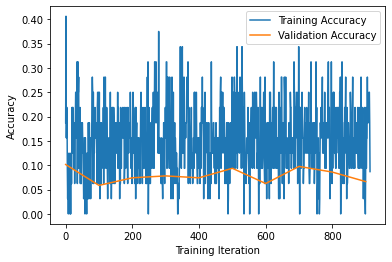

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 7/5000 [00:00<01:22, 60.60it/s]

  0%|          | 15/5000 [00:00<01:11, 69.49it/s]

  0%|          | 23/5000 [00:00<01:09, 72.02it/s]

  1%|          | 32/5000 [00:00<01:05, 76.17it/s]

  1%|          | 41/5000 [00:00<01:02, 79.32it/s]

  1%|          | 49/5000 [00:00<01:05, 75.36it/s]

  1%|          | 57/5000 [00:00<01:10, 69.75it/s]

  1%|▏         | 65/5000 [00:00<01:11, 68.99it/s]

  1%|▏         | 73/5000 [00:01<01:11, 68.65it/s]

  2%|▏         | 80/5000 [00:01<01:13, 66.62it/s]

  2%|▏         | 87/5000 [00:01<01:15, 65.06it/s]

  2%|▏         | 96/5000 [00:01<01:10, 69.89it/s]

  2%|▏         | 105/5000 [00:01<01:04, 75.35it/s]

  2%|▏         | 113/5000 [00:01<01:07, 72.39it/s]

  2%|▏         | 122/5000 [00:01<01:03, 76.68it/s]

  3%|▎         | 130/5000 [00:01<01:08, 71.25it/s]

  3%|▎         | 138/5000 [00:01<01:10, 69.33it/s]

  3%|▎         | 146/5000 [00:02<01:08, 71.38it/s]

  3%|▎         | 154/5000 [00:02<01:09, 69.90it/s]

  3%|▎         | 162/5000 [00:02<01:08, 70.89it/s]

  3%|▎         | 170/5000 [00:02<01:06, 72.96it/s]

  4%|▎         | 178/5000 [00:02<01:11, 67.11it/s]

  4%|▎         | 186/5000 [00:02<01:08, 70.00it/s]

  4%|▍         | 195/5000 [00:02<01:06, 72.29it/s]

  4%|▍         | 203/5000 [00:02<01:09, 69.40it/s]

  4%|▍         | 211/5000 [00:02<01:06, 71.89it/s]

  4%|▍         | 220/5000 [00:03<01:04, 74.64it/s]

  5%|▍         | 228/5000 [00:03<01:07, 71.22it/s]

  5%|▍         | 236/5000 [00:03<01:08, 69.45it/s]

  5%|▍         | 245/5000 [00:03<01:03, 74.35it/s]

  5%|▌         | 254/5000 [00:03<01:03, 75.04it/s]

  5%|▌         | 262/5000 [00:03<01:04, 73.06it/s]

  5%|▌         | 270/5000 [00:03<01:10, 67.43it/s]

  6%|▌         | 277/5000 [00:03<01:12, 65.49it/s]

  6%|▌         | 286/5000 [00:04<01:07, 70.27it/s]

  6%|▌         | 294/5000 [00:04<01:10, 66.57it/s]

  6%|▌         | 303/5000 [00:04<01:07, 69.65it/s]

  6%|▌         | 311/5000 [00:04<01:09, 67.80it/s]

  6%|▋         | 318/5000 [00:04<01:09, 67.84it/s]

  7%|▋         | 326/5000 [00:04<01:06, 69.81it/s]

  7%|▋         | 334/5000 [00:04<01:12, 64.20it/s]

  7%|▋         | 341/5000 [00:04<01:14, 62.17it/s]

  7%|▋         | 349/5000 [00:04<01:09, 66.61it/s]

  7%|▋         | 358/5000 [00:05<01:05, 70.59it/s]

  7%|▋         | 366/5000 [00:05<01:04, 71.63it/s]

  7%|▋         | 374/5000 [00:05<01:08, 67.55it/s]

  8%|▊         | 382/5000 [00:05<01:05, 70.37it/s]

  8%|▊         | 390/5000 [00:05<01:09, 66.81it/s]

  8%|▊         | 399/5000 [00:05<01:04, 71.40it/s]

  8%|▊         | 407/5000 [00:05<01:08, 67.23it/s]

  8%|▊         | 415/5000 [00:05<01:06, 69.18it/s]

  8%|▊         | 423/5000 [00:06<01:04, 70.88it/s]

  9%|▊         | 431/5000 [00:06<01:07, 67.37it/s]

  9%|▉         | 439/5000 [00:06<01:06, 68.70it/s]

  9%|▉         | 446/5000 [00:06<01:10, 64.52it/s]

  9%|▉         | 456/5000 [00:06<01:04, 70.21it/s]

  9%|▉         | 464/5000 [00:06<01:04, 69.86it/s]

  9%|▉         | 474/5000 [00:06<01:00, 74.65it/s]

 10%|▉         | 482/5000 [00:06<01:02, 72.80it/s]

 10%|▉         | 490/5000 [00:07<01:05, 69.20it/s]

 10%|▉         | 497/5000 [00:07<01:07, 66.81it/s]

 10%|█         | 504/5000 [00:07<01:07, 66.97it/s]

 10%|█         | 511/5000 [00:07<01:10, 63.91it/s]

 10%|█         | 518/5000 [00:07<01:11, 63.09it/s]

 10%|█         | 525/5000 [00:07<01:09, 63.96it/s]

 11%|█         | 534/5000 [00:07<01:03, 70.18it/s]

 11%|█         | 542/5000 [00:07<01:05, 68.04it/s]

 11%|█         | 550/5000 [00:07<01:03, 69.65it/s]

 11%|█         | 558/5000 [00:08<01:05, 67.92it/s]

 11%|█▏        | 565/5000 [00:08<01:07, 65.30it/s]

 11%|█▏        | 573/5000 [00:08<01:05, 67.28it/s]

 12%|█▏        | 580/5000 [00:08<01:06, 66.20it/s]

 12%|█▏        | 590/5000 [00:08<01:00, 73.30it/s]

 12%|█▏        | 599/5000 [00:08<00:58, 75.25it/s]

 12%|█▏        | 607/5000 [00:08<01:03, 69.67it/s]

 12%|█▏        | 615/5000 [00:08<01:04, 67.51it/s]

 12%|█▏        | 623/5000 [00:08<01:02, 70.39it/s]

 13%|█▎        | 631/5000 [00:09<01:02, 70.46it/s]

 13%|█▎        | 639/5000 [00:09<01:02, 69.69it/s]

 13%|█▎        | 647/5000 [00:09<01:04, 67.04it/s]

 13%|█▎        | 655/5000 [00:09<01:03, 68.39it/s]

 13%|█▎        | 663/5000 [00:09<01:02, 69.86it/s]

 13%|█▎        | 671/5000 [00:09<00:59, 72.22it/s]

 14%|█▎        | 679/5000 [00:09<01:00, 71.21it/s]

 14%|█▎        | 687/5000 [00:09<01:00, 71.35it/s]

 14%|█▍        | 696/5000 [00:09<00:58, 73.60it/s]

 14%|█▍        | 704/5000 [00:10<00:58, 73.26it/s]

 14%|█▍        | 712/5000 [00:10<00:57, 75.11it/s]

 14%|█▍        | 720/5000 [00:10<00:59, 72.13it/s]

 15%|█▍        | 728/5000 [00:10<01:01, 69.42it/s]

 15%|█▍        | 736/5000 [00:10<01:02, 68.69it/s]

 15%|█▍        | 744/5000 [00:10<00:59, 71.29it/s]

 15%|█▌        | 752/5000 [00:10<00:57, 73.42it/s]

 15%|█▌        | 760/5000 [00:10<00:57, 73.56it/s]

 15%|█▌        | 768/5000 [00:10<00:58, 72.31it/s]

 16%|█▌        | 776/5000 [00:11<00:57, 74.09it/s]

 16%|█▌        | 784/5000 [00:11<00:57, 73.24it/s]

 16%|█▌        | 792/5000 [00:11<00:59, 70.51it/s]

 16%|█▌        | 800/5000 [00:11<00:58, 71.25it/s]

 16%|█▌        | 808/5000 [00:11<01:00, 69.36it/s]

 16%|█▋        | 815/5000 [00:11<01:03, 66.06it/s]

 17%|█▋        | 826/5000 [00:11<00:54, 76.46it/s]

 17%|█▋        | 834/5000 [00:11<00:54, 75.99it/s]

 17%|█▋        | 842/5000 [00:12<00:56, 74.00it/s]

 17%|█▋        | 851/5000 [00:12<00:54, 75.58it/s]

 17%|█▋        | 859/5000 [00:12<00:54, 75.91it/s]

 17%|█▋        | 867/5000 [00:12<00:57, 72.39it/s]

 18%|█▊        | 875/5000 [00:12<00:58, 70.96it/s]

 18%|█▊        | 883/5000 [00:12<00:58, 70.26it/s]

 18%|█▊        | 891/5000 [00:12<00:57, 71.53it/s]

 18%|█▊        | 899/5000 [00:12<00:57, 71.54it/s]

 18%|█▊        | 907/5000 [00:12<00:59, 69.24it/s]

 18%|█▊        | 914/5000 [00:13<01:00, 67.39it/s]

 18%|█▊        | 921/5000 [00:13<01:02, 64.90it/s]

 19%|█▊        | 930/5000 [00:13<00:57, 70.82it/s]

 19%|█▉        | 938/5000 [00:13<00:58, 69.02it/s]

 19%|█▉        | 946/5000 [00:13<00:57, 70.78it/s]

 19%|█▉        | 954/5000 [00:13<00:57, 70.23it/s]

 19%|█▉        | 962/5000 [00:13<00:56, 71.09it/s]

 19%|█▉        | 970/5000 [00:13<00:59, 67.91it/s]

 20%|█▉        | 977/5000 [00:13<01:01, 65.66it/s]

 20%|█▉        | 986/5000 [00:14<00:58, 68.55it/s]

 20%|█▉        | 995/5000 [00:14<00:55, 72.78it/s]

 20%|██        | 1003/5000 [00:14<00:55, 72.39it/s]

 20%|██        | 1011/5000 [00:14<00:54, 73.47it/s]

 20%|██        | 1019/5000 [00:14<00:54, 73.71it/s]

 21%|██        | 1027/5000 [00:14<00:56, 70.06it/s]

 21%|██        | 1035/5000 [00:14<00:57, 68.89it/s]

 21%|██        | 1043/5000 [00:14<00:55, 71.79it/s]

 21%|██        | 1052/5000 [00:14<00:52, 75.09it/s]

 21%|██        | 1060/5000 [00:15<00:53, 73.11it/s]

 21%|██▏       | 1069/5000 [00:15<00:50, 77.50it/s]

 22%|██▏       | 1077/5000 [00:15<00:56, 69.84it/s]

 22%|██▏       | 1085/5000 [00:15<00:55, 70.47it/s]

 22%|██▏       | 1094/5000 [00:15<00:53, 73.35it/s]

 22%|██▏       | 1102/5000 [00:15<00:56, 68.72it/s]

 22%|██▏       | 1112/5000 [00:15<00:51, 75.86it/s]

 22%|██▏       | 1120/5000 [00:15<00:54, 71.25it/s]

 23%|██▎       | 1128/5000 [00:16<00:53, 71.99it/s]

 23%|██▎       | 1136/5000 [00:16<00:56, 68.35it/s]

 23%|██▎       | 1145/5000 [00:16<00:53, 72.21it/s]

 23%|██▎       | 1154/5000 [00:16<00:51, 75.27it/s]

 23%|██▎       | 1162/5000 [00:16<00:53, 71.33it/s]

 23%|██▎       | 1170/5000 [00:16<00:55, 68.44it/s]

 24%|██▎       | 1180/5000 [00:16<00:50, 75.39it/s]

 24%|██▍       | 1188/5000 [00:16<00:50, 74.77it/s]

 24%|██▍       | 1196/5000 [00:16<00:51, 73.16it/s]

 24%|██▍       | 1204/5000 [00:17<00:50, 74.46it/s]

 24%|██▍       | 1212/5000 [00:17<00:50, 74.83it/s]

 24%|██▍       | 1220/5000 [00:17<00:51, 73.53it/s]

 25%|██▍       | 1229/5000 [00:17<00:48, 77.71it/s]

 25%|██▍       | 1237/5000 [00:17<00:49, 76.13it/s]

 25%|██▍       | 1246/5000 [00:17<00:49, 75.55it/s]

 25%|██▌       | 1254/5000 [00:17<00:52, 71.95it/s]

 25%|██▌       | 1263/5000 [00:17<00:48, 76.54it/s]

 25%|██▌       | 1271/5000 [00:17<00:49, 75.24it/s]

 26%|██▌       | 1279/5000 [00:18<00:52, 70.82it/s]

 26%|██▌       | 1287/5000 [00:18<00:51, 72.30it/s]

 26%|██▌       | 1295/5000 [00:18<00:51, 71.57it/s]

 26%|██▌       | 1303/5000 [00:18<00:52, 70.58it/s]

 26%|██▌       | 1311/5000 [00:18<00:51, 71.48it/s]

 26%|██▋       | 1319/5000 [00:18<00:52, 70.62it/s]

 27%|██▋       | 1328/5000 [00:18<00:49, 73.93it/s]

 27%|██▋       | 1336/5000 [00:18<00:52, 69.61it/s]

 27%|██▋       | 1344/5000 [00:19<00:52, 69.40it/s]

 27%|██▋       | 1353/5000 [00:19<00:51, 71.07it/s]

 27%|██▋       | 1361/5000 [00:19<00:50, 72.14it/s]

 27%|██▋       | 1369/5000 [00:19<00:50, 72.62it/s]

 28%|██▊       | 1377/5000 [00:19<00:49, 73.84it/s]

 28%|██▊       | 1385/5000 [00:19<00:50, 72.03it/s]

 28%|██▊       | 1393/5000 [00:19<00:52, 68.59it/s]

 28%|██▊       | 1400/5000 [00:19<00:52, 68.28it/s]

 28%|██▊       | 1407/5000 [00:19<00:54, 65.78it/s]

 28%|██▊       | 1416/5000 [00:20<00:51, 70.23it/s]

 28%|██▊       | 1424/5000 [00:20<00:50, 71.24it/s]

 29%|██▊       | 1432/5000 [00:20<00:52, 67.49it/s]

 29%|██▉       | 1440/5000 [00:20<00:50, 70.38it/s]

 29%|██▉       | 1448/5000 [00:20<00:51, 68.99it/s]

 29%|██▉       | 1456/5000 [00:20<00:49, 71.61it/s]

 29%|██▉       | 1464/5000 [00:20<00:47, 73.90it/s]

 29%|██▉       | 1472/5000 [00:20<00:50, 70.46it/s]

 30%|██▉       | 1480/5000 [00:20<00:49, 71.31it/s]

 30%|██▉       | 1488/5000 [00:21<00:51, 67.99it/s]

 30%|██▉       | 1497/5000 [00:21<00:48, 72.24it/s]

 30%|███       | 1505/5000 [00:21<00:49, 70.98it/s]

 30%|███       | 1513/5000 [00:21<00:49, 69.91it/s]

 30%|███       | 1521/5000 [00:21<00:48, 71.39it/s]

 31%|███       | 1529/5000 [00:21<00:47, 72.62it/s]

 31%|███       | 1537/5000 [00:21<00:49, 70.38it/s]

 31%|███       | 1545/5000 [00:21<00:51, 67.53it/s]

 31%|███       | 1552/5000 [00:21<00:52, 66.05it/s]

 31%|███       | 1562/5000 [00:22<00:47, 71.90it/s]

 31%|███▏      | 1572/5000 [00:22<00:44, 77.46it/s]

 32%|███▏      | 1580/5000 [00:22<00:48, 70.75it/s]

 32%|███▏      | 1589/5000 [00:22<00:45, 74.32it/s]

 32%|███▏      | 1597/5000 [00:22<00:47, 71.57it/s]

 32%|███▏      | 1605/5000 [00:22<00:47, 71.50it/s]

 32%|███▏      | 1613/5000 [00:22<00:48, 69.55it/s]

 32%|███▏      | 1622/5000 [00:22<00:46, 72.74it/s]

 33%|███▎      | 1630/5000 [00:23<00:50, 67.20it/s]

 33%|███▎      | 1637/5000 [00:23<00:51, 65.65it/s]

 33%|███▎      | 1644/5000 [00:23<00:52, 64.17it/s]

 33%|███▎      | 1653/5000 [00:23<00:48, 69.56it/s]

 33%|███▎      | 1661/5000 [00:23<00:47, 70.30it/s]

 33%|███▎      | 1670/5000 [00:23<00:45, 73.96it/s]

 34%|███▎      | 1678/5000 [00:23<00:44, 74.46it/s]

 34%|███▎      | 1686/5000 [00:23<00:48, 67.78it/s]

 34%|███▍      | 1693/5000 [00:23<00:49, 66.66it/s]

 34%|███▍      | 1700/5000 [00:24<00:50, 65.07it/s]

 34%|███▍      | 1707/5000 [00:24<00:50, 65.16it/s]

 34%|███▍      | 1715/5000 [00:24<00:47, 69.22it/s]

 34%|███▍      | 1724/5000 [00:24<00:43, 75.02it/s]

 35%|███▍      | 1732/5000 [00:24<00:43, 74.90it/s]

 35%|███▍      | 1741/5000 [00:24<00:43, 75.34it/s]

 35%|███▍      | 1749/5000 [00:24<00:44, 73.42it/s]

 35%|███▌      | 1757/5000 [00:24<00:43, 73.73it/s]

 35%|███▌      | 1765/5000 [00:24<00:44, 71.91it/s]

 35%|███▌      | 1773/5000 [00:25<00:45, 70.24it/s]

 36%|███▌      | 1782/5000 [00:25<00:44, 72.90it/s]

 36%|███▌      | 1791/5000 [00:25<00:43, 74.22it/s]

 36%|███▌      | 1801/5000 [00:25<00:40, 79.34it/s]

 36%|███▌      | 1810/5000 [00:25<00:39, 80.72it/s]

 36%|███▋      | 1819/5000 [00:25<00:42, 74.42it/s]

 37%|███▋      | 1827/5000 [00:25<00:43, 73.54it/s]

 37%|███▋      | 1837/5000 [00:25<00:39, 79.74it/s]

 37%|███▋      | 1846/5000 [00:26<00:43, 72.93it/s]

 37%|███▋      | 1854/5000 [00:26<00:44, 70.21it/s]

 37%|███▋      | 1862/5000 [00:26<00:46, 67.77it/s]

 37%|███▋      | 1869/5000 [00:26<00:47, 66.03it/s]

 38%|███▊      | 1876/5000 [00:26<00:47, 65.65it/s]

 38%|███▊      | 1884/5000 [00:26<00:46, 67.57it/s]

 38%|███▊      | 1891/5000 [00:26<00:45, 67.76it/s]

 38%|███▊      | 1898/5000 [00:26<00:46, 67.04it/s]

 38%|███▊      | 1906/5000 [00:26<00:43, 70.40it/s]

 38%|███▊      | 1914/5000 [00:27<00:46, 66.26it/s]

 38%|███▊      | 1922/5000 [00:27<00:46, 66.48it/s]

 39%|███▊      | 1929/5000 [00:27<00:45, 67.37it/s]

 39%|███▊      | 1936/5000 [00:27<00:46, 65.56it/s]

 39%|███▉      | 1944/5000 [00:27<00:43, 69.51it/s]

 39%|███▉      | 1952/5000 [00:27<00:42, 71.39it/s]

 39%|███▉      | 1960/5000 [00:27<00:44, 68.74it/s]

 39%|███▉      | 1968/5000 [00:27<00:42, 71.61it/s]

 40%|███▉      | 1976/5000 [00:27<00:42, 71.04it/s]

 40%|███▉      | 1984/5000 [00:28<00:41, 72.47it/s]

 40%|███▉      | 1993/5000 [00:28<00:40, 74.32it/s]

 40%|████      | 2002/5000 [00:28<00:40, 74.83it/s]

 40%|████      | 2010/5000 [00:28<00:41, 72.17it/s]

 40%|████      | 2019/5000 [00:28<00:39, 75.46it/s]

 41%|████      | 2027/5000 [00:28<00:40, 74.29it/s]

 41%|████      | 2035/5000 [00:28<00:40, 73.71it/s]

 41%|████      | 2043/5000 [00:28<00:40, 72.54it/s]

 41%|████      | 2051/5000 [00:28<00:41, 70.60it/s]

 41%|████      | 2059/5000 [00:29<00:41, 70.07it/s]

 41%|████▏     | 2067/5000 [00:29<00:40, 71.82it/s]

 42%|████▏     | 2076/5000 [00:29<00:38, 75.39it/s]

 42%|████▏     | 2084/5000 [00:29<00:38, 74.93it/s]

 42%|████▏     | 2092/5000 [00:29<00:41, 70.55it/s]

 42%|████▏     | 2100/5000 [00:29<00:40, 71.57it/s]

 42%|████▏     | 2108/5000 [00:29<00:44, 64.37it/s]

 42%|████▏     | 2116/5000 [00:29<00:43, 66.88it/s]

 42%|████▏     | 2123/5000 [00:30<00:42, 67.59it/s]

 43%|████▎     | 2130/5000 [00:30<00:43, 66.32it/s]

 43%|████▎     | 2137/5000 [00:30<00:42, 66.69it/s]

 43%|████▎     | 2144/5000 [00:30<00:45, 62.57it/s]

 43%|████▎     | 2152/5000 [00:30<00:42, 66.86it/s]

 43%|████▎     | 2160/5000 [00:30<00:40, 70.43it/s]

 43%|████▎     | 2168/5000 [00:30<00:40, 69.92it/s]

 44%|████▎     | 2176/5000 [00:30<00:41, 67.90it/s]

 44%|████▎     | 2184/5000 [00:30<00:40, 69.80it/s]

 44%|████▍     | 2193/5000 [00:31<00:38, 73.01it/s]

 44%|████▍     | 2201/5000 [00:31<00:39, 70.65it/s]

 44%|████▍     | 2209/5000 [00:31<00:39, 70.60it/s]

 44%|████▍     | 2217/5000 [00:31<00:38, 72.08it/s]

 44%|████▍     | 2225/5000 [00:31<00:39, 70.97it/s]

 45%|████▍     | 2233/5000 [00:31<00:39, 69.28it/s]

 45%|████▍     | 2243/5000 [00:31<00:37, 73.48it/s]

 45%|████▌     | 2251/5000 [00:31<00:38, 71.24it/s]

 45%|████▌     | 2259/5000 [00:31<00:40, 67.98it/s]

 45%|████▌     | 2266/5000 [00:32<00:40, 67.91it/s]

 45%|████▌     | 2274/5000 [00:32<00:39, 69.17it/s]

 46%|████▌     | 2282/5000 [00:32<00:38, 71.25it/s]

 46%|████▌     | 2290/5000 [00:32<00:38, 70.35it/s]

 46%|████▌     | 2299/5000 [00:32<00:36, 73.23it/s]

 46%|████▌     | 2308/5000 [00:32<00:34, 77.30it/s]

 46%|████▋     | 2316/5000 [00:32<00:36, 73.86it/s]

 46%|████▋     | 2324/5000 [00:32<00:36, 73.75it/s]

 47%|████▋     | 2332/5000 [00:32<00:37, 70.93it/s]

 47%|████▋     | 2340/5000 [00:33<00:38, 68.49it/s]

 47%|████▋     | 2348/5000 [00:33<00:37, 71.20it/s]

 47%|████▋     | 2356/5000 [00:33<00:38, 68.46it/s]

 47%|████▋     | 2364/5000 [00:33<00:37, 70.51it/s]

 47%|████▋     | 2372/5000 [00:33<00:36, 72.08it/s]

 48%|████▊     | 2380/5000 [00:33<00:35, 74.02it/s]

 48%|████▊     | 2388/5000 [00:33<00:35, 73.39it/s]

 48%|████▊     | 2396/5000 [00:33<00:34, 74.83it/s]

 48%|████▊     | 2404/5000 [00:33<00:35, 73.10it/s]

 48%|████▊     | 2412/5000 [00:34<00:36, 71.04it/s]

 48%|████▊     | 2420/5000 [00:34<00:36, 70.01it/s]

 49%|████▊     | 2428/5000 [00:34<00:37, 68.05it/s]

 49%|████▊     | 2435/5000 [00:34<00:38, 66.91it/s]

 49%|████▉     | 2444/5000 [00:34<00:36, 70.36it/s]

 49%|████▉     | 2453/5000 [00:34<00:34, 74.63it/s]

 49%|████▉     | 2462/5000 [00:34<00:32, 77.20it/s]

 49%|████▉     | 2470/5000 [00:34<00:35, 71.16it/s]

 50%|████▉     | 2478/5000 [00:35<00:36, 69.43it/s]

 50%|████▉     | 2486/5000 [00:35<00:35, 70.97it/s]

 50%|████▉     | 2494/5000 [00:35<00:34, 71.90it/s]

 50%|█████     | 2503/5000 [00:35<00:33, 74.36it/s]

 50%|█████     | 2511/5000 [00:35<00:34, 71.15it/s]

 50%|█████     | 2520/5000 [00:35<00:33, 74.28it/s]

 51%|█████     | 2528/5000 [00:35<00:35, 70.61it/s]

 51%|█████     | 2537/5000 [00:35<00:34, 71.83it/s]

 51%|█████     | 2546/5000 [00:35<00:32, 74.88it/s]

 51%|█████     | 2554/5000 [00:36<00:33, 72.09it/s]

 51%|█████▏    | 2563/5000 [00:36<00:32, 75.23it/s]

 51%|█████▏    | 2571/5000 [00:36<00:32, 74.87it/s]

 52%|█████▏    | 2579/5000 [00:36<00:34, 69.80it/s]

 52%|█████▏    | 2587/5000 [00:36<00:34, 69.06it/s]

 52%|█████▏    | 2594/5000 [00:36<00:35, 68.54it/s]

 52%|█████▏    | 2601/5000 [00:36<00:35, 67.99it/s]

 52%|█████▏    | 2610/5000 [00:36<00:33, 71.01it/s]

 52%|█████▏    | 2618/5000 [00:36<00:35, 67.12it/s]

 52%|█████▎    | 2625/5000 [00:37<00:36, 64.93it/s]

 53%|█████▎    | 2632/5000 [00:37<00:38, 62.09it/s]

 53%|█████▎    | 2640/5000 [00:37<00:37, 63.64it/s]

 53%|█████▎    | 2647/5000 [00:37<00:36, 65.07it/s]

 53%|█████▎    | 2655/5000 [00:37<00:34, 67.55it/s]

 53%|█████▎    | 2663/5000 [00:37<00:33, 69.77it/s]

 53%|█████▎    | 2673/5000 [00:37<00:29, 77.66it/s]

 54%|█████▎    | 2682/5000 [00:37<00:28, 80.55it/s]

 54%|█████▍    | 2691/5000 [00:37<00:29, 78.35it/s]

 54%|█████▍    | 2699/5000 [00:38<00:30, 76.56it/s]

 54%|█████▍    | 2707/5000 [00:38<00:31, 73.44it/s]

 54%|█████▍    | 2715/5000 [00:38<00:31, 72.34it/s]

 54%|█████▍    | 2723/5000 [00:38<00:32, 69.76it/s]

 55%|█████▍    | 2731/5000 [00:38<00:32, 69.44it/s]

 55%|█████▍    | 2739/5000 [00:38<00:31, 71.48it/s]

 55%|█████▍    | 2747/5000 [00:38<00:31, 72.45it/s]

 55%|█████▌    | 2755/5000 [00:38<00:30, 72.89it/s]

 55%|█████▌    | 2764/5000 [00:39<00:29, 76.91it/s]

 55%|█████▌    | 2773/5000 [00:39<00:28, 77.96it/s]

 56%|█████▌    | 2781/5000 [00:39<00:29, 75.10it/s]

 56%|█████▌    | 2790/5000 [00:39<00:28, 78.66it/s]

 56%|█████▌    | 2798/5000 [00:39<00:28, 76.81it/s]

 56%|█████▌    | 2806/5000 [00:39<00:30, 72.60it/s]

 56%|█████▋    | 2814/5000 [00:39<00:31, 69.13it/s]

 56%|█████▋    | 2822/5000 [00:39<00:30, 71.49it/s]

 57%|█████▋    | 2830/5000 [00:39<00:30, 72.21it/s]

 57%|█████▋    | 2838/5000 [00:40<00:29, 72.30it/s]

 57%|█████▋    | 2846/5000 [00:40<00:29, 73.91it/s]

 57%|█████▋    | 2854/5000 [00:40<00:31, 68.45it/s]

 57%|█████▋    | 2861/5000 [00:40<00:31, 67.75it/s]

 57%|█████▋    | 2868/5000 [00:40<00:31, 67.79it/s]

 58%|█████▊    | 2876/5000 [00:40<00:30, 69.99it/s]

 58%|█████▊    | 2886/5000 [00:40<00:27, 76.96it/s]

 58%|█████▊    | 2894/5000 [00:40<00:27, 76.54it/s]

 58%|█████▊    | 2902/5000 [00:40<00:28, 73.46it/s]

 58%|█████▊    | 2910/5000 [00:41<00:28, 73.48it/s]

 58%|█████▊    | 2918/5000 [00:41<00:29, 71.24it/s]

 59%|█████▊    | 2926/5000 [00:41<00:28, 72.50it/s]

 59%|█████▊    | 2934/5000 [00:41<00:28, 73.06it/s]

 59%|█████▉    | 2942/5000 [00:41<00:29, 68.78it/s]

 59%|█████▉    | 2949/5000 [00:41<00:30, 67.76it/s]

 59%|█████▉    | 2959/5000 [00:41<00:27, 73.83it/s]

 59%|█████▉    | 2967/5000 [00:41<00:28, 72.51it/s]

 60%|█████▉    | 2975/5000 [00:41<00:28, 70.86it/s]

 60%|█████▉    | 2984/5000 [00:42<00:27, 72.89it/s]

 60%|█████▉    | 2992/5000 [00:42<00:28, 70.44it/s]

 60%|██████    | 3001/5000 [00:42<00:27, 73.11it/s]

 60%|██████    | 3009/5000 [00:42<00:28, 70.18it/s]

 60%|██████    | 3017/5000 [00:42<00:28, 70.08it/s]

 60%|██████    | 3025/5000 [00:42<00:29, 67.48it/s]

 61%|██████    | 3032/5000 [00:42<00:29, 67.20it/s]

 61%|██████    | 3040/5000 [00:42<00:28, 68.60it/s]

 61%|██████    | 3048/5000 [00:42<00:27, 71.38it/s]

 61%|██████    | 3056/5000 [00:43<00:27, 69.51it/s]

 61%|██████▏   | 3064/5000 [00:43<00:27, 70.44it/s]

 61%|██████▏   | 3073/5000 [00:43<00:26, 73.97it/s]

 62%|██████▏   | 3081/5000 [00:43<00:27, 70.78it/s]

 62%|██████▏   | 3089/5000 [00:43<00:26, 72.56it/s]

 62%|██████▏   | 3097/5000 [00:43<00:27, 69.94it/s]

 62%|██████▏   | 3105/5000 [00:43<00:28, 67.65it/s]

 62%|██████▏   | 3112/5000 [00:43<00:28, 66.53it/s]

 62%|██████▏   | 3122/5000 [00:44<00:25, 73.11it/s]

 63%|██████▎   | 3131/5000 [00:44<00:24, 75.98it/s]

 63%|██████▎   | 3139/5000 [00:44<00:26, 69.85it/s]

 63%|██████▎   | 3147/5000 [00:44<00:27, 67.36it/s]

 63%|██████▎   | 3155/5000 [00:44<00:27, 68.10it/s]

 63%|██████▎   | 3162/5000 [00:44<00:27, 66.31it/s]

 63%|██████▎   | 3171/5000 [00:44<00:25, 70.77it/s]

 64%|██████▎   | 3179/5000 [00:44<00:26, 68.35it/s]

 64%|██████▎   | 3186/5000 [00:44<00:26, 67.79it/s]

 64%|██████▍   | 3193/5000 [00:45<00:27, 66.21it/s]

 64%|██████▍   | 3200/5000 [00:45<00:28, 63.85it/s]

 64%|██████▍   | 3208/5000 [00:45<00:26, 66.53it/s]

 64%|██████▍   | 3215/5000 [00:45<00:27, 65.73it/s]

 64%|██████▍   | 3222/5000 [00:45<00:27, 65.18it/s]

 65%|██████▍   | 3232/5000 [00:45<00:23, 73.68it/s]

 65%|██████▍   | 3240/5000 [00:45<00:23, 73.96it/s]

 65%|██████▍   | 3248/5000 [00:45<00:23, 74.16it/s]

 65%|██████▌   | 3256/5000 [00:45<00:23, 73.35it/s]

 65%|██████▌   | 3264/5000 [00:46<00:24, 70.92it/s]

 65%|██████▌   | 3272/5000 [00:46<00:24, 70.22it/s]

 66%|██████▌   | 3280/5000 [00:46<00:24, 69.77it/s]

 66%|██████▌   | 3288/5000 [00:46<00:23, 72.20it/s]

 66%|██████▌   | 3296/5000 [00:46<00:24, 69.04it/s]

 66%|██████▌   | 3303/5000 [00:46<00:26, 65.07it/s]

 66%|██████▌   | 3310/5000 [00:46<00:25, 66.06it/s]

 66%|██████▋   | 3317/5000 [00:46<00:26, 64.42it/s]

 66%|██████▋   | 3325/5000 [00:46<00:25, 66.60it/s]

 67%|██████▋   | 3332/5000 [00:47<00:25, 66.45it/s]

 67%|██████▋   | 3339/5000 [00:47<00:24, 67.30it/s]

 67%|██████▋   | 3346/5000 [00:47<00:24, 67.44it/s]

 67%|██████▋   | 3356/5000 [00:47<00:21, 75.83it/s]

 67%|██████▋   | 3364/5000 [00:47<00:22, 74.35it/s]

 67%|██████▋   | 3372/5000 [00:47<00:22, 70.83it/s]

 68%|██████▊   | 3380/5000 [00:47<00:22, 73.17it/s]

 68%|██████▊   | 3389/5000 [00:47<00:21, 74.31it/s]

 68%|██████▊   | 3398/5000 [00:47<00:20, 76.96it/s]

 68%|██████▊   | 3406/5000 [00:48<00:22, 71.49it/s]

 68%|██████▊   | 3414/5000 [00:48<00:21, 72.59it/s]

 68%|██████▊   | 3422/5000 [00:48<00:21, 71.98it/s]

 69%|██████▊   | 3430/5000 [00:48<00:21, 72.35it/s]

 69%|██████▉   | 3438/5000 [00:48<00:22, 68.74it/s]

 69%|██████▉   | 3446/5000 [00:48<00:21, 71.71it/s]

 69%|██████▉   | 3454/5000 [00:48<00:22, 69.30it/s]

 69%|██████▉   | 3462/5000 [00:48<00:22, 68.77it/s]

 69%|██████▉   | 3470/5000 [00:49<00:21, 71.06it/s]

 70%|██████▉   | 3478/5000 [00:49<00:22, 66.98it/s]

 70%|██████▉   | 3486/5000 [00:49<00:21, 69.35it/s]

 70%|██████▉   | 3494/5000 [00:49<00:21, 69.11it/s]

 70%|███████   | 3501/5000 [00:49<00:21, 68.33it/s]

 70%|███████   | 3510/5000 [00:49<00:20, 73.27it/s]

 70%|███████   | 3519/5000 [00:49<00:19, 76.90it/s]

 71%|███████   | 3527/5000 [00:49<00:19, 75.55it/s]

 71%|███████   | 3535/5000 [00:49<00:19, 73.76it/s]

 71%|███████   | 3543/5000 [00:50<00:20, 72.64it/s]

 71%|███████   | 3551/5000 [00:50<00:19, 73.70it/s]

 71%|███████   | 3559/5000 [00:50<00:20, 69.47it/s]

 71%|███████▏  | 3567/5000 [00:50<00:20, 69.89it/s]

 72%|███████▏  | 3576/5000 [00:50<00:19, 74.77it/s]

 72%|███████▏  | 3584/5000 [00:50<00:20, 70.71it/s]

 72%|███████▏  | 3592/5000 [00:50<00:20, 69.57it/s]

 72%|███████▏  | 3600/5000 [00:50<00:19, 71.12it/s]

 72%|███████▏  | 3609/5000 [00:50<00:18, 74.24it/s]

 72%|███████▏  | 3617/5000 [00:51<00:18, 74.79it/s]

 72%|███████▎  | 3625/5000 [00:51<00:18, 73.05it/s]

 73%|███████▎  | 3633/5000 [00:51<00:19, 71.04it/s]

 73%|███████▎  | 3641/5000 [00:51<00:18, 73.01it/s]

 73%|███████▎  | 3649/5000 [00:51<00:19, 68.17it/s]

 73%|███████▎  | 3656/5000 [00:51<00:19, 67.90it/s]

 73%|███████▎  | 3663/5000 [00:51<00:20, 66.32it/s]

 73%|███████▎  | 3670/5000 [00:51<00:19, 67.00it/s]

 74%|███████▎  | 3677/5000 [00:51<00:19, 67.51it/s]

 74%|███████▎  | 3685/5000 [00:52<00:18, 70.88it/s]

 74%|███████▍  | 3695/5000 [00:52<00:16, 78.32it/s]

 74%|███████▍  | 3703/5000 [00:52<00:17, 74.89it/s]

 74%|███████▍  | 3711/5000 [00:52<00:17, 72.87it/s]

 74%|███████▍  | 3722/5000 [00:52<00:15, 81.12it/s]

 75%|███████▍  | 3731/5000 [00:52<00:15, 80.53it/s]

 75%|███████▍  | 3740/5000 [00:52<00:16, 76.93it/s]

 75%|███████▍  | 3748/5000 [00:52<00:16, 74.24it/s]

 75%|███████▌  | 3756/5000 [00:52<00:17, 71.21it/s]

 75%|███████▌  | 3764/5000 [00:53<00:17, 72.48it/s]

 75%|███████▌  | 3772/5000 [00:53<00:16, 74.00it/s]

 76%|███████▌  | 3780/5000 [00:53<00:16, 72.88it/s]

 76%|███████▌  | 3788/5000 [00:53<00:16, 72.61it/s]

 76%|███████▌  | 3796/5000 [00:53<00:16, 74.56it/s]

 76%|███████▌  | 3804/5000 [00:53<00:16, 72.71it/s]

 76%|███████▌  | 3812/5000 [00:53<00:16, 72.39it/s]

 76%|███████▋  | 3820/5000 [00:53<00:16, 72.36it/s]

 77%|███████▋  | 3828/5000 [00:53<00:15, 74.28it/s]

 77%|███████▋  | 3836/5000 [00:54<00:16, 68.73it/s]

 77%|███████▋  | 3843/5000 [00:54<00:17, 66.77it/s]

 77%|███████▋  | 3852/5000 [00:54<00:15, 72.68it/s]

 77%|███████▋  | 3860/5000 [00:54<00:15, 71.25it/s]

 77%|███████▋  | 3868/5000 [00:54<00:15, 71.01it/s]

 78%|███████▊  | 3877/5000 [00:54<00:14, 75.17it/s]

 78%|███████▊  | 3885/5000 [00:54<00:14, 76.27it/s]

 78%|███████▊  | 3893/5000 [00:54<00:15, 70.76it/s]

 78%|███████▊  | 3901/5000 [00:54<00:15, 70.58it/s]

 78%|███████▊  | 3909/5000 [00:55<00:15, 70.37it/s]

 78%|███████▊  | 3917/5000 [00:55<00:15, 69.25it/s]

 78%|███████▊  | 3925/5000 [00:55<00:15, 70.47it/s]

 79%|███████▊  | 3933/5000 [00:55<00:15, 70.28it/s]

 79%|███████▉  | 3941/5000 [00:55<00:14, 72.24it/s]

 79%|███████▉  | 3949/5000 [00:55<00:14, 73.86it/s]

 79%|███████▉  | 3957/5000 [00:55<00:14, 70.91it/s]

 79%|███████▉  | 3965/5000 [00:55<00:15, 67.28it/s]

 79%|███████▉  | 3974/5000 [00:56<00:14, 70.06it/s]

 80%|███████▉  | 3984/5000 [00:56<00:13, 76.49it/s]

 80%|███████▉  | 3992/5000 [00:56<00:14, 68.80it/s]

 80%|████████  | 4000/5000 [00:56<00:14, 67.78it/s]

 80%|████████  | 4008/5000 [00:56<00:14, 69.18it/s]

 80%|████████  | 4017/5000 [00:56<00:13, 72.69it/s]

 81%|████████  | 4026/5000 [00:56<00:12, 75.30it/s]

 81%|████████  | 4034/5000 [00:56<00:12, 74.84it/s]

 81%|████████  | 4043/5000 [00:56<00:12, 75.23it/s]

 81%|████████  | 4052/5000 [00:57<00:12, 75.01it/s]

 81%|████████  | 4060/5000 [00:57<00:13, 68.10it/s]

 81%|████████▏ | 4067/5000 [00:57<00:14, 66.24it/s]

 82%|████████▏ | 4076/5000 [00:57<00:12, 71.43it/s]

 82%|████████▏ | 4084/5000 [00:57<00:12, 71.36it/s]

 82%|████████▏ | 4092/5000 [00:57<00:12, 72.10it/s]

 82%|████████▏ | 4100/5000 [00:57<00:12, 72.18it/s]

 82%|████████▏ | 4109/5000 [00:57<00:12, 73.06it/s]

 82%|████████▏ | 4117/5000 [00:57<00:11, 74.82it/s]

 82%|████████▎ | 4125/5000 [00:58<00:12, 71.09it/s]

 83%|████████▎ | 4134/5000 [00:58<00:11, 74.13it/s]

 83%|████████▎ | 4143/5000 [00:58<00:10, 77.97it/s]

 83%|████████▎ | 4151/5000 [00:58<00:10, 77.48it/s]

 83%|████████▎ | 4160/5000 [00:58<00:10, 76.99it/s]

 83%|████████▎ | 4168/5000 [00:58<00:10, 76.89it/s]

 84%|████████▎ | 4176/5000 [00:58<00:10, 76.95it/s]

 84%|████████▎ | 4184/5000 [00:58<00:10, 74.73it/s]

 84%|████████▍ | 4192/5000 [00:58<00:10, 75.71it/s]

 84%|████████▍ | 4200/5000 [00:59<00:10, 73.51it/s]

 84%|████████▍ | 4208/5000 [00:59<00:11, 70.70it/s]

 84%|████████▍ | 4216/5000 [00:59<00:11, 65.73it/s]

 84%|████████▍ | 4225/5000 [00:59<00:10, 71.22it/s]

 85%|████████▍ | 4234/5000 [00:59<00:10, 72.37it/s]

 85%|████████▍ | 4242/5000 [00:59<00:11, 67.28it/s]

 85%|████████▌ | 4250/5000 [00:59<00:10, 70.03it/s]

 85%|████████▌ | 4258/5000 [00:59<00:10, 69.23it/s]

 85%|████████▌ | 4266/5000 [01:00<00:10, 69.60it/s]

 85%|████████▌ | 4274/5000 [01:00<00:10, 69.36it/s]

 86%|████████▌ | 4283/5000 [01:00<00:10, 70.95it/s]

 86%|████████▌ | 4292/5000 [01:00<00:09, 73.88it/s]

 86%|████████▌ | 4300/5000 [01:00<00:09, 73.50it/s]

 86%|████████▌ | 4308/5000 [01:00<00:09, 71.26it/s]

 86%|████████▋ | 4316/5000 [01:00<00:09, 73.09it/s]

 86%|████████▋ | 4324/5000 [01:00<00:09, 74.20it/s]

 87%|████████▋ | 4333/5000 [01:00<00:08, 76.53it/s]

 87%|████████▋ | 4342/5000 [01:01<00:08, 75.72it/s]

 87%|████████▋ | 4350/5000 [01:01<00:09, 71.84it/s]

 87%|████████▋ | 4358/5000 [01:01<00:09, 68.19it/s]

 87%|████████▋ | 4365/5000 [01:01<00:09, 68.07it/s]

 87%|████████▋ | 4372/5000 [01:01<00:09, 67.87it/s]

 88%|████████▊ | 4379/5000 [01:01<00:09, 64.96it/s]

 88%|████████▊ | 4386/5000 [01:01<00:09, 66.31it/s]

 88%|████████▊ | 4393/5000 [01:01<00:09, 66.21it/s]

 88%|████████▊ | 4401/5000 [01:01<00:08, 68.34it/s]

 88%|████████▊ | 4409/5000 [01:02<00:08, 69.90it/s]

 88%|████████▊ | 4418/5000 [01:02<00:07, 73.22it/s]

 89%|████████▊ | 4426/5000 [01:02<00:07, 74.94it/s]

 89%|████████▊ | 4434/5000 [01:02<00:07, 73.97it/s]

 89%|████████▉ | 4442/5000 [01:02<00:07, 72.87it/s]

 89%|████████▉ | 4450/5000 [01:02<00:08, 67.49it/s]

 89%|████████▉ | 4459/5000 [01:02<00:07, 71.76it/s]

 89%|████████▉ | 4467/5000 [01:02<00:07, 71.85it/s]

 90%|████████▉ | 4475/5000 [01:03<00:07, 68.64it/s]

 90%|████████▉ | 4484/5000 [01:03<00:07, 72.68it/s]

 90%|████████▉ | 4492/5000 [01:03<00:07, 70.14it/s]

 90%|█████████ | 4500/5000 [01:03<00:07, 71.29it/s]

 90%|█████████ | 4508/5000 [01:03<00:06, 73.33it/s]

 90%|█████████ | 4516/5000 [01:03<00:06, 72.02it/s]

 90%|█████████ | 4524/5000 [01:03<00:06, 72.72it/s]

 91%|█████████ | 4533/5000 [01:03<00:06, 76.40it/s]

 91%|█████████ | 4541/5000 [01:03<00:06, 72.58it/s]

 91%|█████████ | 4549/5000 [01:04<00:06, 68.41it/s]

 91%|█████████ | 4556/5000 [01:04<00:06, 67.41it/s]

 91%|█████████▏| 4563/5000 [01:04<00:06, 67.68it/s]

 91%|█████████▏| 4570/5000 [01:04<00:06, 67.43it/s]

 92%|█████████▏| 4578/5000 [01:04<00:06, 69.82it/s]

 92%|█████████▏| 4586/5000 [01:04<00:05, 72.25it/s]

 92%|█████████▏| 4594/5000 [01:04<00:05, 70.74it/s]

 92%|█████████▏| 4602/5000 [01:04<00:05, 72.08it/s]

 92%|█████████▏| 4610/5000 [01:04<00:05, 72.24it/s]

 92%|█████████▏| 4618/5000 [01:05<00:05, 66.04it/s]

 92%|█████████▎| 4625/5000 [01:05<00:05, 65.21it/s]

 93%|█████████▎| 4633/5000 [01:05<00:05, 67.99it/s]

 93%|█████████▎| 4640/5000 [01:05<00:05, 66.56it/s]

 93%|█████████▎| 4647/5000 [01:05<00:05, 66.19it/s]

 93%|█████████▎| 4654/5000 [01:05<00:05, 62.22it/s]

 93%|█████████▎| 4664/5000 [01:05<00:04, 70.96it/s]

 93%|█████████▎| 4673/5000 [01:05<00:04, 74.82it/s]

 94%|█████████▎| 4681/5000 [01:05<00:04, 68.98it/s]

 94%|█████████▍| 4689/5000 [01:06<00:04, 68.30it/s]

 94%|█████████▍| 4696/5000 [01:06<00:04, 68.61it/s]

 94%|█████████▍| 4703/5000 [01:06<00:04, 68.28it/s]

 94%|█████████▍| 4710/5000 [01:06<00:04, 65.05it/s]

 94%|█████████▍| 4717/5000 [01:06<00:04, 65.86it/s]

 94%|█████████▍| 4724/5000 [01:06<00:04, 66.32it/s]

 95%|█████████▍| 4732/5000 [01:06<00:03, 69.44it/s]

 95%|█████████▍| 4739/5000 [01:06<00:03, 67.83it/s]

 95%|█████████▍| 4746/5000 [01:06<00:03, 64.48it/s]

 95%|█████████▌| 4756/5000 [01:07<00:03, 72.64it/s]

 95%|█████████▌| 4764/5000 [01:07<00:03, 70.20it/s]

 95%|█████████▌| 4772/5000 [01:07<00:03, 67.52it/s]

 96%|█████████▌| 4780/5000 [01:07<00:03, 70.20it/s]

 96%|█████████▌| 4788/5000 [01:07<00:03, 70.59it/s]

 96%|█████████▌| 4796/5000 [01:07<00:03, 65.29it/s]

 96%|█████████▌| 4804/5000 [01:07<00:02, 67.24it/s]

 96%|█████████▌| 4812/5000 [01:07<00:02, 69.56it/s]

 96%|█████████▋| 4820/5000 [01:08<00:02, 63.66it/s]

 97%|█████████▋| 4827/5000 [01:08<00:02, 62.48it/s]

 97%|█████████▋| 4836/5000 [01:08<00:02, 68.63it/s]

 97%|█████████▋| 4844/5000 [01:08<00:02, 68.05it/s]

 97%|█████████▋| 4852/5000 [01:08<00:02, 70.20it/s]

 97%|█████████▋| 4860/5000 [01:08<00:01, 72.07it/s]

 97%|█████████▋| 4868/5000 [01:08<00:01, 71.51it/s]

 98%|█████████▊| 4876/5000 [01:08<00:01, 69.30it/s]

 98%|█████████▊| 4883/5000 [01:08<00:01, 67.55it/s]

 98%|█████████▊| 4891/5000 [01:09<00:01, 69.14it/s]

 98%|█████████▊| 4898/5000 [01:09<00:01, 68.67it/s]

 98%|█████████▊| 4905/5000 [01:09<00:01, 67.01it/s]

 98%|█████████▊| 4912/5000 [01:09<00:01, 67.48it/s]

 98%|█████████▊| 4921/5000 [01:09<00:01, 70.25it/s]

 99%|█████████▊| 4929/5000 [01:09<00:01, 66.96it/s]

 99%|█████████▊| 4936/5000 [01:09<00:00, 67.39it/s]

 99%|█████████▉| 4943/5000 [01:09<00:00, 66.14it/s]

 99%|█████████▉| 4950/5000 [01:09<00:00, 60.27it/s]

 99%|█████████▉| 4958/5000 [01:10<00:00, 63.00it/s]

 99%|█████████▉| 4965/5000 [01:10<00:00, 62.34it/s]

 99%|█████████▉| 4973/5000 [01:10<00:00, 65.59it/s]

100%|█████████▉| 4981/5000 [01:10<00:00, 65.49it/s]

100%|█████████▉| 4988/5000 [01:10<00:00, 61.75it/s]

100%|█████████▉| 4996/5000 [01:10<00:00, 64.10it/s]

100%|██████████| 5000/5000 [01:10<00:00, 70.70it/s]

  0%|          | 0/5336 [00:00<?, ?it/s]

  0%|          | 8/5336 [00:00<01:13, 72.86it/s]

  0%|          | 16/5336 [00:00<01:18, 67.36it/s]

  0%|          | 23/5336 [00:00<01:18, 67.99it/s]

  1%|          | 30/5336 [00:00<01:18, 67.74it/s]

  1%|          | 38/5336 [00:00<01:17, 68.31it/s]

  1%|          | 45/5336 [00:00<01:20, 65.95it/s]

  1%|          | 53/5336 [00:00<01:16, 69.03it/s]

  1%|          | 61/5336 [00:00<01:14, 71.17it/s]

  1%|▏         | 70/5336 [00:00<01:09, 75.85it/s]

  1%|▏         | 79/5336 [00:01<01:06, 78.63it/s]

  2%|▏         | 87/5336 [00:01<01:12, 72.50it/s]

  2%|▏         | 95/5336 [00:01<01:13, 71.18it/s]

  2%|▏         | 103/5336 [00:01<01:15, 69.30it/s]

  2%|▏         | 110/5336 [00:01<01:15, 69.02it/s]

  2%|▏         | 117/5336 [00:01<01:18, 66.58it/s]

  2%|▏         | 124/5336 [00:01<01:22, 63.42it/s]

  2%|▏         | 132/5336 [00:01<01:18, 66.70it/s]

  3%|▎         | 139/5336 [00:02<01:22, 62.65it/s]

  3%|▎         | 147/5336 [00:02<01:17, 66.71it/s]

  3%|▎         | 154/5336 [00:02<01:18, 66.20it/s]

  3%|▎         | 162/5336 [00:02<01:17, 66.62it/s]

  3%|▎         | 169/5336 [00:02<01:16, 67.44it/s]

  3%|▎         | 177/5336 [00:02<01:13, 70.29it/s]

  3%|▎         | 185/5336 [00:02<01:12, 71.18it/s]

  4%|▎         | 193/5336 [00:02<01:11, 71.57it/s]

  4%|▍         | 201/5336 [00:02<01:09, 73.67it/s]

  4%|▍         | 209/5336 [00:03<01:10, 72.47it/s]

  4%|▍         | 217/5336 [00:03<01:13, 69.69it/s]

  4%|▍         | 225/5336 [00:03<01:13, 69.90it/s]

  4%|▍         | 233/5336 [00:03<01:14, 68.83it/s]

  4%|▍         | 240/5336 [00:03<01:15, 67.92it/s]

  5%|▍         | 248/5336 [00:03<01:15, 67.41it/s]

  5%|▍         | 255/5336 [00:03<01:14, 67.85it/s]

  5%|▍         | 262/5336 [00:03<01:18, 64.29it/s]

  5%|▌         | 269/5336 [00:03<01:23, 60.51it/s]

  5%|▌         | 276/5336 [00:04<01:22, 61.61it/s]

  5%|▌         | 284/5336 [00:04<01:16, 65.82it/s]

  5%|▌         | 291/5336 [00:04<01:16, 65.85it/s]

  6%|▌         | 299/5336 [00:04<01:15, 66.94it/s]

  6%|▌         | 308/5336 [00:04<01:09, 71.99it/s]

  6%|▌         | 317/5336 [00:04<01:05, 76.62it/s]

  6%|▌         | 325/5336 [00:04<01:09, 71.98it/s]

  6%|▋         | 334/5336 [00:04<01:05, 76.15it/s]

  6%|▋         | 343/5336 [00:04<01:04, 77.98it/s]

  7%|▋         | 351/5336 [00:05<01:04, 77.06it/s]

  7%|▋         | 359/5336 [00:05<01:05, 75.78it/s]

  7%|▋         | 367/5336 [00:05<01:10, 70.36it/s]

  7%|▋         | 375/5336 [00:05<01:12, 68.56it/s]

  7%|▋         | 382/5336 [00:05<01:13, 67.58it/s]

  7%|▋         | 391/5336 [00:05<01:07, 73.34it/s]

  7%|▋         | 399/5336 [00:05<01:05, 74.87it/s]

  8%|▊         | 407/5336 [00:05<01:05, 75.20it/s]

  8%|▊         | 415/5336 [00:05<01:06, 73.86it/s]

  8%|▊         | 423/5336 [00:06<01:09, 70.92it/s]

  8%|▊         | 431/5336 [00:06<01:12, 67.49it/s]

  8%|▊         | 439/5336 [00:06<01:10, 69.69it/s]

  8%|▊         | 448/5336 [00:06<01:07, 71.89it/s]

  9%|▊         | 456/5336 [00:06<01:06, 73.65it/s]

  9%|▊         | 465/5336 [00:06<01:03, 77.04it/s]

  9%|▉         | 474/5336 [00:06<01:01, 79.00it/s]

  9%|▉         | 483/5336 [00:06<00:59, 81.33it/s]

  9%|▉         | 492/5336 [00:06<00:59, 81.27it/s]

  9%|▉         | 503/5336 [00:07<00:56, 85.13it/s]

 10%|▉         | 512/5336 [00:07<01:02, 77.76it/s]

 10%|▉         | 520/5336 [00:07<01:04, 74.95it/s]

 10%|▉         | 528/5336 [00:07<01:06, 71.96it/s]

 10%|█         | 536/5336 [00:07<01:08, 69.99it/s]

 10%|█         | 544/5336 [00:07<01:09, 68.80it/s]

 10%|█         | 551/5336 [00:07<01:09, 69.04it/s]

 10%|█         | 559/5336 [00:07<01:08, 69.63it/s]

 11%|█         | 566/5336 [00:08<01:11, 66.70it/s]

 11%|█         | 574/5336 [00:08<01:09, 68.81it/s]

 11%|█         | 581/5336 [00:08<01:12, 65.61it/s]

 11%|█         | 590/5336 [00:08<01:06, 71.06it/s]

 11%|█         | 598/5336 [00:08<01:06, 71.39it/s]

 11%|█▏        | 606/5336 [00:08<01:04, 73.04it/s]

 12%|█▏        | 614/5336 [00:08<01:06, 70.91it/s]

 12%|█▏        | 622/5336 [00:08<01:06, 71.02it/s]

 12%|█▏        | 630/5336 [00:08<01:04, 73.14it/s]

 12%|█▏        | 638/5336 [00:09<01:05, 71.53it/s]

 12%|█▏        | 646/5336 [00:09<01:11, 65.67it/s]

 12%|█▏        | 654/5336 [00:09<01:09, 67.68it/s]

 12%|█▏        | 661/5336 [00:09<01:08, 68.01it/s]

 13%|█▎        | 669/5336 [00:09<01:07, 69.54it/s]

 13%|█▎        | 678/5336 [00:09<01:02, 74.76it/s]

 13%|█▎        | 688/5336 [00:09<00:58, 78.91it/s]

 13%|█▎        | 696/5336 [00:09<01:01, 75.95it/s]

 13%|█▎        | 704/5336 [00:09<01:05, 70.75it/s]

 13%|█▎        | 712/5336 [00:10<01:06, 69.60it/s]

 14%|█▎        | 722/5336 [00:10<01:00, 76.11it/s]

 14%|█▎        | 730/5336 [00:10<01:03, 72.39it/s]

 14%|█▍        | 739/5336 [00:10<01:02, 73.42it/s]

 14%|█▍        | 747/5336 [00:10<01:02, 72.97it/s]

 14%|█▍        | 755/5336 [00:10<01:02, 73.70it/s]

 14%|█▍        | 763/5336 [00:10<01:03, 72.47it/s]

 14%|█▍        | 771/5336 [00:10<01:02, 73.55it/s]

 15%|█▍        | 779/5336 [00:10<01:03, 71.42it/s]

 15%|█▍        | 787/5336 [00:11<01:04, 70.54it/s]

 15%|█▍        | 795/5336 [00:11<01:10, 64.01it/s]

 15%|█▌        | 802/5336 [00:11<01:09, 64.84it/s]

 15%|█▌        | 810/5336 [00:11<01:07, 67.36it/s]

 15%|█▌        | 817/5336 [00:11<01:11, 63.59it/s]

 15%|█▌        | 824/5336 [00:11<01:10, 63.88it/s]

 16%|█▌        | 833/5336 [00:11<01:05, 69.15it/s]

 16%|█▌        | 843/5336 [00:11<00:59, 76.14it/s]

 16%|█▌        | 853/5336 [00:12<00:55, 80.49it/s]

 16%|█▌        | 862/5336 [00:12<00:57, 78.00it/s]

 16%|█▋        | 870/5336 [00:12<00:59, 74.64it/s]

 16%|█▋        | 878/5336 [00:12<01:00, 73.45it/s]

 17%|█▋        | 886/5336 [00:12<00:59, 74.91it/s]

 17%|█▋        | 895/5336 [00:12<00:56, 78.32it/s]

 17%|█▋        | 904/5336 [00:12<00:57, 76.90it/s]

 17%|█▋        | 913/5336 [00:12<00:56, 77.65it/s]

 17%|█▋        | 921/5336 [00:12<00:56, 77.83it/s]

 17%|█▋        | 929/5336 [00:13<00:57, 76.82it/s]

 18%|█▊        | 937/5336 [00:13<00:59, 74.18it/s]

 18%|█▊        | 945/5336 [00:13<00:59, 73.38it/s]

 18%|█▊        | 953/5336 [00:13<01:01, 71.33it/s]

 18%|█▊        | 961/5336 [00:13<01:02, 70.26it/s]

 18%|█▊        | 970/5336 [00:13<00:58, 75.24it/s]

 18%|█▊        | 978/5336 [00:13<00:57, 75.41it/s]

 18%|█▊        | 986/5336 [00:13<00:58, 74.26it/s]

 19%|█▊        | 994/5336 [00:13<00:58, 74.09it/s]

 19%|█▉        | 1002/5336 [00:14<00:57, 75.38it/s]

 19%|█▉        | 1010/5336 [00:14<00:56, 75.92it/s]

 19%|█▉        | 1018/5336 [00:14<00:59, 72.36it/s]

 19%|█▉        | 1026/5336 [00:14<01:00, 71.34it/s]

 19%|█▉        | 1034/5336 [00:14<01:00, 70.65it/s]

 20%|█▉        | 1043/5336 [00:14<00:57, 74.37it/s]

 20%|█▉        | 1052/5336 [00:14<00:54, 78.47it/s]

 20%|█▉        | 1060/5336 [00:14<00:55, 77.34it/s]

 20%|██        | 1068/5336 [00:14<00:57, 74.19it/s]

 20%|██        | 1076/5336 [00:15<00:57, 73.64it/s]

 20%|██        | 1084/5336 [00:15<00:58, 73.25it/s]

 20%|██        | 1092/5336 [00:15<01:00, 69.71it/s]

 21%|██        | 1102/5336 [00:15<00:55, 76.40it/s]

 21%|██        | 1110/5336 [00:15<00:56, 74.96it/s]

 21%|██        | 1118/5336 [00:15<00:57, 73.57it/s]

 21%|██        | 1127/5336 [00:15<00:56, 75.02it/s]

 21%|██▏       | 1135/5336 [00:15<00:57, 73.59it/s]

 21%|██▏       | 1145/5336 [00:15<00:53, 78.28it/s]

 22%|██▏       | 1153/5336 [00:16<00:57, 73.21it/s]

 22%|██▏       | 1162/5336 [00:16<00:55, 75.58it/s]

 22%|██▏       | 1170/5336 [00:16<00:57, 72.38it/s]

 22%|██▏       | 1178/5336 [00:16<00:59, 69.39it/s]

 22%|██▏       | 1186/5336 [00:16<00:58, 71.34it/s]

 22%|██▏       | 1194/5336 [00:16<00:57, 71.47it/s]

 23%|██▎       | 1202/5336 [00:16<00:58, 71.26it/s]

 23%|██▎       | 1210/5336 [00:16<00:58, 70.41it/s]

 23%|██▎       | 1218/5336 [00:16<00:58, 70.09it/s]

 23%|██▎       | 1226/5336 [00:17<01:04, 63.82it/s]

 23%|██▎       | 1235/5336 [00:17<00:58, 69.53it/s]

 23%|██▎       | 1243/5336 [00:17<00:58, 70.47it/s]

 23%|██▎       | 1251/5336 [00:17<01:02, 64.86it/s]

 24%|██▎       | 1259/5336 [00:17<01:00, 67.61it/s]

 24%|██▎       | 1266/5336 [00:17<01:02, 64.77it/s]

 24%|██▍       | 1275/5336 [00:17<00:58, 69.67it/s]

 24%|██▍       | 1283/5336 [00:17<00:57, 70.40it/s]

 24%|██▍       | 1291/5336 [00:18<01:01, 65.69it/s]

 24%|██▍       | 1298/5336 [00:18<01:00, 66.78it/s]

 24%|██▍       | 1305/5336 [00:18<01:00, 66.28it/s]

 25%|██▍       | 1312/5336 [00:18<01:00, 66.78it/s]

 25%|██▍       | 1321/5336 [00:18<00:55, 72.63it/s]

 25%|██▍       | 1329/5336 [00:18<00:55, 72.13it/s]

 25%|██▌       | 1337/5336 [00:18<00:58, 67.79it/s]

 25%|██▌       | 1344/5336 [00:18<00:58, 67.89it/s]

 25%|██▌       | 1351/5336 [00:18<01:00, 65.98it/s]

 25%|██▌       | 1359/5336 [00:19<00:57, 69.35it/s]

 26%|██▌       | 1367/5336 [00:19<00:56, 70.81it/s]

 26%|██▌       | 1375/5336 [00:19<00:56, 70.59it/s]

 26%|██▌       | 1383/5336 [00:19<00:56, 70.42it/s]

 26%|██▌       | 1391/5336 [00:19<00:57, 68.02it/s]

 26%|██▌       | 1399/5336 [00:19<00:55, 70.63it/s]

 26%|██▋       | 1409/5336 [00:19<00:52, 75.25it/s]

 27%|██▋       | 1417/5336 [00:19<00:51, 76.30it/s]

 27%|██▋       | 1425/5336 [00:19<00:52, 74.84it/s]

 27%|██▋       | 1433/5336 [00:20<00:53, 73.40it/s]

 27%|██▋       | 1441/5336 [00:20<00:51, 75.03it/s]

 27%|██▋       | 1450/5336 [00:20<00:50, 76.38it/s]

 27%|██▋       | 1458/5336 [00:20<00:53, 72.43it/s]

 27%|██▋       | 1466/5336 [00:20<00:56, 67.98it/s]

 28%|██▊       | 1473/5336 [00:20<00:56, 68.03it/s]

 28%|██▊       | 1481/5336 [00:20<00:56, 68.79it/s]

 28%|██▊       | 1488/5336 [00:20<00:55, 68.89it/s]

 28%|██▊       | 1497/5336 [00:20<00:52, 72.50it/s]

 28%|██▊       | 1505/5336 [00:21<00:51, 74.47it/s]

 28%|██▊       | 1513/5336 [00:21<00:51, 73.58it/s]

 29%|██▊       | 1521/5336 [00:21<00:56, 67.88it/s]

 29%|██▊       | 1529/5336 [00:21<00:54, 69.28it/s]

 29%|██▉       | 1537/5336 [00:21<00:56, 67.12it/s]

 29%|██▉       | 1545/5336 [00:21<00:55, 68.55it/s]

 29%|██▉       | 1552/5336 [00:21<00:56, 67.27it/s]

 29%|██▉       | 1560/5336 [00:21<00:54, 69.00it/s]

 29%|██▉       | 1568/5336 [00:22<00:53, 70.34it/s]

 30%|██▉       | 1576/5336 [00:22<00:54, 68.54it/s]

 30%|██▉       | 1584/5336 [00:22<00:52, 71.13it/s]

 30%|██▉       | 1592/5336 [00:22<00:54, 69.15it/s]

 30%|██▉       | 1600/5336 [00:22<00:52, 71.06it/s]

 30%|███       | 1608/5336 [00:22<00:55, 67.31it/s]

 30%|███       | 1616/5336 [00:22<00:53, 70.09it/s]

 30%|███       | 1624/5336 [00:22<00:56, 65.50it/s]

 31%|███       | 1632/5336 [00:22<00:56, 66.07it/s]

 31%|███       | 1641/5336 [00:23<00:53, 68.57it/s]

 31%|███       | 1648/5336 [00:23<00:53, 68.86it/s]

 31%|███       | 1657/5336 [00:23<00:50, 73.09it/s]

 31%|███       | 1666/5336 [00:23<00:48, 76.34it/s]

 31%|███▏      | 1674/5336 [00:23<00:49, 74.59it/s]

 32%|███▏      | 1682/5336 [00:23<00:50, 72.92it/s]

 32%|███▏      | 1691/5336 [00:23<00:47, 76.49it/s]

 32%|███▏      | 1700/5336 [00:23<00:46, 78.00it/s]

 32%|███▏      | 1708/5336 [00:23<00:48, 74.28it/s]

 32%|███▏      | 1716/5336 [00:24<00:48, 74.36it/s]

 32%|███▏      | 1724/5336 [00:24<00:48, 74.73it/s]

 32%|███▏      | 1733/5336 [00:24<00:47, 76.00it/s]

 33%|███▎      | 1741/5336 [00:24<00:46, 76.95it/s]

 33%|███▎      | 1749/5336 [00:24<00:49, 72.05it/s]

 33%|███▎      | 1759/5336 [00:24<00:47, 75.91it/s]

 33%|███▎      | 1768/5336 [00:24<00:45, 78.22it/s]

 33%|███▎      | 1776/5336 [00:24<00:48, 73.93it/s]

 33%|███▎      | 1784/5336 [00:24<00:47, 74.07it/s]

 34%|███▎      | 1793/5336 [00:25<00:45, 77.61it/s]

 34%|███▍      | 1801/5336 [00:25<00:46, 76.56it/s]

 34%|███▍      | 1809/5336 [00:25<00:49, 71.79it/s]

 34%|███▍      | 1817/5336 [00:25<00:47, 73.43it/s]

 34%|███▍      | 1825/5336 [00:25<00:50, 70.20it/s]

 34%|███▍      | 1833/5336 [00:25<00:48, 72.61it/s]

 35%|███▍      | 1841/5336 [00:25<00:51, 68.52it/s]

 35%|███▍      | 1848/5336 [00:25<00:51, 67.72it/s]

 35%|███▍      | 1855/5336 [00:25<00:53, 64.83it/s]

 35%|███▍      | 1862/5336 [00:26<00:53, 64.93it/s]

 35%|███▌      | 1870/5336 [00:26<00:50, 69.06it/s]

 35%|███▌      | 1878/5336 [00:26<00:48, 71.07it/s]

 35%|███▌      | 1886/5336 [00:26<00:47, 72.69it/s]

 35%|███▌      | 1894/5336 [00:26<00:49, 69.17it/s]

 36%|███▌      | 1902/5336 [00:26<00:48, 70.62it/s]

 36%|███▌      | 1910/5336 [00:26<00:48, 70.37it/s]

 36%|███▌      | 1918/5336 [00:26<00:51, 66.84it/s]

 36%|███▌      | 1925/5336 [00:26<00:50, 67.24it/s]

 36%|███▌      | 1932/5336 [00:27<00:50, 67.51it/s]

 36%|███▋      | 1941/5336 [00:27<00:46, 73.13it/s]

 37%|███▋      | 1949/5336 [00:27<00:47, 71.10it/s]

 37%|███▋      | 1957/5336 [00:27<00:48, 69.86it/s]

 37%|███▋      | 1967/5336 [00:27<00:45, 74.08it/s]

 37%|███▋      | 1975/5336 [00:27<00:45, 73.63it/s]

 37%|███▋      | 1983/5336 [00:27<00:45, 72.99it/s]

 37%|███▋      | 1992/5336 [00:27<00:43, 76.71it/s]

 38%|███▊      | 2001/5336 [00:27<00:42, 79.14it/s]

 38%|███▊      | 2009/5336 [00:28<00:42, 79.04it/s]

 38%|███▊      | 2017/5336 [00:28<00:43, 76.78it/s]

 38%|███▊      | 2025/5336 [00:28<00:46, 71.02it/s]

 38%|███▊      | 2034/5336 [00:28<00:44, 73.41it/s]

 38%|███▊      | 2042/5336 [00:28<00:45, 72.91it/s]

 38%|███▊      | 2050/5336 [00:28<00:49, 67.00it/s]

 39%|███▊      | 2058/5336 [00:28<00:48, 67.81it/s]

 39%|███▊      | 2066/5336 [00:28<00:46, 70.52it/s]

 39%|███▉      | 2074/5336 [00:29<00:44, 73.01it/s]

 39%|███▉      | 2083/5336 [00:29<00:42, 76.77it/s]

 39%|███▉      | 2091/5336 [00:29<00:46, 70.00it/s]

 39%|███▉      | 2100/5336 [00:29<00:45, 71.67it/s]

 40%|███▉      | 2109/5336 [00:29<00:42, 75.24it/s]

 40%|███▉      | 2118/5336 [00:29<00:41, 77.65it/s]

 40%|███▉      | 2126/5336 [00:29<00:42, 75.50it/s]

 40%|███▉      | 2134/5336 [00:29<00:44, 72.51it/s]

 40%|████      | 2142/5336 [00:29<00:45, 70.54it/s]

 40%|████      | 2150/5336 [00:30<00:45, 70.60it/s]

 40%|████      | 2158/5336 [00:30<00:44, 71.14it/s]

 41%|████      | 2166/5336 [00:30<00:43, 73.26it/s]

 41%|████      | 2175/5336 [00:30<00:40, 77.14it/s]

 41%|████      | 2183/5336 [00:30<00:41, 76.85it/s]

 41%|████      | 2191/5336 [00:30<00:42, 74.18it/s]

 41%|████      | 2199/5336 [00:30<00:41, 75.31it/s]

 41%|████▏     | 2207/5336 [00:30<00:41, 75.31it/s]

 42%|████▏     | 2215/5336 [00:30<00:41, 76.07it/s]

 42%|████▏     | 2223/5336 [00:31<00:43, 71.58it/s]

 42%|████▏     | 2231/5336 [00:31<00:44, 69.14it/s]

 42%|████▏     | 2240/5336 [00:31<00:43, 71.41it/s]

 42%|████▏     | 2248/5336 [00:31<00:42, 72.68it/s]

 42%|████▏     | 2256/5336 [00:31<00:44, 69.42it/s]

 42%|████▏     | 2263/5336 [00:31<00:45, 68.21it/s]

 43%|████▎     | 2270/5336 [00:31<00:45, 67.58it/s]

 43%|████▎     | 2278/5336 [00:31<00:43, 70.56it/s]

 43%|████▎     | 2286/5336 [00:31<00:43, 69.57it/s]

 43%|████▎     | 2293/5336 [00:32<00:45, 66.16it/s]

 43%|████▎     | 2300/5336 [00:32<00:45, 67.03it/s]

 43%|████▎     | 2308/5336 [00:32<00:42, 70.60it/s]

 43%|████▎     | 2316/5336 [00:32<00:43, 70.02it/s]

 44%|████▎     | 2324/5336 [00:32<00:42, 70.60it/s]

 44%|████▎     | 2332/5336 [00:32<00:41, 71.75it/s]

 44%|████▍     | 2341/5336 [00:32<00:39, 75.09it/s]

 44%|████▍     | 2349/5336 [00:32<00:40, 73.98it/s]

 44%|████▍     | 2357/5336 [00:32<00:39, 75.50it/s]

 44%|████▍     | 2365/5336 [00:33<00:38, 76.44it/s]

 44%|████▍     | 2373/5336 [00:33<00:38, 76.37it/s]

 45%|████▍     | 2382/5336 [00:33<00:37, 79.64it/s]

 45%|████▍     | 2390/5336 [00:33<00:38, 76.66it/s]

 45%|████▍     | 2398/5336 [00:33<00:41, 71.29it/s]

 45%|████▌     | 2406/5336 [00:33<00:41, 69.85it/s]

 45%|████▌     | 2414/5336 [00:33<00:43, 67.19it/s]

 45%|████▌     | 2421/5336 [00:33<00:43, 66.76it/s]

 46%|████▌     | 2429/5336 [00:33<00:41, 69.70it/s]

 46%|████▌     | 2437/5336 [00:34<00:40, 72.20it/s]

 46%|████▌     | 2445/5336 [00:34<00:40, 72.11it/s]

 46%|████▌     | 2453/5336 [00:34<00:39, 72.67it/s]

 46%|████▌     | 2461/5336 [00:34<00:38, 74.61it/s]

 46%|████▋     | 2469/5336 [00:34<00:38, 75.02it/s]

 46%|████▋     | 2477/5336 [00:34<00:41, 69.00it/s]

 47%|████▋     | 2485/5336 [00:34<00:41, 69.10it/s]

 47%|████▋     | 2493/5336 [00:34<00:39, 71.08it/s]

 47%|████▋     | 2501/5336 [00:34<00:41, 68.73it/s]

 47%|████▋     | 2509/5336 [00:35<00:41, 68.49it/s]

 47%|████▋     | 2516/5336 [00:35<00:42, 66.07it/s]

 47%|████▋     | 2524/5336 [00:35<00:40, 69.35it/s]

 47%|████▋     | 2531/5336 [00:35<00:42, 66.62it/s]

 48%|████▊     | 2540/5336 [00:35<00:39, 71.57it/s]

 48%|████▊     | 2550/5336 [00:35<00:36, 75.42it/s]

 48%|████▊     | 2558/5336 [00:35<00:37, 73.85it/s]

 48%|████▊     | 2566/5336 [00:35<00:39, 69.60it/s]

 48%|████▊     | 2574/5336 [00:36<00:41, 66.31it/s]

 48%|████▊     | 2581/5336 [00:36<00:41, 67.19it/s]

 49%|████▊     | 2588/5336 [00:36<00:41, 66.17it/s]

 49%|████▊     | 2596/5336 [00:36<00:39, 68.73it/s]

 49%|████▉     | 2603/5336 [00:36<00:40, 66.94it/s]

 49%|████▉     | 2613/5336 [00:36<00:36, 75.45it/s]

 49%|████▉     | 2621/5336 [00:36<00:36, 74.16it/s]

 49%|████▉     | 2629/5336 [00:36<00:38, 70.43it/s]

 49%|████▉     | 2638/5336 [00:36<00:36, 74.36it/s]

 50%|████▉     | 2646/5336 [00:36<00:35, 75.25it/s]

 50%|████▉     | 2654/5336 [00:37<00:36, 73.81it/s]

 50%|████▉     | 2663/5336 [00:37<00:34, 76.43it/s]

 50%|█████     | 2671/5336 [00:37<00:35, 75.04it/s]

 50%|█████     | 2679/5336 [00:37<00:37, 71.38it/s]

 50%|█████     | 2687/5336 [00:37<00:36, 72.27it/s]

 51%|█████     | 2695/5336 [00:37<00:37, 70.08it/s]

 51%|█████     | 2703/5336 [00:37<00:37, 71.08it/s]

 51%|█████     | 2711/5336 [00:37<00:36, 71.11it/s]

 51%|█████     | 2719/5336 [00:38<00:36, 71.28it/s]

 51%|█████     | 2727/5336 [00:38<00:36, 71.36it/s]

 51%|█████▏    | 2736/5336 [00:38<00:35, 73.60it/s]

 51%|█████▏    | 2744/5336 [00:38<00:36, 70.91it/s]

 52%|█████▏    | 2753/5336 [00:38<00:35, 73.45it/s]

 52%|█████▏    | 2761/5336 [00:38<00:36, 70.41it/s]

 52%|█████▏    | 2769/5336 [00:38<00:38, 67.08it/s]

 52%|█████▏    | 2776/5336 [00:38<00:37, 67.80it/s]

 52%|█████▏    | 2784/5336 [00:38<00:36, 69.63it/s]

 52%|█████▏    | 2792/5336 [00:39<00:36, 69.25it/s]

 53%|█████▎    | 2802/5336 [00:39<00:33, 75.60it/s]

 53%|█████▎    | 2812/5336 [00:39<00:30, 81.50it/s]

 53%|█████▎    | 2821/5336 [00:39<00:34, 72.33it/s]

 53%|█████▎    | 2829/5336 [00:39<00:34, 71.92it/s]

 53%|█████▎    | 2837/5336 [00:39<00:34, 72.93it/s]

 53%|█████▎    | 2846/5336 [00:39<00:32, 76.29it/s]

 53%|█████▎    | 2854/5336 [00:39<00:33, 73.37it/s]

 54%|█████▎    | 2862/5336 [00:39<00:33, 73.01it/s]

 54%|█████▍    | 2871/5336 [00:40<00:32, 74.78it/s]

 54%|█████▍    | 2879/5336 [00:40<00:33, 72.38it/s]

 54%|█████▍    | 2887/5336 [00:40<00:33, 73.15it/s]

 54%|█████▍    | 2896/5336 [00:40<00:31, 77.47it/s]

 54%|█████▍    | 2904/5336 [00:40<00:34, 70.11it/s]

 55%|█████▍    | 2912/5336 [00:40<00:34, 70.20it/s]

 55%|█████▍    | 2920/5336 [00:40<00:33, 71.67it/s]

 55%|█████▍    | 2928/5336 [00:40<00:34, 69.83it/s]

 55%|█████▌    | 2936/5336 [00:41<00:33, 71.44it/s]

 55%|█████▌    | 2944/5336 [00:41<00:34, 70.29it/s]

 55%|█████▌    | 2952/5336 [00:41<00:36, 65.07it/s]

 56%|█████▌    | 2962/5336 [00:41<00:33, 71.46it/s]

 56%|█████▌    | 2970/5336 [00:41<00:33, 71.45it/s]

 56%|█████▌    | 2978/5336 [00:41<00:34, 69.05it/s]

 56%|█████▌    | 2985/5336 [00:41<00:34, 68.20it/s]

 56%|█████▌    | 2992/5336 [00:41<00:34, 67.46it/s]

 56%|█████▌    | 2999/5336 [00:41<00:34, 67.40it/s]

 56%|█████▋    | 3007/5336 [00:42<00:33, 69.57it/s]

 57%|█████▋    | 3015/5336 [00:42<00:32, 71.71it/s]

 57%|█████▋    | 3023/5336 [00:42<00:31, 73.75it/s]

 57%|█████▋    | 3031/5336 [00:42<00:31, 72.63it/s]

 57%|█████▋    | 3039/5336 [00:42<00:31, 73.69it/s]

 57%|█████▋    | 3047/5336 [00:42<00:30, 73.95it/s]

 57%|█████▋    | 3055/5336 [00:42<00:30, 74.93it/s]

 57%|█████▋    | 3063/5336 [00:42<00:32, 70.37it/s]

 58%|█████▊    | 3071/5336 [00:42<00:31, 71.78it/s]

 58%|█████▊    | 3080/5336 [00:43<00:29, 76.04it/s]

 58%|█████▊    | 3088/5336 [00:43<00:31, 72.15it/s]

 58%|█████▊    | 3096/5336 [00:43<00:31, 70.58it/s]

 58%|█████▊    | 3104/5336 [00:43<00:31, 70.61it/s]

 58%|█████▊    | 3112/5336 [00:43<00:31, 71.41it/s]

 58%|█████▊    | 3120/5336 [00:43<00:32, 68.90it/s]

 59%|█████▊    | 3129/5336 [00:43<00:30, 71.55it/s]

 59%|█████▉    | 3138/5336 [00:43<00:30, 73.06it/s]

 59%|█████▉    | 3146/5336 [00:43<00:29, 74.16it/s]

 59%|█████▉    | 3155/5336 [00:44<00:28, 76.43it/s]

 59%|█████▉    | 3163/5336 [00:44<00:28, 75.23it/s]

 59%|█████▉    | 3171/5336 [00:44<00:30, 70.15it/s]

 60%|█████▉    | 3180/5336 [00:44<00:29, 73.55it/s]

 60%|█████▉    | 3188/5336 [00:44<00:29, 73.08it/s]

 60%|█████▉    | 3196/5336 [00:44<00:29, 72.45it/s]

 60%|██████    | 3204/5336 [00:44<00:29, 72.51it/s]

 60%|██████    | 3212/5336 [00:44<00:31, 67.01it/s]

 60%|██████    | 3219/5336 [00:45<00:31, 67.43it/s]

 60%|██████    | 3226/5336 [00:45<00:31, 67.13it/s]

 61%|██████    | 3235/5336 [00:45<00:29, 71.99it/s]

 61%|██████    | 3243/5336 [00:45<00:28, 73.54it/s]

 61%|██████    | 3251/5336 [00:45<00:29, 71.52it/s]

 61%|██████    | 3259/5336 [00:45<00:28, 72.16it/s]

 61%|██████    | 3268/5336 [00:45<00:26, 76.81it/s]

 61%|██████▏   | 3276/5336 [00:45<00:27, 75.31it/s]

 62%|██████▏   | 3285/5336 [00:45<00:26, 77.03it/s]

 62%|██████▏   | 3293/5336 [00:45<00:27, 75.44it/s]

 62%|██████▏   | 3301/5336 [00:46<00:27, 75.16it/s]

 62%|██████▏   | 3310/5336 [00:46<00:26, 77.51it/s]

 62%|██████▏   | 3319/5336 [00:46<00:25, 79.85it/s]

 62%|██████▏   | 3329/5336 [00:46<00:24, 81.39it/s]

 63%|██████▎   | 3338/5336 [00:46<00:26, 75.89it/s]

 63%|██████▎   | 3346/5336 [00:46<00:28, 69.40it/s]

 63%|██████▎   | 3356/5336 [00:46<00:26, 74.42it/s]

 63%|██████▎   | 3364/5336 [00:46<00:28, 70.27it/s]

 63%|██████▎   | 3372/5336 [00:47<00:27, 70.49it/s]

 63%|██████▎   | 3380/5336 [00:47<00:29, 66.68it/s]

 63%|██████▎   | 3387/5336 [00:47<00:29, 66.38it/s]

 64%|██████▎   | 3395/5336 [00:47<00:28, 68.40it/s]

 64%|██████▍   | 3403/5336 [00:47<00:27, 70.93it/s]

 64%|██████▍   | 3411/5336 [00:47<00:27, 69.62it/s]

 64%|██████▍   | 3419/5336 [00:47<00:27, 70.06it/s]

 64%|██████▍   | 3427/5336 [00:47<00:28, 68.11it/s]

 64%|██████▍   | 3434/5336 [00:47<00:27, 68.44it/s]

 65%|██████▍   | 3445/5336 [00:48<00:24, 76.40it/s]

 65%|██████▍   | 3454/5336 [00:48<00:24, 77.86it/s]

 65%|██████▍   | 3462/5336 [00:48<00:24, 76.37it/s]

 65%|██████▌   | 3470/5336 [00:48<00:25, 72.29it/s]

 65%|██████▌   | 3478/5336 [00:48<00:26, 69.18it/s]

 65%|██████▌   | 3486/5336 [00:48<00:25, 71.81it/s]

 65%|██████▌   | 3494/5336 [00:48<00:25, 71.27it/s]

 66%|██████▌   | 3502/5336 [00:48<00:26, 69.49it/s]

 66%|██████▌   | 3509/5336 [00:49<00:29, 62.71it/s]

 66%|██████▌   | 3517/5336 [00:49<00:28, 64.10it/s]

 66%|██████▌   | 3526/5336 [00:49<00:26, 69.50it/s]

 66%|██████▌   | 3534/5336 [00:49<00:25, 70.15it/s]

 66%|██████▋   | 3542/5336 [00:49<00:25, 71.31it/s]

 67%|██████▋   | 3551/5336 [00:49<00:23, 74.88it/s]

 67%|██████▋   | 3559/5336 [00:49<00:24, 71.84it/s]

 67%|██████▋   | 3567/5336 [00:49<00:24, 72.28it/s]

 67%|██████▋   | 3575/5336 [00:49<00:24, 70.67it/s]

 67%|██████▋   | 3583/5336 [00:50<00:25, 68.40it/s]

 67%|██████▋   | 3592/5336 [00:50<00:24, 72.62it/s]

 67%|██████▋   | 3600/5336 [00:50<00:24, 71.67it/s]

 68%|██████▊   | 3609/5336 [00:50<00:23, 73.16it/s]

 68%|██████▊   | 3617/5336 [00:50<00:23, 72.50it/s]

 68%|██████▊   | 3625/5336 [00:50<00:25, 67.82it/s]

 68%|██████▊   | 3632/5336 [00:50<00:25, 67.93it/s]

 68%|██████▊   | 3641/5336 [00:50<00:23, 71.41it/s]

 68%|██████▊   | 3649/5336 [00:50<00:24, 70.22it/s]

 69%|██████▊   | 3658/5336 [00:51<00:22, 74.16it/s]

 69%|██████▊   | 3667/5336 [00:51<00:22, 75.64it/s]

 69%|██████▉   | 3675/5336 [00:51<00:22, 74.03it/s]

 69%|██████▉   | 3683/5336 [00:51<00:22, 73.51it/s]

 69%|██████▉   | 3692/5336 [00:51<00:21, 75.01it/s]

 69%|██████▉   | 3700/5336 [00:51<00:22, 71.50it/s]

 69%|██████▉   | 3708/5336 [00:51<00:23, 70.29it/s]

 70%|██████▉   | 3716/5336 [00:51<00:22, 70.48it/s]

 70%|██████▉   | 3724/5336 [00:52<00:22, 72.53it/s]

 70%|██████▉   | 3732/5336 [00:52<00:22, 72.55it/s]

 70%|███████   | 3740/5336 [00:52<00:22, 71.82it/s]

 70%|███████   | 3749/5336 [00:52<00:21, 74.46it/s]

 70%|███████   | 3757/5336 [00:52<00:23, 67.88it/s]

 71%|███████   | 3766/5336 [00:52<00:21, 72.83it/s]

 71%|███████   | 3774/5336 [00:52<00:22, 70.35it/s]

 71%|███████   | 3782/5336 [00:52<00:23, 65.36it/s]

 71%|███████   | 3790/5336 [00:52<00:22, 67.67it/s]

 71%|███████   | 3798/5336 [00:53<00:21, 70.31it/s]

 71%|███████▏  | 3806/5336 [00:53<00:21, 71.64it/s]

 71%|███████▏  | 3815/5336 [00:53<00:20, 75.90it/s]

 72%|███████▏  | 3823/5336 [00:53<00:19, 76.43it/s]

 72%|███████▏  | 3831/5336 [00:53<00:19, 75.93it/s]

 72%|███████▏  | 3839/5336 [00:53<00:19, 75.13it/s]

 72%|███████▏  | 3847/5336 [00:53<00:19, 74.75it/s]

 72%|███████▏  | 3855/5336 [00:53<00:20, 73.98it/s]

 72%|███████▏  | 3863/5336 [00:53<00:20, 71.64it/s]

 73%|███████▎  | 3871/5336 [00:54<00:20, 70.99it/s]

 73%|███████▎  | 3879/5336 [00:54<00:20, 70.98it/s]

 73%|███████▎  | 3887/5336 [00:54<00:20, 70.32it/s]

 73%|███████▎  | 3895/5336 [00:54<00:21, 67.98it/s]

 73%|███████▎  | 3903/5336 [00:54<00:20, 68.31it/s]

 73%|███████▎  | 3912/5336 [00:54<00:19, 71.22it/s]

 74%|███████▎  | 3922/5336 [00:54<00:18, 74.84it/s]

 74%|███████▎  | 3930/5336 [00:54<00:19, 71.79it/s]

 74%|███████▍  | 3938/5336 [00:55<00:21, 64.11it/s]

 74%|███████▍  | 3945/5336 [00:55<00:21, 63.85it/s]

 74%|███████▍  | 3952/5336 [00:55<00:21, 64.66it/s]

 74%|███████▍  | 3959/5336 [00:55<00:21, 65.30it/s]

 74%|███████▍  | 3966/5336 [00:55<00:21, 63.04it/s]

 74%|███████▍  | 3973/5336 [00:55<00:21, 62.94it/s]

 75%|███████▍  | 3983/5336 [00:55<00:19, 69.67it/s]

 75%|███████▍  | 3990/5336 [00:55<00:19, 69.10it/s]

 75%|███████▍  | 3997/5336 [00:55<00:19, 67.50it/s]

 75%|███████▌  | 4005/5336 [00:56<00:19, 69.30it/s]

 75%|███████▌  | 4013/5336 [00:56<00:18, 69.92it/s]

 75%|███████▌  | 4020/5336 [00:56<00:19, 69.10it/s]

 75%|███████▌  | 4028/5336 [00:56<00:18, 70.83it/s]

 76%|███████▌  | 4036/5336 [00:56<00:18, 70.14it/s]

 76%|███████▌  | 4044/5336 [00:56<00:18, 68.26it/s]

 76%|███████▌  | 4051/5336 [00:56<00:18, 68.60it/s]

 76%|███████▌  | 4060/5336 [00:56<00:17, 73.98it/s]

 76%|███████▌  | 4068/5336 [00:56<00:18, 68.42it/s]

 76%|███████▋  | 4077/5336 [00:57<00:17, 72.88it/s]

 77%|███████▋  | 4086/5336 [00:57<00:16, 76.47it/s]

 77%|███████▋  | 4094/5336 [00:57<00:17, 73.05it/s]

 77%|███████▋  | 4102/5336 [00:57<00:17, 71.01it/s]

 77%|███████▋  | 4110/5336 [00:57<00:18, 65.99it/s]

 77%|███████▋  | 4117/5336 [00:57<00:18, 66.76it/s]

 77%|███████▋  | 4124/5336 [00:57<00:19, 63.30it/s]

 77%|███████▋  | 4131/5336 [00:57<00:18, 64.09it/s]

 78%|███████▊  | 4138/5336 [00:58<00:19, 60.20it/s]

 78%|███████▊  | 4147/5336 [00:58<00:17, 66.97it/s]

 78%|███████▊  | 4154/5336 [00:58<00:18, 64.14it/s]

 78%|███████▊  | 4162/5336 [00:58<00:17, 66.66it/s]

 78%|███████▊  | 4171/5336 [00:58<00:16, 69.73it/s]

 78%|███████▊  | 4179/5336 [00:58<00:16, 70.83it/s]

 78%|███████▊  | 4187/5336 [00:58<00:15, 71.96it/s]

 79%|███████▊  | 4195/5336 [00:58<00:16, 67.71it/s]

 79%|███████▉  | 4204/5336 [00:58<00:15, 72.92it/s]

 79%|███████▉  | 4212/5336 [00:59<00:15, 74.29it/s]

 79%|███████▉  | 4220/5336 [00:59<00:15, 72.47it/s]

 79%|███████▉  | 4228/5336 [00:59<00:15, 70.56it/s]

 79%|███████▉  | 4236/5336 [00:59<00:16, 68.64it/s]

 80%|███████▉  | 4244/5336 [00:59<00:15, 70.85it/s]

 80%|███████▉  | 4252/5336 [00:59<00:15, 70.85it/s]

 80%|███████▉  | 4260/5336 [00:59<00:15, 68.83it/s]

 80%|████████  | 4269/5336 [00:59<00:14, 74.50it/s]

 80%|████████  | 4277/5336 [00:59<00:13, 75.70it/s]

 80%|████████  | 4285/5336 [01:00<00:14, 72.86it/s]

 80%|████████  | 4293/5336 [01:00<00:14, 74.05it/s]

 81%|████████  | 4301/5336 [01:00<00:14, 73.62it/s]

 81%|████████  | 4309/5336 [01:00<00:13, 74.01it/s]

 81%|████████  | 4317/5336 [01:00<00:14, 71.37it/s]

 81%|████████  | 4325/5336 [01:00<00:14, 69.64it/s]

 81%|████████  | 4333/5336 [01:00<00:13, 72.19it/s]

 81%|████████▏ | 4341/5336 [01:00<00:13, 72.92it/s]

 82%|████████▏ | 4349/5336 [01:00<00:14, 69.21it/s]

 82%|████████▏ | 4358/5336 [01:01<00:13, 74.36it/s]

 82%|████████▏ | 4366/5336 [01:01<00:13, 74.47it/s]

 82%|████████▏ | 4376/5336 [01:01<00:11, 81.39it/s]

 82%|████████▏ | 4385/5336 [01:01<00:11, 79.32it/s]

 82%|████████▏ | 4394/5336 [01:01<00:12, 77.95it/s]

 83%|████████▎ | 4403/5336 [01:01<00:12, 77.71it/s]

 83%|████████▎ | 4411/5336 [01:01<00:13, 69.91it/s]

 83%|████████▎ | 4419/5336 [01:01<00:12, 71.09it/s]

 83%|████████▎ | 4428/5336 [01:01<00:12, 75.66it/s]

 83%|████████▎ | 4436/5336 [01:02<00:12, 74.50it/s]

 83%|████████▎ | 4444/5336 [01:02<00:12, 72.02it/s]

 83%|████████▎ | 4452/5336 [01:02<00:12, 72.02it/s]

 84%|████████▎ | 4462/5336 [01:02<00:11, 79.07it/s]

 84%|████████▍ | 4471/5336 [01:02<00:10, 82.07it/s]

 84%|████████▍ | 4480/5336 [01:02<00:10, 78.74it/s]

 84%|████████▍ | 4488/5336 [01:02<00:10, 77.97it/s]

 84%|████████▍ | 4496/5336 [01:02<00:11, 74.54it/s]

 84%|████████▍ | 4506/5336 [01:02<00:10, 80.02it/s]

 85%|████████▍ | 4515/5336 [01:03<00:10, 79.34it/s]

 85%|████████▍ | 4523/5336 [01:03<00:10, 77.43it/s]

 85%|████████▍ | 4531/5336 [01:03<00:10, 77.28it/s]

 85%|████████▌ | 4539/5336 [01:03<00:10, 76.00it/s]

 85%|████████▌ | 4547/5336 [01:03<00:10, 73.01it/s]

 85%|████████▌ | 4555/5336 [01:03<00:10, 72.74it/s]

 86%|████████▌ | 4563/5336 [01:03<00:10, 74.46it/s]

 86%|████████▌ | 4571/5336 [01:03<00:10, 70.90it/s]

 86%|████████▌ | 4579/5336 [01:03<00:10, 71.48it/s]

 86%|████████▌ | 4587/5336 [01:04<00:10, 70.58it/s]

 86%|████████▌ | 4595/5336 [01:04<00:10, 70.30it/s]

 86%|████████▋ | 4603/5336 [01:04<00:10, 70.37it/s]

 86%|████████▋ | 4611/5336 [01:04<00:10, 67.25it/s]

 87%|████████▋ | 4618/5336 [01:04<00:10, 67.10it/s]

 87%|████████▋ | 4625/5336 [01:04<00:10, 66.95it/s]

 87%|████████▋ | 4633/5336 [01:04<00:10, 68.26it/s]

 87%|████████▋ | 4641/5336 [01:04<00:09, 70.37it/s]

 87%|████████▋ | 4649/5336 [01:05<00:10, 67.55it/s]

 87%|████████▋ | 4657/5336 [01:05<00:09, 70.33it/s]

 87%|████████▋ | 4666/5336 [01:05<00:09, 74.04it/s]

 88%|████████▊ | 4674/5336 [01:05<00:09, 73.27it/s]

 88%|████████▊ | 4682/5336 [01:05<00:08, 74.70it/s]

 88%|████████▊ | 4690/5336 [01:05<00:08, 73.15it/s]

 88%|████████▊ | 4698/5336 [01:05<00:08, 73.14it/s]

 88%|████████▊ | 4706/5336 [01:05<00:09, 67.44it/s]

 88%|████████▊ | 4713/5336 [01:05<00:09, 67.39it/s]

 88%|████████▊ | 4720/5336 [01:06<00:09, 66.68it/s]

 89%|████████▊ | 4728/5336 [01:06<00:09, 67.47it/s]

 89%|████████▊ | 4735/5336 [01:06<00:09, 66.56it/s]

 89%|████████▉ | 4745/5336 [01:06<00:07, 74.68it/s]

 89%|████████▉ | 4753/5336 [01:06<00:08, 71.57it/s]

 89%|████████▉ | 4761/5336 [01:06<00:07, 72.13it/s]

 89%|████████▉ | 4769/5336 [01:06<00:08, 70.54it/s]

 90%|████████▉ | 4777/5336 [01:06<00:07, 71.96it/s]

 90%|████████▉ | 4785/5336 [01:06<00:08, 67.65it/s]

 90%|████████▉ | 4792/5336 [01:07<00:08, 67.86it/s]

 90%|████████▉ | 4800/5336 [01:07<00:07, 69.25it/s]

 90%|█████████ | 4807/5336 [01:07<00:07, 66.92it/s]

 90%|█████████ | 4815/5336 [01:07<00:07, 69.55it/s]

 90%|█████████ | 4822/5336 [01:07<00:07, 69.36it/s]

 90%|█████████ | 4829/5336 [01:07<00:07, 64.36it/s]

 91%|█████████ | 4837/5336 [01:07<00:07, 67.68it/s]

 91%|█████████ | 4846/5336 [01:07<00:06, 73.15it/s]

 91%|█████████ | 4854/5336 [01:07<00:06, 71.49it/s]

 91%|█████████ | 4862/5336 [01:08<00:06, 72.99it/s]

 91%|█████████▏| 4870/5336 [01:08<00:06, 70.76it/s]

 91%|█████████▏| 4879/5336 [01:08<00:06, 75.83it/s]

 92%|█████████▏| 4887/5336 [01:08<00:05, 76.28it/s]

 92%|█████████▏| 4896/5336 [01:08<00:05, 76.34it/s]

 92%|█████████▏| 4904/5336 [01:08<00:05, 72.37it/s]

 92%|█████████▏| 4912/5336 [01:08<00:06, 70.40it/s]

 92%|█████████▏| 4920/5336 [01:08<00:05, 69.93it/s]

 92%|█████████▏| 4928/5336 [01:08<00:06, 66.09it/s]

 92%|█████████▏| 4935/5336 [01:09<00:06, 66.71it/s]

 93%|█████████▎| 4942/5336 [01:09<00:05, 66.58it/s]

 93%|█████████▎| 4952/5336 [01:09<00:05, 74.03it/s]

 93%|█████████▎| 4960/5336 [01:09<00:05, 72.48it/s]

 93%|█████████▎| 4968/5336 [01:09<00:05, 69.24it/s]

 93%|█████████▎| 4976/5336 [01:09<00:05, 70.31it/s]

 93%|█████████▎| 4984/5336 [01:09<00:05, 65.52it/s]

 94%|█████████▎| 4992/5336 [01:09<00:05, 67.28it/s]

 94%|█████████▎| 4999/5336 [01:10<00:05, 63.97it/s]

 94%|█████████▍| 5007/5336 [01:10<00:04, 65.94it/s]

 94%|█████████▍| 5017/5336 [01:10<00:04, 73.00it/s]

 94%|█████████▍| 5025/5336 [01:10<00:04, 73.18it/s]

 94%|█████████▍| 5033/5336 [01:10<00:04, 74.15it/s]

 94%|█████████▍| 5041/5336 [01:10<00:04, 69.35it/s]

 95%|█████████▍| 5050/5336 [01:10<00:03, 71.57it/s]

 95%|█████████▍| 5058/5336 [01:10<00:03, 70.99it/s]

 95%|█████████▍| 5066/5336 [01:10<00:03, 70.56it/s]

 95%|█████████▌| 5074/5336 [01:11<00:03, 67.87it/s]

 95%|█████████▌| 5082/5336 [01:11<00:03, 69.59it/s]

 95%|█████████▌| 5091/5336 [01:11<00:03, 73.39it/s]

 96%|█████████▌| 5101/5336 [01:11<00:02, 79.91it/s]

 96%|█████████▌| 5110/5336 [01:11<00:02, 76.02it/s]

 96%|█████████▌| 5118/5336 [01:11<00:03, 71.92it/s]

 96%|█████████▌| 5126/5336 [01:11<00:02, 72.20it/s]

 96%|█████████▌| 5134/5336 [01:11<00:02, 72.76it/s]

 96%|█████████▋| 5142/5336 [01:11<00:02, 71.79it/s]

 97%|█████████▋| 5151/5336 [01:12<00:02, 75.50it/s]

 97%|█████████▋| 5159/5336 [01:12<00:02, 74.52it/s]

 97%|█████████▋| 5167/5336 [01:12<00:02, 73.25it/s]

 97%|█████████▋| 5176/5336 [01:12<00:02, 74.75it/s]

 97%|█████████▋| 5184/5336 [01:12<00:02, 75.36it/s]

 97%|█████████▋| 5192/5336 [01:12<00:02, 69.21it/s]

 97%|█████████▋| 5200/5336 [01:12<00:01, 71.96it/s]

 98%|█████████▊| 5208/5336 [01:12<00:01, 70.31it/s]

 98%|█████████▊| 5216/5336 [01:13<00:01, 65.08it/s]

 98%|█████████▊| 5225/5336 [01:13<00:01, 68.24it/s]

 98%|█████████▊| 5232/5336 [01:13<00:01, 67.03it/s]

 98%|█████████▊| 5240/5336 [01:13<00:01, 69.96it/s]

 98%|█████████▊| 5248/5336 [01:13<00:01, 65.34it/s]

 98%|█████████▊| 5255/5336 [01:13<00:01, 66.05it/s]

 99%|█████████▊| 5262/5336 [01:13<00:01, 65.58it/s]

 99%|█████████▉| 5271/5336 [01:13<00:00, 70.56it/s]

 99%|█████████▉| 5279/5336 [01:13<00:00, 72.41it/s]

 99%|█████████▉| 5287/5336 [01:14<00:00, 72.33it/s]

 99%|█████████▉| 5295/5336 [01:14<00:00, 72.21it/s]

 99%|█████████▉| 5303/5336 [01:14<00:00, 74.36it/s]

100%|█████████▉| 5311/5336 [01:14<00:00, 75.46it/s]

100%|█████████▉| 5320/5336 [01:14<00:00, 76.48it/s]

100%|█████████▉| 5328/5336 [01:14<00:00, 74.25it/s]

100%|██████████| 5336/5336 [01:14<00:00, 74.74it/s]

100%|██████████| 5336/5336 [01:14<00:00, 71.46it/s]

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.181 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.182 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.180 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.182 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.182 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.183 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.183 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.183 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.182 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.181 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.179 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.178 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.178 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.178 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.179 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.178 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.179 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.178 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.178 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.178 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 19 Loss: 2.178 Validation Loss: 2.235 Accuracy: 0.000 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 20 Loss: 2.177 Validation Loss: 2.235 Accuracy: 0.001 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 21 Loss: 2.176 Validation Loss: 2.235 Accuracy: 0.001 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 22 Loss: 2.176 Validation Loss: 2.235 Accuracy: 0.001 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 23 Loss: 2.175 Validation Loss: 2.235 Accuracy: 0.001 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 24 Loss: 2.174 Validation Loss: 2.235 Accuracy: 0.001 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 25 Loss: 2.174 Validation Loss: 2.235 Accuracy: 0.001 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 26 Loss: 2.173 Validation Loss: 2.235 Accuracy: 0.001 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 27 Loss: 2.172 Validation Loss: 2.235 Accuracy: 0.002 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 28 Loss: 2.172 Validation Loss: 2.235 Accuracy: 0.004 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 29 Loss: 2.171 Validation Loss: 2.235 Accuracy: 0.005 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 30 Loss: 2.171 Validation Loss: 2.235 Accuracy: 0.005 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 31 Loss: 2.172 Validation Loss: 2.235 Accuracy: 0.005 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 32 Loss: 2.171 Validation Loss: 2.235 Accuracy: 0.006 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 33 Loss: 2.170 Validation Loss: 2.235 Accuracy: 0.006 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 34 Loss: 2.169 Validation Loss: 2.235 Accuracy: 0.008 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 35 Loss: 2.168 Validation Loss: 2.235 Accuracy: 0.009 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 36 Loss: 2.168 Validation Loss: 2.235 Accuracy: 0.010 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 37 Loss: 2.167 Validation Loss: 2.235 Accuracy: 0.011 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 38 Loss: 2.166 Validation Loss: 2.235 Accuracy: 0.011 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 39 Loss: 2.165 Validation Loss: 2.235 Accuracy: 0.010 Validation Accuracy: 0.000:  48%|████▊     | 19/40 [00:00<00:00, 182.96it/s]

Epoch: 0 Iteration: 39 Loss: 2.165 Validation Loss: 2.235 Accuracy: 0.010 Validation Accuracy: 0.000: 100%|██████████| 40/40 [00:00<00:00, 200.61it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 2.164 Validation Loss: 2.241 Accuracy: 0.012 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 2.164 Validation Loss: 2.241 Accuracy: 0.013 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 2.163 Validation Loss: 2.241 Accuracy: 0.015 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 2.162 Validation Loss: 2.241 Accuracy: 0.016 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 2.162 Validation Loss: 2.241 Accuracy: 0.017 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 2.161 Validation Loss: 2.241 Accuracy: 0.017 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 2.161 Validation Loss: 2.241 Accuracy: 0.018 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 2.160 Validation Loss: 2.241 Accuracy: 0.018 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 2.159 Validation Loss: 2.241 Accuracy: 0.021 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 2.159 Validation Loss: 2.241 Accuracy: 0.023 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 2.158 Validation Loss: 2.241 Accuracy: 0.026 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 2.157 Validation Loss: 2.241 Accuracy: 0.030 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.157 Validation Loss: 2.241 Accuracy: 0.030 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 2.157 Validation Loss: 2.241 Accuracy: 0.035 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 2.157 Validation Loss: 2.241 Accuracy: 0.037 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 2.156 Validation Loss: 2.241 Accuracy: 0.040 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 2.155 Validation Loss: 2.241 Accuracy: 0.043 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 2.155 Validation Loss: 2.241 Accuracy: 0.048 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 2.155 Validation Loss: 2.241 Accuracy: 0.048 Validation Accuracy: 0.003:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 2.155 Validation Loss: 2.241 Accuracy: 0.048 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 19 Loss: 2.154 Validation Loss: 2.241 Accuracy: 0.052 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 20 Loss: 2.154 Validation Loss: 2.241 Accuracy: 0.052 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 21 Loss: 2.153 Validation Loss: 2.241 Accuracy: 0.051 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 22 Loss: 2.153 Validation Loss: 2.241 Accuracy: 0.055 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 23 Loss: 2.152 Validation Loss: 2.241 Accuracy: 0.052 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 24 Loss: 2.152 Validation Loss: 2.241 Accuracy: 0.059 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 25 Loss: 2.151 Validation Loss: 2.241 Accuracy: 0.057 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 26 Loss: 2.150 Validation Loss: 2.241 Accuracy: 0.061 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 27 Loss: 2.149 Validation Loss: 2.241 Accuracy: 0.063 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 28 Loss: 2.149 Validation Loss: 2.241 Accuracy: 0.062 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 29 Loss: 2.149 Validation Loss: 2.241 Accuracy: 0.064 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 30 Loss: 2.148 Validation Loss: 2.241 Accuracy: 0.065 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 31 Loss: 2.148 Validation Loss: 2.241 Accuracy: 0.068 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 32 Loss: 2.147 Validation Loss: 2.241 Accuracy: 0.073 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 33 Loss: 2.146 Validation Loss: 2.241 Accuracy: 0.080 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 34 Loss: 2.146 Validation Loss: 2.241 Accuracy: 0.080 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 35 Loss: 2.145 Validation Loss: 2.241 Accuracy: 0.088 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 36 Loss: 2.145 Validation Loss: 2.241 Accuracy: 0.089 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 37 Loss: 2.144 Validation Loss: 2.241 Accuracy: 0.091 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 38 Loss: 2.144 Validation Loss: 2.241 Accuracy: 0.100 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 39 Loss: 2.144 Validation Loss: 2.241 Accuracy: 0.092 Validation Accuracy: 0.003:  48%|████▊     | 19/40 [00:00<00:00, 188.30it/s]

Epoch: 1 Iteration: 39 Loss: 2.144 Validation Loss: 2.241 Accuracy: 0.092 Validation Accuracy: 0.003: 100%|██████████| 40/40 [00:00<00:00, 205.90it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 2.143 Validation Loss: 2.246 Accuracy: 0.098 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 2.143 Validation Loss: 2.246 Accuracy: 0.099 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 2.143 Validation Loss: 2.246 Accuracy: 0.103 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 2.142 Validation Loss: 2.246 Accuracy: 0.104 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 2.142 Validation Loss: 2.246 Accuracy: 0.101 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 2.142 Validation Loss: 2.246 Accuracy: 0.102 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 2.141 Validation Loss: 2.246 Accuracy: 0.107 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 2.141 Validation Loss: 2.246 Accuracy: 0.106 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 2.141 Validation Loss: 2.246 Accuracy: 0.105 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 2.140 Validation Loss: 2.246 Accuracy: 0.115 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 2.140 Validation Loss: 2.246 Accuracy: 0.110 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 2.139 Validation Loss: 2.246 Accuracy: 0.118 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 2.138 Validation Loss: 2.246 Accuracy: 0.116 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 2.138 Validation Loss: 2.246 Accuracy: 0.119 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 2.137 Validation Loss: 2.246 Accuracy: 0.129 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 2.136 Validation Loss: 2.246 Accuracy: 0.131 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 2.136 Validation Loss: 2.246 Accuracy: 0.129 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 2.135 Validation Loss: 2.246 Accuracy: 0.137 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 2.135 Validation Loss: 2.246 Accuracy: 0.143 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 2.133 Validation Loss: 2.246 Accuracy: 0.152 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 2.133 Validation Loss: 2.246 Accuracy: 0.161 Validation Accuracy: 0.016:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 2.133 Validation Loss: 2.246 Accuracy: 0.161 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 21 Loss: 2.132 Validation Loss: 2.246 Accuracy: 0.168 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 22 Loss: 2.131 Validation Loss: 2.246 Accuracy: 0.170 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 23 Loss: 2.131 Validation Loss: 2.246 Accuracy: 0.179 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 24 Loss: 2.130 Validation Loss: 2.246 Accuracy: 0.180 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 25 Loss: 2.129 Validation Loss: 2.246 Accuracy: 0.185 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 26 Loss: 2.129 Validation Loss: 2.246 Accuracy: 0.197 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 27 Loss: 2.128 Validation Loss: 2.246 Accuracy: 0.195 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 28 Loss: 2.127 Validation Loss: 2.246 Accuracy: 0.197 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 29 Loss: 2.127 Validation Loss: 2.246 Accuracy: 0.194 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 30 Loss: 2.126 Validation Loss: 2.246 Accuracy: 0.195 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 31 Loss: 2.126 Validation Loss: 2.246 Accuracy: 0.189 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 32 Loss: 2.125 Validation Loss: 2.246 Accuracy: 0.191 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 33 Loss: 2.124 Validation Loss: 2.246 Accuracy: 0.187 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 34 Loss: 2.124 Validation Loss: 2.246 Accuracy: 0.181 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 35 Loss: 2.123 Validation Loss: 2.246 Accuracy: 0.177 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 36 Loss: 2.123 Validation Loss: 2.246 Accuracy: 0.170 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 37 Loss: 2.122 Validation Loss: 2.246 Accuracy: 0.177 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 38 Loss: 2.122 Validation Loss: 2.246 Accuracy: 0.169 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 39 Loss: 2.122 Validation Loss: 2.246 Accuracy: 0.178 Validation Accuracy: 0.016:  52%|█████▎    | 21/40 [00:00<00:00, 206.65it/s]

Epoch: 2 Iteration: 39 Loss: 2.122 Validation Loss: 2.246 Accuracy: 0.178 Validation Accuracy: 0.016: 100%|██████████| 40/40 [00:00<00:00, 215.01it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 2.122 Validation Loss: 2.252 Accuracy: 0.179 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 2.122 Validation Loss: 2.252 Accuracy: 0.174 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 2.121 Validation Loss: 2.252 Accuracy: 0.169 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 2.121 Validation Loss: 2.252 Accuracy: 0.170 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 2.121 Validation Loss: 2.252 Accuracy: 0.174 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 2.121 Validation Loss: 2.252 Accuracy: 0.176 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 2.120 Validation Loss: 2.252 Accuracy: 0.173 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 2.119 Validation Loss: 2.252 Accuracy: 0.165 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 2.119 Validation Loss: 2.252 Accuracy: 0.173 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 2.119 Validation Loss: 2.252 Accuracy: 0.162 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 2.118 Validation Loss: 2.252 Accuracy: 0.162 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 2.118 Validation Loss: 2.252 Accuracy: 0.172 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 2.117 Validation Loss: 2.252 Accuracy: 0.181 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 2.116 Validation Loss: 2.252 Accuracy: 0.184 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 2.116 Validation Loss: 2.252 Accuracy: 0.179 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 2.115 Validation Loss: 2.252 Accuracy: 0.184 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 2.115 Validation Loss: 2.252 Accuracy: 0.195 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 2.115 Validation Loss: 2.252 Accuracy: 0.205 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 2.114 Validation Loss: 2.252 Accuracy: 0.212 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 2.113 Validation Loss: 2.252 Accuracy: 0.215 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 2.113 Validation Loss: 2.252 Accuracy: 0.220 Validation Accuracy: 0.025:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 2.113 Validation Loss: 2.252 Accuracy: 0.220 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 21 Loss: 2.112 Validation Loss: 2.252 Accuracy: 0.223 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 22 Loss: 2.111 Validation Loss: 2.252 Accuracy: 0.225 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 23 Loss: 2.111 Validation Loss: 2.252 Accuracy: 0.229 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 24 Loss: 2.110 Validation Loss: 2.252 Accuracy: 0.240 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 25 Loss: 2.109 Validation Loss: 2.252 Accuracy: 0.251 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 26 Loss: 2.109 Validation Loss: 2.252 Accuracy: 0.252 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 27 Loss: 2.108 Validation Loss: 2.252 Accuracy: 0.254 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 28 Loss: 2.107 Validation Loss: 2.252 Accuracy: 0.251 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 29 Loss: 2.106 Validation Loss: 2.252 Accuracy: 0.257 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 30 Loss: 2.105 Validation Loss: 2.252 Accuracy: 0.256 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 31 Loss: 2.105 Validation Loss: 2.252 Accuracy: 0.249 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 32 Loss: 2.106 Validation Loss: 2.252 Accuracy: 0.244 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 33 Loss: 2.105 Validation Loss: 2.252 Accuracy: 0.249 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 34 Loss: 2.105 Validation Loss: 2.252 Accuracy: 0.248 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 35 Loss: 2.104 Validation Loss: 2.252 Accuracy: 0.241 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 36 Loss: 2.104 Validation Loss: 2.252 Accuracy: 0.236 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 37 Loss: 2.103 Validation Loss: 2.252 Accuracy: 0.233 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 38 Loss: 2.102 Validation Loss: 2.252 Accuracy: 0.237 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 39 Loss: 2.099 Validation Loss: 2.252 Accuracy: 0.265 Validation Accuracy: 0.025:  52%|█████▎    | 21/40 [00:00<00:00, 206.35it/s]

Epoch: 3 Iteration: 39 Loss: 2.099 Validation Loss: 2.252 Accuracy: 0.265 Validation Accuracy: 0.025: 100%|██████████| 40/40 [00:00<00:00, 215.30it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 2.098 Validation Loss: 2.259 Accuracy: 0.273 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 2.098 Validation Loss: 2.259 Accuracy: 0.277 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 2.097 Validation Loss: 2.259 Accuracy: 0.285 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 2.097 Validation Loss: 2.259 Accuracy: 0.278 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 2.096 Validation Loss: 2.259 Accuracy: 0.279 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 2.095 Validation Loss: 2.259 Accuracy: 0.280 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 2.095 Validation Loss: 2.259 Accuracy: 0.279 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 2.094 Validation Loss: 2.259 Accuracy: 0.280 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 2.094 Validation Loss: 2.259 Accuracy: 0.273 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 2.093 Validation Loss: 2.259 Accuracy: 0.253 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 2.093 Validation Loss: 2.259 Accuracy: 0.244 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 2.093 Validation Loss: 2.259 Accuracy: 0.242 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 2.092 Validation Loss: 2.259 Accuracy: 0.244 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 2.092 Validation Loss: 2.259 Accuracy: 0.245 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 2.091 Validation Loss: 2.259 Accuracy: 0.247 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 2.091 Validation Loss: 2.259 Accuracy: 0.250 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 2.091 Validation Loss: 2.259 Accuracy: 0.252 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 2.090 Validation Loss: 2.259 Accuracy: 0.246 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 2.089 Validation Loss: 2.259 Accuracy: 0.263 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 2.091 Validation Loss: 2.259 Accuracy: 0.256 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 2.091 Validation Loss: 2.259 Accuracy: 0.258 Validation Accuracy: 0.034:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 2.091 Validation Loss: 2.259 Accuracy: 0.258 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 21 Loss: 2.091 Validation Loss: 2.259 Accuracy: 0.262 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 22 Loss: 2.091 Validation Loss: 2.259 Accuracy: 0.252 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 23 Loss: 2.090 Validation Loss: 2.259 Accuracy: 0.255 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 24 Loss: 2.089 Validation Loss: 2.259 Accuracy: 0.259 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 25 Loss: 2.089 Validation Loss: 2.259 Accuracy: 0.252 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 26 Loss: 2.088 Validation Loss: 2.259 Accuracy: 0.260 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 27 Loss: 2.088 Validation Loss: 2.259 Accuracy: 0.264 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 28 Loss: 2.087 Validation Loss: 2.259 Accuracy: 0.250 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 29 Loss: 2.087 Validation Loss: 2.259 Accuracy: 0.256 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 30 Loss: 2.087 Validation Loss: 2.259 Accuracy: 0.255 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 31 Loss: 2.087 Validation Loss: 2.259 Accuracy: 0.254 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 32 Loss: 2.086 Validation Loss: 2.259 Accuracy: 0.263 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 33 Loss: 2.086 Validation Loss: 2.259 Accuracy: 0.269 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 34 Loss: 2.086 Validation Loss: 2.259 Accuracy: 0.266 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 35 Loss: 2.085 Validation Loss: 2.259 Accuracy: 0.282 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 36 Loss: 2.084 Validation Loss: 2.259 Accuracy: 0.278 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 37 Loss: 2.083 Validation Loss: 2.259 Accuracy: 0.287 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 38 Loss: 2.083 Validation Loss: 2.259 Accuracy: 0.296 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 39 Loss: 2.082 Validation Loss: 2.259 Accuracy: 0.279 Validation Accuracy: 0.034:  52%|█████▎    | 21/40 [00:00<00:00, 207.91it/s]

Epoch: 4 Iteration: 39 Loss: 2.082 Validation Loss: 2.259 Accuracy: 0.279 Validation Accuracy: 0.034: 100%|██████████| 40/40 [00:00<00:00, 216.07it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 2.082 Validation Loss: 2.266 Accuracy: 0.287 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 2.081 Validation Loss: 2.266 Accuracy: 0.297 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 2.080 Validation Loss: 2.266 Accuracy: 0.293 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 2.080 Validation Loss: 2.266 Accuracy: 0.298 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 2.080 Validation Loss: 2.266 Accuracy: 0.300 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 2.079 Validation Loss: 2.266 Accuracy: 0.291 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 2.080 Validation Loss: 2.266 Accuracy: 0.295 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 2.078 Validation Loss: 2.266 Accuracy: 0.295 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 2.078 Validation Loss: 2.266 Accuracy: 0.298 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 2.077 Validation Loss: 2.266 Accuracy: 0.323 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 2.075 Validation Loss: 2.266 Accuracy: 0.325 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 2.074 Validation Loss: 2.266 Accuracy: 0.329 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 2.074 Validation Loss: 2.266 Accuracy: 0.338 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 2.073 Validation Loss: 2.266 Accuracy: 0.329 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 2.072 Validation Loss: 2.266 Accuracy: 0.326 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 2.072 Validation Loss: 2.266 Accuracy: 0.334 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 2.072 Validation Loss: 2.266 Accuracy: 0.334 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 2.072 Validation Loss: 2.266 Accuracy: 0.341 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 2.071 Validation Loss: 2.266 Accuracy: 0.347 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 2.070 Validation Loss: 2.266 Accuracy: 0.340 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 2.069 Validation Loss: 2.266 Accuracy: 0.344 Validation Accuracy: 0.042:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 2.069 Validation Loss: 2.266 Accuracy: 0.344 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 21 Loss: 2.069 Validation Loss: 2.266 Accuracy: 0.330 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 22 Loss: 2.069 Validation Loss: 2.266 Accuracy: 0.332 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 23 Loss: 2.068 Validation Loss: 2.266 Accuracy: 0.338 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 24 Loss: 2.068 Validation Loss: 2.266 Accuracy: 0.338 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 25 Loss: 2.066 Validation Loss: 2.266 Accuracy: 0.331 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 26 Loss: 2.064 Validation Loss: 2.266 Accuracy: 0.333 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 27 Loss: 2.065 Validation Loss: 2.266 Accuracy: 0.329 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 28 Loss: 2.066 Validation Loss: 2.266 Accuracy: 0.320 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 29 Loss: 2.067 Validation Loss: 2.266 Accuracy: 0.313 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 30 Loss: 2.066 Validation Loss: 2.266 Accuracy: 0.320 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 31 Loss: 2.065 Validation Loss: 2.266 Accuracy: 0.330 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 32 Loss: 2.064 Validation Loss: 2.266 Accuracy: 0.328 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 33 Loss: 2.063 Validation Loss: 2.266 Accuracy: 0.318 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 34 Loss: 2.063 Validation Loss: 2.266 Accuracy: 0.325 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 35 Loss: 2.063 Validation Loss: 2.266 Accuracy: 0.322 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 36 Loss: 2.062 Validation Loss: 2.266 Accuracy: 0.330 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 37 Loss: 2.060 Validation Loss: 2.266 Accuracy: 0.323 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 38 Loss: 2.061 Validation Loss: 2.266 Accuracy: 0.312 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 39 Loss: 2.064 Validation Loss: 2.266 Accuracy: 0.313 Validation Accuracy: 0.042:  52%|█████▎    | 21/40 [00:00<00:00, 208.75it/s]

Epoch: 5 Iteration: 39 Loss: 2.064 Validation Loss: 2.266 Accuracy: 0.313 Validation Accuracy: 0.042: 100%|██████████| 40/40 [00:00<00:00, 216.42it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 2.063 Validation Loss: 2.274 Accuracy: 0.307 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 2.062 Validation Loss: 2.274 Accuracy: 0.304 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 2.060 Validation Loss: 2.274 Accuracy: 0.302 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 2.061 Validation Loss: 2.274 Accuracy: 0.309 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 2.060 Validation Loss: 2.274 Accuracy: 0.304 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 2.060 Validation Loss: 2.274 Accuracy: 0.307 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 2.060 Validation Loss: 2.274 Accuracy: 0.298 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 2.059 Validation Loss: 2.274 Accuracy: 0.310 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 2.057 Validation Loss: 2.274 Accuracy: 0.325 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 2.056 Validation Loss: 2.274 Accuracy: 0.338 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 2.056 Validation Loss: 2.274 Accuracy: 0.334 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 2.055 Validation Loss: 2.274 Accuracy: 0.334 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 2.054 Validation Loss: 2.274 Accuracy: 0.348 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 2.053 Validation Loss: 2.274 Accuracy: 0.355 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 2.052 Validation Loss: 2.274 Accuracy: 0.365 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 2.051 Validation Loss: 2.274 Accuracy: 0.367 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 2.052 Validation Loss: 2.274 Accuracy: 0.368 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 2.052 Validation Loss: 2.274 Accuracy: 0.365 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 2.050 Validation Loss: 2.274 Accuracy: 0.375 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 2.046 Validation Loss: 2.274 Accuracy: 0.379 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 2.047 Validation Loss: 2.274 Accuracy: 0.390 Validation Accuracy: 0.049:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 2.047 Validation Loss: 2.274 Accuracy: 0.390 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 21 Loss: 2.047 Validation Loss: 2.274 Accuracy: 0.400 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 22 Loss: 2.047 Validation Loss: 2.274 Accuracy: 0.398 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 23 Loss: 2.046 Validation Loss: 2.274 Accuracy: 0.398 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 24 Loss: 2.046 Validation Loss: 2.274 Accuracy: 0.399 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 25 Loss: 2.046 Validation Loss: 2.274 Accuracy: 0.398 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 26 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.404 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 27 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.405 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 28 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.403 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 29 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.398 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 30 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.388 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 31 Loss: 2.045 Validation Loss: 2.274 Accuracy: 0.390 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 32 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.389 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 33 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.389 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 34 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.387 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 35 Loss: 2.044 Validation Loss: 2.274 Accuracy: 0.397 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 36 Loss: 2.043 Validation Loss: 2.274 Accuracy: 0.401 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 37 Loss: 2.043 Validation Loss: 2.274 Accuracy: 0.408 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 38 Loss: 2.043 Validation Loss: 2.274 Accuracy: 0.400 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 39 Loss: 2.043 Validation Loss: 2.274 Accuracy: 0.401 Validation Accuracy: 0.049:  52%|█████▎    | 21/40 [00:00<00:00, 209.00it/s]

Epoch: 6 Iteration: 39 Loss: 2.043 Validation Loss: 2.274 Accuracy: 0.401 Validation Accuracy: 0.049: 100%|██████████| 40/40 [00:00<00:00, 216.53it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 2.043 Validation Loss: 2.282 Accuracy: 0.398 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 2.043 Validation Loss: 2.282 Accuracy: 0.397 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 2.042 Validation Loss: 2.282 Accuracy: 0.402 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 2.043 Validation Loss: 2.282 Accuracy: 0.409 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 2.041 Validation Loss: 2.282 Accuracy: 0.411 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 2.040 Validation Loss: 2.282 Accuracy: 0.409 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 2.040 Validation Loss: 2.282 Accuracy: 0.402 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 2.039 Validation Loss: 2.282 Accuracy: 0.404 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 2.038 Validation Loss: 2.282 Accuracy: 0.406 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 2.036 Validation Loss: 2.282 Accuracy: 0.405 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 2.035 Validation Loss: 2.282 Accuracy: 0.414 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 2.034 Validation Loss: 2.282 Accuracy: 0.409 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 2.033 Validation Loss: 2.282 Accuracy: 0.402 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 2.031 Validation Loss: 2.282 Accuracy: 0.405 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 2.031 Validation Loss: 2.282 Accuracy: 0.402 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 2.031 Validation Loss: 2.282 Accuracy: 0.399 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 2.030 Validation Loss: 2.282 Accuracy: 0.405 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 2.029 Validation Loss: 2.282 Accuracy: 0.393 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 2.027 Validation Loss: 2.282 Accuracy: 0.393 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 2.025 Validation Loss: 2.282 Accuracy: 0.402 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 2.023 Validation Loss: 2.282 Accuracy: 0.402 Validation Accuracy: 0.057:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 2.023 Validation Loss: 2.282 Accuracy: 0.402 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 21 Loss: 2.023 Validation Loss: 2.282 Accuracy: 0.405 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 22 Loss: 2.023 Validation Loss: 2.282 Accuracy: 0.409 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 23 Loss: 2.021 Validation Loss: 2.282 Accuracy: 0.399 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 24 Loss: 2.022 Validation Loss: 2.282 Accuracy: 0.402 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 25 Loss: 2.022 Validation Loss: 2.282 Accuracy: 0.405 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 26 Loss: 2.021 Validation Loss: 2.282 Accuracy: 0.405 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 27 Loss: 2.021 Validation Loss: 2.282 Accuracy: 0.416 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 28 Loss: 2.022 Validation Loss: 2.282 Accuracy: 0.416 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 29 Loss: 2.023 Validation Loss: 2.282 Accuracy: 0.416 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 30 Loss: 2.022 Validation Loss: 2.282 Accuracy: 0.418 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 31 Loss: 2.022 Validation Loss: 2.282 Accuracy: 0.421 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 32 Loss: 2.021 Validation Loss: 2.282 Accuracy: 0.417 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 33 Loss: 2.022 Validation Loss: 2.282 Accuracy: 0.422 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 34 Loss: 2.021 Validation Loss: 2.282 Accuracy: 0.423 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 35 Loss: 2.019 Validation Loss: 2.282 Accuracy: 0.423 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 36 Loss: 2.018 Validation Loss: 2.282 Accuracy: 0.427 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 37 Loss: 2.019 Validation Loss: 2.282 Accuracy: 0.421 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 38 Loss: 2.021 Validation Loss: 2.282 Accuracy: 0.433 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 39 Loss: 2.024 Validation Loss: 2.282 Accuracy: 0.437 Validation Accuracy: 0.057:  52%|█████▎    | 21/40 [00:00<00:00, 205.37it/s]

Epoch: 7 Iteration: 39 Loss: 2.024 Validation Loss: 2.282 Accuracy: 0.437 Validation Accuracy: 0.057: 100%|██████████| 40/40 [00:00<00:00, 212.79it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 2.022 Validation Loss: 2.291 Accuracy: 0.444 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 2.022 Validation Loss: 2.291 Accuracy: 0.444 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 2.021 Validation Loss: 2.291 Accuracy: 0.451 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 2.022 Validation Loss: 2.291 Accuracy: 0.453 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 2.022 Validation Loss: 2.291 Accuracy: 0.452 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 2.020 Validation Loss: 2.291 Accuracy: 0.457 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 2.022 Validation Loss: 2.291 Accuracy: 0.456 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 2.020 Validation Loss: 2.291 Accuracy: 0.461 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 2.019 Validation Loss: 2.291 Accuracy: 0.453 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 2.017 Validation Loss: 2.291 Accuracy: 0.451 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 2.016 Validation Loss: 2.291 Accuracy: 0.450 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 2.015 Validation Loss: 2.291 Accuracy: 0.460 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 2.015 Validation Loss: 2.291 Accuracy: 0.455 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 2.015 Validation Loss: 2.291 Accuracy: 0.457 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 2.015 Validation Loss: 2.291 Accuracy: 0.463 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 2.015 Validation Loss: 2.291 Accuracy: 0.461 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 2.015 Validation Loss: 2.291 Accuracy: 0.461 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 2.013 Validation Loss: 2.291 Accuracy: 0.448 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 2.012 Validation Loss: 2.291 Accuracy: 0.448 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 2.007 Validation Loss: 2.291 Accuracy: 0.443 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 2.008 Validation Loss: 2.291 Accuracy: 0.445 Validation Accuracy: 0.065:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 2.008 Validation Loss: 2.291 Accuracy: 0.445 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 21 Loss: 2.007 Validation Loss: 2.291 Accuracy: 0.433 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 22 Loss: 2.008 Validation Loss: 2.291 Accuracy: 0.437 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 23 Loss: 2.006 Validation Loss: 2.291 Accuracy: 0.434 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 24 Loss: 2.004 Validation Loss: 2.291 Accuracy: 0.431 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 25 Loss: 2.004 Validation Loss: 2.291 Accuracy: 0.438 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 26 Loss: 2.003 Validation Loss: 2.291 Accuracy: 0.438 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 27 Loss: 2.002 Validation Loss: 2.291 Accuracy: 0.449 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 28 Loss: 2.002 Validation Loss: 2.291 Accuracy: 0.448 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 29 Loss: 2.001 Validation Loss: 2.291 Accuracy: 0.454 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 30 Loss: 2.002 Validation Loss: 2.291 Accuracy: 0.462 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 31 Loss: 2.001 Validation Loss: 2.291 Accuracy: 0.464 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 32 Loss: 2.001 Validation Loss: 2.291 Accuracy: 0.458 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 33 Loss: 2.001 Validation Loss: 2.291 Accuracy: 0.456 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 34 Loss: 2.000 Validation Loss: 2.291 Accuracy: 0.460 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 35 Loss: 2.000 Validation Loss: 2.291 Accuracy: 0.453 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 36 Loss: 1.998 Validation Loss: 2.291 Accuracy: 0.459 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 37 Loss: 1.997 Validation Loss: 2.291 Accuracy: 0.470 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 38 Loss: 1.996 Validation Loss: 2.291 Accuracy: 0.477 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 39 Loss: 1.997 Validation Loss: 2.291 Accuracy: 0.491 Validation Accuracy: 0.065:  52%|█████▎    | 21/40 [00:00<00:00, 205.90it/s]

Epoch: 8 Iteration: 39 Loss: 1.997 Validation Loss: 2.291 Accuracy: 0.491 Validation Accuracy: 0.065: 100%|██████████| 40/40 [00:00<00:00, 214.71it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 1.997 Validation Loss: 2.299 Accuracy: 0.484 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 1.996 Validation Loss: 2.299 Accuracy: 0.491 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 1.996 Validation Loss: 2.299 Accuracy: 0.488 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 1.996 Validation Loss: 2.299 Accuracy: 0.486 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.996 Validation Loss: 2.299 Accuracy: 0.480 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 1.997 Validation Loss: 2.299 Accuracy: 0.484 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 1.995 Validation Loss: 2.299 Accuracy: 0.480 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 1.994 Validation Loss: 2.299 Accuracy: 0.471 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 1.993 Validation Loss: 2.299 Accuracy: 0.469 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 1.995 Validation Loss: 2.299 Accuracy: 0.447 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 1.993 Validation Loss: 2.299 Accuracy: 0.442 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 1.991 Validation Loss: 2.299 Accuracy: 0.435 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 1.991 Validation Loss: 2.299 Accuracy: 0.435 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 1.990 Validation Loss: 2.299 Accuracy: 0.447 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 1.989 Validation Loss: 2.299 Accuracy: 0.451 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 1.987 Validation Loss: 2.299 Accuracy: 0.455 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 1.989 Validation Loss: 2.299 Accuracy: 0.456 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 1.987 Validation Loss: 2.299 Accuracy: 0.458 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 1.986 Validation Loss: 2.299 Accuracy: 0.460 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 1.984 Validation Loss: 2.299 Accuracy: 0.472 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 1.983 Validation Loss: 2.299 Accuracy: 0.473 Validation Accuracy: 0.071:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 1.983 Validation Loss: 2.299 Accuracy: 0.473 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 21 Loss: 1.983 Validation Loss: 2.299 Accuracy: 0.477 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 22 Loss: 1.981 Validation Loss: 2.299 Accuracy: 0.491 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 23 Loss: 1.982 Validation Loss: 2.299 Accuracy: 0.486 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 24 Loss: 1.981 Validation Loss: 2.299 Accuracy: 0.489 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 25 Loss: 1.979 Validation Loss: 2.299 Accuracy: 0.489 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 26 Loss: 1.980 Validation Loss: 2.299 Accuracy: 0.493 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 27 Loss: 1.980 Validation Loss: 2.299 Accuracy: 0.498 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 28 Loss: 1.981 Validation Loss: 2.299 Accuracy: 0.500 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 29 Loss: 1.979 Validation Loss: 2.299 Accuracy: 0.496 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 30 Loss: 1.980 Validation Loss: 2.299 Accuracy: 0.509 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 31 Loss: 1.980 Validation Loss: 2.299 Accuracy: 0.509 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 32 Loss: 1.978 Validation Loss: 2.299 Accuracy: 0.505 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 33 Loss: 1.976 Validation Loss: 2.299 Accuracy: 0.503 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 34 Loss: 1.976 Validation Loss: 2.299 Accuracy: 0.505 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 35 Loss: 1.977 Validation Loss: 2.299 Accuracy: 0.495 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 36 Loss: 1.975 Validation Loss: 2.299 Accuracy: 0.499 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 37 Loss: 1.975 Validation Loss: 2.299 Accuracy: 0.497 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 38 Loss: 1.976 Validation Loss: 2.299 Accuracy: 0.495 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 39 Loss: 1.980 Validation Loss: 2.299 Accuracy: 0.509 Validation Accuracy: 0.071:  52%|█████▎    | 21/40 [00:00<00:00, 209.17it/s]

Epoch: 9 Iteration: 39 Loss: 1.980 Validation Loss: 2.299 Accuracy: 0.509 Validation Accuracy: 0.071: 100%|██████████| 40/40 [00:00<00:00, 216.40it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 1.979 Validation Loss: 2.309 Accuracy: 0.498 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 1.978 Validation Loss: 2.309 Accuracy: 0.498 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 1.978 Validation Loss: 2.309 Accuracy: 0.501 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 1.977 Validation Loss: 2.309 Accuracy: 0.510 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.977 Validation Loss: 2.309 Accuracy: 0.509 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 1.977 Validation Loss: 2.309 Accuracy: 0.516 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 1.977 Validation Loss: 2.309 Accuracy: 0.511 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 1.977 Validation Loss: 2.309 Accuracy: 0.504 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 1.974 Validation Loss: 2.309 Accuracy: 0.502 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 1.975 Validation Loss: 2.309 Accuracy: 0.487 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 1.974 Validation Loss: 2.309 Accuracy: 0.490 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 1.974 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 1.973 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 1.973 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 1.972 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 1.971 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 1.971 Validation Loss: 2.309 Accuracy: 0.498 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 1.972 Validation Loss: 2.309 Accuracy: 0.502 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 1.969 Validation Loss: 2.309 Accuracy: 0.505 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 1.965 Validation Loss: 2.309 Accuracy: 0.504 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 1.967 Validation Loss: 2.309 Accuracy: 0.505 Validation Accuracy: 0.086:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 1.967 Validation Loss: 2.309 Accuracy: 0.505 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 21 Loss: 1.966 Validation Loss: 2.309 Accuracy: 0.501 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 22 Loss: 1.965 Validation Loss: 2.309 Accuracy: 0.497 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 23 Loss: 1.964 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 24 Loss: 1.965 Validation Loss: 2.309 Accuracy: 0.498 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 25 Loss: 1.963 Validation Loss: 2.309 Accuracy: 0.498 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 26 Loss: 1.959 Validation Loss: 2.309 Accuracy: 0.493 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 27 Loss: 1.959 Validation Loss: 2.309 Accuracy: 0.492 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 28 Loss: 1.960 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 29 Loss: 1.960 Validation Loss: 2.309 Accuracy: 0.500 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 30 Loss: 1.959 Validation Loss: 2.309 Accuracy: 0.494 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 31 Loss: 1.959 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 32 Loss: 1.960 Validation Loss: 2.309 Accuracy: 0.493 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 33 Loss: 1.958 Validation Loss: 2.309 Accuracy: 0.495 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 34 Loss: 1.957 Validation Loss: 2.309 Accuracy: 0.489 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 35 Loss: 1.956 Validation Loss: 2.309 Accuracy: 0.490 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 36 Loss: 1.956 Validation Loss: 2.309 Accuracy: 0.487 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 37 Loss: 1.954 Validation Loss: 2.309 Accuracy: 0.484 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 38 Loss: 1.954 Validation Loss: 2.309 Accuracy: 0.478 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 39 Loss: 1.950 Validation Loss: 2.309 Accuracy: 0.501 Validation Accuracy: 0.086:  52%|█████▎    | 21/40 [00:00<00:00, 208.60it/s]

Epoch: 10 Iteration: 39 Loss: 1.950 Validation Loss: 2.309 Accuracy: 0.501 Validation Accuracy: 0.086: 100%|██████████| 40/40 [00:00<00:00, 213.25it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 1.947 Validation Loss: 2.318 Accuracy: 0.501 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 1.947 Validation Loss: 2.318 Accuracy: 0.506 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 1.945 Validation Loss: 2.318 Accuracy: 0.512 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 1.945 Validation Loss: 2.318 Accuracy: 0.503 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 1.945 Validation Loss: 2.318 Accuracy: 0.512 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 1.945 Validation Loss: 2.318 Accuracy: 0.519 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 1.947 Validation Loss: 2.318 Accuracy: 0.530 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 1.946 Validation Loss: 2.318 Accuracy: 0.533 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 1.947 Validation Loss: 2.318 Accuracy: 0.548 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 1.944 Validation Loss: 2.318 Accuracy: 0.512 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 1.943 Validation Loss: 2.318 Accuracy: 0.515 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 1.942 Validation Loss: 2.318 Accuracy: 0.516 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 1.943 Validation Loss: 2.318 Accuracy: 0.516 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 1.943 Validation Loss: 2.318 Accuracy: 0.526 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 1.942 Validation Loss: 2.318 Accuracy: 0.520 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 1.944 Validation Loss: 2.318 Accuracy: 0.512 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 1.943 Validation Loss: 2.318 Accuracy: 0.504 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 1.944 Validation Loss: 2.318 Accuracy: 0.505 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 1.943 Validation Loss: 2.318 Accuracy: 0.489 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 1.947 Validation Loss: 2.318 Accuracy: 0.495 Validation Accuracy: 0.100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 1.947 Validation Loss: 2.318 Accuracy: 0.495 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 20 Loss: 1.948 Validation Loss: 2.318 Accuracy: 0.503 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 21 Loss: 1.948 Validation Loss: 2.318 Accuracy: 0.495 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 22 Loss: 1.948 Validation Loss: 2.318 Accuracy: 0.491 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 23 Loss: 1.946 Validation Loss: 2.318 Accuracy: 0.491 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 24 Loss: 1.944 Validation Loss: 2.318 Accuracy: 0.494 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 25 Loss: 1.942 Validation Loss: 2.318 Accuracy: 0.495 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 26 Loss: 1.940 Validation Loss: 2.318 Accuracy: 0.498 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 27 Loss: 1.939 Validation Loss: 2.318 Accuracy: 0.501 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 28 Loss: 1.937 Validation Loss: 2.318 Accuracy: 0.503 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 29 Loss: 1.937 Validation Loss: 2.318 Accuracy: 0.509 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 30 Loss: 1.937 Validation Loss: 2.318 Accuracy: 0.491 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 31 Loss: 1.938 Validation Loss: 2.318 Accuracy: 0.498 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 32 Loss: 1.935 Validation Loss: 2.318 Accuracy: 0.498 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 33 Loss: 1.935 Validation Loss: 2.318 Accuracy: 0.491 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 34 Loss: 1.935 Validation Loss: 2.318 Accuracy: 0.489 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 35 Loss: 1.931 Validation Loss: 2.318 Accuracy: 0.492 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 36 Loss: 1.932 Validation Loss: 2.318 Accuracy: 0.484 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 37 Loss: 1.931 Validation Loss: 2.318 Accuracy: 0.480 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 38 Loss: 1.930 Validation Loss: 2.318 Accuracy: 0.487 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 39 Loss: 1.933 Validation Loss: 2.318 Accuracy: 0.474 Validation Accuracy: 0.100:  50%|█████     | 20/40 [00:00<00:00, 195.62it/s]

Epoch: 11 Iteration: 39 Loss: 1.933 Validation Loss: 2.318 Accuracy: 0.474 Validation Accuracy: 0.100: 100%|██████████| 40/40 [00:00<00:00, 207.54it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 1.931 Validation Loss: 2.329 Accuracy: 0.491 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 1.929 Validation Loss: 2.329 Accuracy: 0.486 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 1.930 Validation Loss: 2.329 Accuracy: 0.491 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 1.930 Validation Loss: 2.329 Accuracy: 0.492 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 1.930 Validation Loss: 2.329 Accuracy: 0.494 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 1.930 Validation Loss: 2.329 Accuracy: 0.497 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 1.932 Validation Loss: 2.329 Accuracy: 0.501 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 1.932 Validation Loss: 2.329 Accuracy: 0.509 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 1.932 Validation Loss: 2.329 Accuracy: 0.504 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 1.933 Validation Loss: 2.329 Accuracy: 0.513 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 1.933 Validation Loss: 2.329 Accuracy: 0.505 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 1.930 Validation Loss: 2.329 Accuracy: 0.504 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 1.931 Validation Loss: 2.329 Accuracy: 0.501 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 1.931 Validation Loss: 2.329 Accuracy: 0.512 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 1.928 Validation Loss: 2.329 Accuracy: 0.513 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 1.929 Validation Loss: 2.329 Accuracy: 0.509 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 1.927 Validation Loss: 2.329 Accuracy: 0.509 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 1.925 Validation Loss: 2.329 Accuracy: 0.508 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 1.925 Validation Loss: 2.329 Accuracy: 0.507 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 1.919 Validation Loss: 2.329 Accuracy: 0.516 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 1.920 Validation Loss: 2.329 Accuracy: 0.523 Validation Accuracy: 0.110:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 1.920 Validation Loss: 2.329 Accuracy: 0.523 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 21 Loss: 1.920 Validation Loss: 2.329 Accuracy: 0.520 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 22 Loss: 1.919 Validation Loss: 2.329 Accuracy: 0.515 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 23 Loss: 1.918 Validation Loss: 2.329 Accuracy: 0.507 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 24 Loss: 1.917 Validation Loss: 2.329 Accuracy: 0.502 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 25 Loss: 1.915 Validation Loss: 2.329 Accuracy: 0.502 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 26 Loss: 1.913 Validation Loss: 2.329 Accuracy: 0.498 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 27 Loss: 1.916 Validation Loss: 2.329 Accuracy: 0.495 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 28 Loss: 1.916 Validation Loss: 2.329 Accuracy: 0.498 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 29 Loss: 1.915 Validation Loss: 2.329 Accuracy: 0.487 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 30 Loss: 1.913 Validation Loss: 2.329 Accuracy: 0.485 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 31 Loss: 1.914 Validation Loss: 2.329 Accuracy: 0.486 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 32 Loss: 1.914 Validation Loss: 2.329 Accuracy: 0.493 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 33 Loss: 1.914 Validation Loss: 2.329 Accuracy: 0.484 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 34 Loss: 1.915 Validation Loss: 2.329 Accuracy: 0.487 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 35 Loss: 1.911 Validation Loss: 2.329 Accuracy: 0.490 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 36 Loss: 1.913 Validation Loss: 2.329 Accuracy: 0.493 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 37 Loss: 1.914 Validation Loss: 2.329 Accuracy: 0.491 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 38 Loss: 1.913 Validation Loss: 2.329 Accuracy: 0.487 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 39 Loss: 1.914 Validation Loss: 2.329 Accuracy: 0.492 Validation Accuracy: 0.110:  52%|█████▎    | 21/40 [00:00<00:00, 201.18it/s]

Epoch: 12 Iteration: 39 Loss: 1.914 Validation Loss: 2.329 Accuracy: 0.492 Validation Accuracy: 0.110: 100%|██████████| 40/40 [00:00<00:00, 210.27it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 1.912 Validation Loss: 2.342 Accuracy: 0.497 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 1.911 Validation Loss: 2.342 Accuracy: 0.504 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 1.911 Validation Loss: 2.342 Accuracy: 0.505 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 1.913 Validation Loss: 2.342 Accuracy: 0.505 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 1.912 Validation Loss: 2.342 Accuracy: 0.505 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 1.913 Validation Loss: 2.342 Accuracy: 0.501 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 1.915 Validation Loss: 2.342 Accuracy: 0.499 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 1.910 Validation Loss: 2.342 Accuracy: 0.496 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 1.909 Validation Loss: 2.342 Accuracy: 0.507 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 1.908 Validation Loss: 2.342 Accuracy: 0.512 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 1.908 Validation Loss: 2.342 Accuracy: 0.502 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 1.907 Validation Loss: 2.342 Accuracy: 0.502 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 1.906 Validation Loss: 2.342 Accuracy: 0.510 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 1.904 Validation Loss: 2.342 Accuracy: 0.523 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 1.905 Validation Loss: 2.342 Accuracy: 0.520 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 1.910 Validation Loss: 2.342 Accuracy: 0.520 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 1.907 Validation Loss: 2.342 Accuracy: 0.516 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 1.905 Validation Loss: 2.342 Accuracy: 0.520 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 1.906 Validation Loss: 2.342 Accuracy: 0.506 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 1.903 Validation Loss: 2.342 Accuracy: 0.505 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 1.903 Validation Loss: 2.342 Accuracy: 0.510 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 1.903 Validation Loss: 2.342 Accuracy: 0.510 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 21 Loss: 1.904 Validation Loss: 2.342 Accuracy: 0.504 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 22 Loss: 1.902 Validation Loss: 2.342 Accuracy: 0.495 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 23 Loss: 1.899 Validation Loss: 2.342 Accuracy: 0.492 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 24 Loss: 1.899 Validation Loss: 2.342 Accuracy: 0.496 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 25 Loss: 1.898 Validation Loss: 2.342 Accuracy: 0.490 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 26 Loss: 1.894 Validation Loss: 2.342 Accuracy: 0.498 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 27 Loss: 1.893 Validation Loss: 2.342 Accuracy: 0.497 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 28 Loss: 1.891 Validation Loss: 2.342 Accuracy: 0.505 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 29 Loss: 1.890 Validation Loss: 2.342 Accuracy: 0.493 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 30 Loss: 1.890 Validation Loss: 2.342 Accuracy: 0.487 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 31 Loss: 1.888 Validation Loss: 2.342 Accuracy: 0.491 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 32 Loss: 1.887 Validation Loss: 2.342 Accuracy: 0.491 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 33 Loss: 1.887 Validation Loss: 2.342 Accuracy: 0.487 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 34 Loss: 1.886 Validation Loss: 2.342 Accuracy: 0.494 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 35 Loss: 1.884 Validation Loss: 2.342 Accuracy: 0.496 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 36 Loss: 1.884 Validation Loss: 2.342 Accuracy: 0.492 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 37 Loss: 1.885 Validation Loss: 2.342 Accuracy: 0.493 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 38 Loss: 1.883 Validation Loss: 2.342 Accuracy: 0.495 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 39 Loss: 1.889 Validation Loss: 2.342 Accuracy: 0.504 Validation Accuracy: 0.118:  52%|█████▎    | 21/40 [00:00<00:00, 203.26it/s]

Epoch: 13 Iteration: 39 Loss: 1.889 Validation Loss: 2.342 Accuracy: 0.504 Validation Accuracy: 0.118: 100%|██████████| 40/40 [00:00<00:00, 211.52it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 1.888 Validation Loss: 2.357 Accuracy: 0.502 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 1.887 Validation Loss: 2.357 Accuracy: 0.495 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 1.887 Validation Loss: 2.357 Accuracy: 0.494 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 1.888 Validation Loss: 2.357 Accuracy: 0.497 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 1.887 Validation Loss: 2.357 Accuracy: 0.495 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 1.885 Validation Loss: 2.357 Accuracy: 0.498 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 1.889 Validation Loss: 2.357 Accuracy: 0.503 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 1.889 Validation Loss: 2.357 Accuracy: 0.507 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 1.890 Validation Loss: 2.357 Accuracy: 0.499 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 1.890 Validation Loss: 2.357 Accuracy: 0.502 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 1.889 Validation Loss: 2.357 Accuracy: 0.510 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 1.887 Validation Loss: 2.357 Accuracy: 0.511 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 1.887 Validation Loss: 2.357 Accuracy: 0.509 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 1.883 Validation Loss: 2.357 Accuracy: 0.512 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 1.880 Validation Loss: 2.357 Accuracy: 0.512 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 1.878 Validation Loss: 2.357 Accuracy: 0.514 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 1.877 Validation Loss: 2.357 Accuracy: 0.514 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 1.877 Validation Loss: 2.357 Accuracy: 0.508 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 1.877 Validation Loss: 2.357 Accuracy: 0.516 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 1.871 Validation Loss: 2.357 Accuracy: 0.507 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 1.870 Validation Loss: 2.357 Accuracy: 0.509 Validation Accuracy: 0.125:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 1.870 Validation Loss: 2.357 Accuracy: 0.509 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 21 Loss: 1.870 Validation Loss: 2.357 Accuracy: 0.517 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 22 Loss: 1.869 Validation Loss: 2.357 Accuracy: 0.522 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 23 Loss: 1.870 Validation Loss: 2.357 Accuracy: 0.509 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 24 Loss: 1.871 Validation Loss: 2.357 Accuracy: 0.513 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 25 Loss: 1.871 Validation Loss: 2.357 Accuracy: 0.511 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 26 Loss: 1.869 Validation Loss: 2.357 Accuracy: 0.511 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 27 Loss: 1.867 Validation Loss: 2.357 Accuracy: 0.511 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 28 Loss: 1.867 Validation Loss: 2.357 Accuracy: 0.504 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 29 Loss: 1.866 Validation Loss: 2.357 Accuracy: 0.506 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 30 Loss: 1.864 Validation Loss: 2.357 Accuracy: 0.509 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 31 Loss: 1.866 Validation Loss: 2.357 Accuracy: 0.498 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 32 Loss: 1.866 Validation Loss: 2.357 Accuracy: 0.497 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 33 Loss: 1.870 Validation Loss: 2.357 Accuracy: 0.505 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 34 Loss: 1.871 Validation Loss: 2.357 Accuracy: 0.495 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 35 Loss: 1.872 Validation Loss: 2.357 Accuracy: 0.496 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 36 Loss: 1.872 Validation Loss: 2.357 Accuracy: 0.494 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 37 Loss: 1.869 Validation Loss: 2.357 Accuracy: 0.495 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 38 Loss: 1.870 Validation Loss: 2.357 Accuracy: 0.494 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 39 Loss: 1.872 Validation Loss: 2.357 Accuracy: 0.510 Validation Accuracy: 0.125:  52%|█████▎    | 21/40 [00:00<00:00, 203.81it/s]

Epoch: 14 Iteration: 39 Loss: 1.872 Validation Loss: 2.357 Accuracy: 0.510 Validation Accuracy: 0.125: 100%|██████████| 40/40 [00:00<00:00, 211.36it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 1.873 Validation Loss: 2.373 Accuracy: 0.503 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 1.873 Validation Loss: 2.373 Accuracy: 0.509 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 1.872 Validation Loss: 2.373 Accuracy: 0.508 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 1.869 Validation Loss: 2.373 Accuracy: 0.505 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 1.867 Validation Loss: 2.373 Accuracy: 0.511 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 1.867 Validation Loss: 2.373 Accuracy: 0.512 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 1.867 Validation Loss: 2.373 Accuracy: 0.513 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 1.866 Validation Loss: 2.373 Accuracy: 0.524 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 1.864 Validation Loss: 2.373 Accuracy: 0.532 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 1.865 Validation Loss: 2.373 Accuracy: 0.520 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 1.868 Validation Loss: 2.373 Accuracy: 0.516 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 1.868 Validation Loss: 2.373 Accuracy: 0.527 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 1.866 Validation Loss: 2.373 Accuracy: 0.527 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 1.864 Validation Loss: 2.373 Accuracy: 0.523 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 1.864 Validation Loss: 2.373 Accuracy: 0.518 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 1.861 Validation Loss: 2.373 Accuracy: 0.521 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 1.862 Validation Loss: 2.373 Accuracy: 0.516 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 1.862 Validation Loss: 2.373 Accuracy: 0.509 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 1.860 Validation Loss: 2.373 Accuracy: 0.502 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 1.858 Validation Loss: 2.373 Accuracy: 0.502 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 1.857 Validation Loss: 2.373 Accuracy: 0.516 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 1.857 Validation Loss: 2.373 Accuracy: 0.516 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 21 Loss: 1.856 Validation Loss: 2.373 Accuracy: 0.498 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 22 Loss: 1.854 Validation Loss: 2.373 Accuracy: 0.502 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 23 Loss: 1.852 Validation Loss: 2.373 Accuracy: 0.505 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 24 Loss: 1.851 Validation Loss: 2.373 Accuracy: 0.507 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 25 Loss: 1.847 Validation Loss: 2.373 Accuracy: 0.501 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 26 Loss: 1.846 Validation Loss: 2.373 Accuracy: 0.495 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 27 Loss: 1.848 Validation Loss: 2.373 Accuracy: 0.495 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 28 Loss: 1.849 Validation Loss: 2.373 Accuracy: 0.498 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 29 Loss: 1.847 Validation Loss: 2.373 Accuracy: 0.495 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 30 Loss: 1.844 Validation Loss: 2.373 Accuracy: 0.484 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 31 Loss: 1.843 Validation Loss: 2.373 Accuracy: 0.496 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 32 Loss: 1.843 Validation Loss: 2.373 Accuracy: 0.487 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 33 Loss: 1.840 Validation Loss: 2.373 Accuracy: 0.491 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 34 Loss: 1.838 Validation Loss: 2.373 Accuracy: 0.494 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 35 Loss: 1.838 Validation Loss: 2.373 Accuracy: 0.492 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 36 Loss: 1.837 Validation Loss: 2.373 Accuracy: 0.504 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 37 Loss: 1.836 Validation Loss: 2.373 Accuracy: 0.491 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 38 Loss: 1.835 Validation Loss: 2.373 Accuracy: 0.491 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 39 Loss: 1.840 Validation Loss: 2.373 Accuracy: 0.517 Validation Accuracy: 0.130:  52%|█████▎    | 21/40 [00:00<00:00, 204.20it/s]

Epoch: 15 Iteration: 39 Loss: 1.840 Validation Loss: 2.373 Accuracy: 0.517 Validation Accuracy: 0.130: 100%|██████████| 40/40 [00:00<00:00, 211.57it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 1.839 Validation Loss: 2.391 Accuracy: 0.517 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 1.838 Validation Loss: 2.391 Accuracy: 0.509 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 1.840 Validation Loss: 2.391 Accuracy: 0.512 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 1.841 Validation Loss: 2.391 Accuracy: 0.516 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 1.842 Validation Loss: 2.391 Accuracy: 0.516 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 1.844 Validation Loss: 2.391 Accuracy: 0.517 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 1.840 Validation Loss: 2.391 Accuracy: 0.511 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 1.839 Validation Loss: 2.391 Accuracy: 0.519 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 1.837 Validation Loss: 2.391 Accuracy: 0.522 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 1.837 Validation Loss: 2.391 Accuracy: 0.499 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 1.834 Validation Loss: 2.391 Accuracy: 0.508 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 1.834 Validation Loss: 2.391 Accuracy: 0.514 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 1.833 Validation Loss: 2.391 Accuracy: 0.511 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 1.833 Validation Loss: 2.391 Accuracy: 0.509 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 1.832 Validation Loss: 2.391 Accuracy: 0.505 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 1.833 Validation Loss: 2.391 Accuracy: 0.505 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 1.832 Validation Loss: 2.391 Accuracy: 0.509 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 1.832 Validation Loss: 2.391 Accuracy: 0.508 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 1.831 Validation Loss: 2.391 Accuracy: 0.504 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 1.826 Validation Loss: 2.391 Accuracy: 0.505 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 1.823 Validation Loss: 2.391 Accuracy: 0.497 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 1.823 Validation Loss: 2.391 Accuracy: 0.497 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 21 Loss: 1.824 Validation Loss: 2.391 Accuracy: 0.492 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 22 Loss: 1.822 Validation Loss: 2.391 Accuracy: 0.493 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 23 Loss: 1.817 Validation Loss: 2.391 Accuracy: 0.492 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 24 Loss: 1.819 Validation Loss: 2.391 Accuracy: 0.495 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 25 Loss: 1.819 Validation Loss: 2.391 Accuracy: 0.495 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 26 Loss: 1.821 Validation Loss: 2.391 Accuracy: 0.491 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 27 Loss: 1.821 Validation Loss: 2.391 Accuracy: 0.493 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 28 Loss: 1.819 Validation Loss: 2.391 Accuracy: 0.486 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 29 Loss: 1.818 Validation Loss: 2.391 Accuracy: 0.481 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 30 Loss: 1.819 Validation Loss: 2.391 Accuracy: 0.481 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 31 Loss: 1.819 Validation Loss: 2.391 Accuracy: 0.491 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 32 Loss: 1.820 Validation Loss: 2.391 Accuracy: 0.492 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 33 Loss: 1.820 Validation Loss: 2.391 Accuracy: 0.482 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 34 Loss: 1.821 Validation Loss: 2.391 Accuracy: 0.479 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 35 Loss: 1.819 Validation Loss: 2.391 Accuracy: 0.487 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 36 Loss: 1.819 Validation Loss: 2.391 Accuracy: 0.502 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 37 Loss: 1.819 Validation Loss: 2.391 Accuracy: 0.509 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 38 Loss: 1.817 Validation Loss: 2.391 Accuracy: 0.526 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 39 Loss: 1.817 Validation Loss: 2.391 Accuracy: 0.527 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 203.54it/s]

Epoch: 16 Iteration: 39 Loss: 1.817 Validation Loss: 2.391 Accuracy: 0.527 Validation Accuracy: 0.134: 100%|██████████| 40/40 [00:00<00:00, 210.94it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 1.817 Validation Loss: 2.412 Accuracy: 0.528 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 1.817 Validation Loss: 2.412 Accuracy: 0.517 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 1.815 Validation Loss: 2.412 Accuracy: 0.518 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 1.817 Validation Loss: 2.412 Accuracy: 0.529 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 1.813 Validation Loss: 2.412 Accuracy: 0.530 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 1.812 Validation Loss: 2.412 Accuracy: 0.523 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 1.809 Validation Loss: 2.412 Accuracy: 0.520 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 1.806 Validation Loss: 2.412 Accuracy: 0.514 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 1.806 Validation Loss: 2.412 Accuracy: 0.505 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 1.805 Validation Loss: 2.412 Accuracy: 0.504 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 1.804 Validation Loss: 2.412 Accuracy: 0.505 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 1.803 Validation Loss: 2.412 Accuracy: 0.504 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 1.801 Validation Loss: 2.412 Accuracy: 0.509 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 1.800 Validation Loss: 2.412 Accuracy: 0.518 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 1.800 Validation Loss: 2.412 Accuracy: 0.518 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 1.801 Validation Loss: 2.412 Accuracy: 0.512 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 1.802 Validation Loss: 2.412 Accuracy: 0.502 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 1.801 Validation Loss: 2.412 Accuracy: 0.499 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 1.800 Validation Loss: 2.412 Accuracy: 0.504 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 1.799 Validation Loss: 2.412 Accuracy: 0.506 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 1.797 Validation Loss: 2.412 Accuracy: 0.512 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 1.797 Validation Loss: 2.412 Accuracy: 0.512 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 21 Loss: 1.795 Validation Loss: 2.412 Accuracy: 0.524 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 22 Loss: 1.793 Validation Loss: 2.412 Accuracy: 0.521 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 23 Loss: 1.794 Validation Loss: 2.412 Accuracy: 0.509 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 24 Loss: 1.794 Validation Loss: 2.412 Accuracy: 0.510 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 25 Loss: 1.793 Validation Loss: 2.412 Accuracy: 0.514 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 26 Loss: 1.794 Validation Loss: 2.412 Accuracy: 0.514 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 27 Loss: 1.794 Validation Loss: 2.412 Accuracy: 0.508 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 28 Loss: 1.795 Validation Loss: 2.412 Accuracy: 0.511 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 29 Loss: 1.795 Validation Loss: 2.412 Accuracy: 0.512 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 30 Loss: 1.795 Validation Loss: 2.412 Accuracy: 0.510 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 31 Loss: 1.795 Validation Loss: 2.412 Accuracy: 0.502 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 32 Loss: 1.794 Validation Loss: 2.412 Accuracy: 0.502 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 33 Loss: 1.791 Validation Loss: 2.412 Accuracy: 0.504 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 34 Loss: 1.792 Validation Loss: 2.412 Accuracy: 0.499 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 35 Loss: 1.791 Validation Loss: 2.412 Accuracy: 0.497 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 36 Loss: 1.789 Validation Loss: 2.412 Accuracy: 0.502 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 37 Loss: 1.790 Validation Loss: 2.412 Accuracy: 0.499 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 38 Loss: 1.789 Validation Loss: 2.412 Accuracy: 0.492 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 39 Loss: 1.789 Validation Loss: 2.412 Accuracy: 0.490 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 203.13it/s]

Epoch: 17 Iteration: 39 Loss: 1.789 Validation Loss: 2.412 Accuracy: 0.490 Validation Accuracy: 0.137: 100%|██████████| 40/40 [00:00<00:00, 210.75it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 1.790 Validation Loss: 2.434 Accuracy: 0.491 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 1.790 Validation Loss: 2.434 Accuracy: 0.501 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 1.791 Validation Loss: 2.434 Accuracy: 0.507 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 1.790 Validation Loss: 2.434 Accuracy: 0.502 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 1.788 Validation Loss: 2.434 Accuracy: 0.510 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 1.789 Validation Loss: 2.434 Accuracy: 0.509 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 1.788 Validation Loss: 2.434 Accuracy: 0.513 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 1.787 Validation Loss: 2.434 Accuracy: 0.523 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 1.786 Validation Loss: 2.434 Accuracy: 0.521 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 1.786 Validation Loss: 2.434 Accuracy: 0.517 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 1.784 Validation Loss: 2.434 Accuracy: 0.521 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 1.783 Validation Loss: 2.434 Accuracy: 0.510 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 1.784 Validation Loss: 2.434 Accuracy: 0.495 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 1.785 Validation Loss: 2.434 Accuracy: 0.495 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 1.782 Validation Loss: 2.434 Accuracy: 0.495 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 1.780 Validation Loss: 2.434 Accuracy: 0.500 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 1.780 Validation Loss: 2.434 Accuracy: 0.501 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 1.777 Validation Loss: 2.434 Accuracy: 0.498 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 1.779 Validation Loss: 2.434 Accuracy: 0.491 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 1.776 Validation Loss: 2.434 Accuracy: 0.491 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 1.777 Validation Loss: 2.434 Accuracy: 0.491 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 1.777 Validation Loss: 2.434 Accuracy: 0.491 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 21 Loss: 1.778 Validation Loss: 2.434 Accuracy: 0.499 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 22 Loss: 1.775 Validation Loss: 2.434 Accuracy: 0.502 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 23 Loss: 1.774 Validation Loss: 2.434 Accuracy: 0.507 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 24 Loss: 1.774 Validation Loss: 2.434 Accuracy: 0.498 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 25 Loss: 1.770 Validation Loss: 2.434 Accuracy: 0.491 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 26 Loss: 1.769 Validation Loss: 2.434 Accuracy: 0.487 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 27 Loss: 1.769 Validation Loss: 2.434 Accuracy: 0.492 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 28 Loss: 1.768 Validation Loss: 2.434 Accuracy: 0.501 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 29 Loss: 1.766 Validation Loss: 2.434 Accuracy: 0.505 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 30 Loss: 1.766 Validation Loss: 2.434 Accuracy: 0.496 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 31 Loss: 1.762 Validation Loss: 2.434 Accuracy: 0.496 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 32 Loss: 1.758 Validation Loss: 2.434 Accuracy: 0.507 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 33 Loss: 1.759 Validation Loss: 2.434 Accuracy: 0.505 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 34 Loss: 1.760 Validation Loss: 2.434 Accuracy: 0.503 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 35 Loss: 1.759 Validation Loss: 2.434 Accuracy: 0.505 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 36 Loss: 1.757 Validation Loss: 2.434 Accuracy: 0.500 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 37 Loss: 1.754 Validation Loss: 2.434 Accuracy: 0.500 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 38 Loss: 1.754 Validation Loss: 2.434 Accuracy: 0.499 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 39 Loss: 1.751 Validation Loss: 2.434 Accuracy: 0.511 Validation Accuracy: 0.137:  52%|█████▎    | 21/40 [00:00<00:00, 204.78it/s]

Epoch: 18 Iteration: 39 Loss: 1.751 Validation Loss: 2.434 Accuracy: 0.511 Validation Accuracy: 0.137: 100%|██████████| 40/40 [00:00<00:00, 212.16it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 1.749 Validation Loss: 2.459 Accuracy: 0.509 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 1.749 Validation Loss: 2.459 Accuracy: 0.505 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 1.752 Validation Loss: 2.459 Accuracy: 0.496 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 1.751 Validation Loss: 2.459 Accuracy: 0.496 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 1.749 Validation Loss: 2.459 Accuracy: 0.510 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 1.752 Validation Loss: 2.459 Accuracy: 0.519 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 1.749 Validation Loss: 2.459 Accuracy: 0.530 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 1.748 Validation Loss: 2.459 Accuracy: 0.532 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 1.747 Validation Loss: 2.459 Accuracy: 0.539 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 1.746 Validation Loss: 2.459 Accuracy: 0.526 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 1.745 Validation Loss: 2.459 Accuracy: 0.530 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 1.747 Validation Loss: 2.459 Accuracy: 0.531 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 1.749 Validation Loss: 2.459 Accuracy: 0.535 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 1.745 Validation Loss: 2.459 Accuracy: 0.539 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 1.744 Validation Loss: 2.459 Accuracy: 0.528 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 1.743 Validation Loss: 2.459 Accuracy: 0.528 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 1.743 Validation Loss: 2.459 Accuracy: 0.520 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 1.741 Validation Loss: 2.459 Accuracy: 0.524 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 1.738 Validation Loss: 2.459 Accuracy: 0.519 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 1.739 Validation Loss: 2.459 Accuracy: 0.523 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 1.737 Validation Loss: 2.459 Accuracy: 0.528 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 1.737 Validation Loss: 2.459 Accuracy: 0.528 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 21 Loss: 1.736 Validation Loss: 2.459 Accuracy: 0.526 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 22 Loss: 1.733 Validation Loss: 2.459 Accuracy: 0.525 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 23 Loss: 1.733 Validation Loss: 2.459 Accuracy: 0.516 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 24 Loss: 1.734 Validation Loss: 2.459 Accuracy: 0.516 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 25 Loss: 1.732 Validation Loss: 2.459 Accuracy: 0.504 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 26 Loss: 1.731 Validation Loss: 2.459 Accuracy: 0.509 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 27 Loss: 1.731 Validation Loss: 2.459 Accuracy: 0.498 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 28 Loss: 1.731 Validation Loss: 2.459 Accuracy: 0.495 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 29 Loss: 1.731 Validation Loss: 2.459 Accuracy: 0.481 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 30 Loss: 1.730 Validation Loss: 2.459 Accuracy: 0.479 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 31 Loss: 1.729 Validation Loss: 2.459 Accuracy: 0.477 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 32 Loss: 1.730 Validation Loss: 2.459 Accuracy: 0.471 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 33 Loss: 1.728 Validation Loss: 2.459 Accuracy: 0.474 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 34 Loss: 1.728 Validation Loss: 2.459 Accuracy: 0.467 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 35 Loss: 1.728 Validation Loss: 2.459 Accuracy: 0.477 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 36 Loss: 1.728 Validation Loss: 2.459 Accuracy: 0.467 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 37 Loss: 1.730 Validation Loss: 2.459 Accuracy: 0.468 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 38 Loss: 1.730 Validation Loss: 2.459 Accuracy: 0.473 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 39 Loss: 1.730 Validation Loss: 2.459 Accuracy: 0.470 Validation Accuracy: 0.138:  52%|█████▎    | 21/40 [00:00<00:00, 203.07it/s]

Epoch: 19 Iteration: 39 Loss: 1.730 Validation Loss: 2.459 Accuracy: 0.470 Validation Accuracy: 0.138: 100%|██████████| 40/40 [00:00<00:00, 209.63it/s]

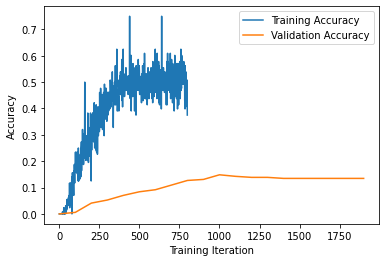

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()